
# Text minig with Quora Insincere Questions Classification


#### Sommaire

I.	ANALYSE EXPLORATOIRE DES DONNEES


II.	PREPARATION DES DONNEES 

1.	Vectorization du texte

    
2.	Selection des variables

III.	MODELISATION 


    
2.	Modèle selectionné

3.	Hyperparameters tuning




In [25]:
%ls

40 Python Interview and Answer_1556434162.pdf
AI_Python_1565122869.pdf
API_11_DS2_en_csv_v2_42980/
A_B Testing.ipynb
Agriculture/
Agriculture_Data.ipynb
Algo/
Algorithms_Note_for_professionals_1566716738.pdf
Book/
Chapter-10---Normal-Crime_2015_Data-Mining-and-Predictive-Analysis.pdf*
Chapter-16---Future-Trends_2015_Data-Mining-and-Predictive-Analysis.pdf*
Chapter-2---Domain-Expertise_2015_Data-Mining-and-Predictive-Analysis.pdf*
Chapter-4---Process-Models-for-Data-Mining-and_2015_Data-Mining-and-Predicti.pdf*
Cleaning_Data_NLP.ipynb
Copyright_2015_Data-Mining-and-Predictive-Analysis.pdf*
Cora_competition.ipynb
Correlation Matrice.png
Customer_Behaviour_1566388260.pdf
DATA_SCIENCE_INTERVIEW_QUESTIONS.pdf
Data science - copie.pdf
Data_Visualization_in_Practice_1566388340.pdf
Dedication_2015_Data-Mining-and-Predictive-Analysis.pdf*
Digital-Assets_2015_Data-Mining-and-Predictive-Analysis.pdf*
Feature_Engineering_for_Machine_Learning.pdf
Features_Engineering_Boxplot.png
Features_Engineerin

In [26]:
import os
print(os.listdir("/Users/garbamoussa/Desktop/Python_ML/quora-insincere-questions-classification"))

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from zipfile import ZipFile
from math import radians, cos, sin, asin, sqrt
from datetime import datetime
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk import wordnet, pos_tag
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet as wn
import re
import string

['quora-insincere-questions-classification.zip']


In [27]:
import pandas as pd
import zipfile

zf_train = zipfile.ZipFile("/Users/garbamoussa/Desktop/Python_ML/quora-insincere-questions-classification/quora-insincere-questions-classification.zip") # having First.csv zipped file.
zf_test = zipfile.ZipFile("/Users/garbamoussa/Desktop/Python_ML/quora-insincere-questions-classification/quora-insincere-questions-classification.zip")
zf_submission = zipfile.ZipFile("/Users/garbamoussa/Desktop/Python_ML/quora-insincere-questions-classification/quora-insincere-questions-classification.zip")
#zf_test = zipfile.ZipFile("/Users/garbamoussa/Desktop/Python_ML/nyc-taxi-trip-duration/test.zip")
train = pd.read_csv(zf_train.open('train.csv'))
test = pd.read_csv(zf_test.open('test.csv'))
sample_submission  = pd.read_csv(zf_test.open('sample_submission.csv'))

In [28]:
train.shape

(1306122, 3)

In [29]:
train.head()

qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

In [30]:
train1 = train.sample(frac=0.3,random_state=200)

In [31]:
train1.shape

(391837, 3)

In [32]:
test.shape

(375806, 2)

In [36]:
test1 = test.sample(frac=0.3,random_state=200)

In [37]:
test1.shape

(112742, 2)

In [38]:
import pandas as pd 
import numpy as np
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

#cora_data = pd.read_csv('all/train.csv')
#cora_test_data = pd.read_csv('all/test.csv')
cora_data = train1.copy()
cora_test_data = test1.copy()

# I. ANALYSE EXPLORATOIRE DES DONNEES

In [39]:
cora_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391837 entries, 463988 to 30390
Data columns (total 3 columns):
qid              391837 non-null object
question_text    391837 non-null object
target           391837 non-null int64
dtypes: int64(1), object(2)
memory usage: 12.0+ MB


In [40]:
#Verification presence données manquantes
cora_data[cora_data['question_text'].isnull()]

Empty DataFrame
Columns: [qid, question_text, target]
Index: []

In [41]:
#Verification presence données manquantes
cora_data[cora_data['target'].isnull()]

Empty DataFrame
Columns: [qid, question_text, target]
Index: []

Nous avons zero données manquantes dans cette base de données.

In [42]:
percent_target = cora_data.groupby('target').count()
percent_target['percent'] = 100*(percent_target['question_text']/cora_data['target'].count())
percent_target.reset_index(level=0, inplace=True)
percent_target

target     qid  question_text    percent
0       0  367782         367782  93.860968
1       1   24055          24055   6.139032

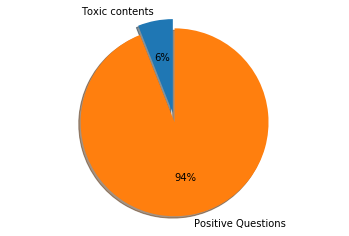

In [43]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Toxic contents','Positive Questions'
sizes = [6, 94]
explode = (0.1, 0)  # only "explode" the 1st slice (i.e. 'Toxic contents')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


### **1. Echantillonnage**

We are in presence of a unbalenced data base. So we will try to increase the rate of the negative comments. (This way i also decrease the size of the database because my personnal computer don't have enought cpu to run the jobs on all the database.)

The final goal is to have 40% of negatives comments.

In [44]:
cora_data_neg_sample = cora_data[cora_data['target'] == 1] #Negatives comments
cora_data_positive_sample = cora_data[cora_data['target'] == 0].reindex()  #Positive Comments

cora_resampling = pd.concat([pd.DataFrame(cora_data_positive_sample.sample(6000)), #130000
                               pd.DataFrame(cora_data_neg_sample.sample(3650))])

In [45]:
100*(cora_resampling.groupby('target')['question_text'].count())/cora_resampling['target'].count()

target
0    62.176166
1    37.823834
Name: question_text, dtype: float64

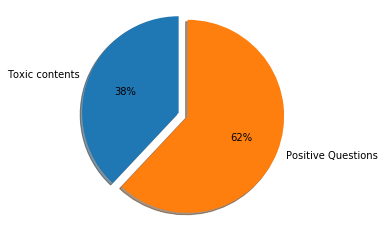

In [46]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Toxic contents','Positive Questions'
sizes = [38, 62]
explode = (0.1, 0)  # only "explode" the 1st slice (i.e. 'Toxic contents')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


### **2. Features engineering**

In [47]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk import wordnet, pos_tag
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet as wn
import re
import string

#Cleaning data

def clean_str(chaine):
    chaine = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", chaine)     
    chaine = re.sub(r"\'s", " \'s", chaine) 
    chaine = re.sub(r"\'ve", " \'ve", chaine) 
    chaine = re.sub(r"n\'t", " n\'t", chaine) 
    chaine = re.sub(r"\'re", " \'re", chaine) 
    chaine = re.sub(r"\'d", " \'d", chaine) 
    chaine = re.sub(r"\'ll", " \'ll", chaine) 
    chaine = re.sub(r",", " , ", chaine) 
    chaine = re.sub(r"!", " ! ", chaine) 
    chaine = re.sub(r"\(", " \( ", chaine) 
    chaine = re.sub(r"\)", " \) ", chaine) 
    chaine = re.sub(r"\?", " \? ", chaine) 
    chaine = re.sub(r"\s{2,}", " ", chaine)
    chaine = chaine.lower() #convert all text in lower case
    chaine = chaine.replace(' +', ' ') # Remove double space
    chaine = chaine.strip() # Remove trailing space at the beginning or end
    chaine = chaine.replace('[^a-zA-Z]', ' ' )# Everything not a alphabet character replaced with a space
    #words =  [word for word in chaine.split() if word not in [i for i in string.punctuation]] #Remove punctuations
    words =  [word for word in chaine.split() if word.isalpha()] #droping numbers and punctuations
    return ' '.join(words)

#Tokenization and punctuation removing and stopwords
def tokeniZ_stopWords(chaine):
    chaine = word_tokenize(chaine)
    list_stopWords = set(stopwords.words('english'))
    words = [word for word in chaine if word not in list_stopWords]
    return words

#Stemming 
ps = PorterStemmer()
sb = SnowballStemmer('english')

#Lemmatization
def lemat_words(tokens_list):
    from collections import defaultdict
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    lemma_function = WordNetLemmatizer()
    return [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens_list)]
    #for token, tag in pos_tag(tokens_list):
     #   lemma = lemma_function.lemmatize(token, tag_map[tag[0]])

# Define Ngrams function
def get_ngrams(text, n ):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

In [48]:
#Cleaning the data 
cora_resampling['clean_question'] = cora_resampling['question_text'].apply(clean_str)

In [49]:
#Tokenizing and stopwords removing
cora_resampling['tokeniZ_stopWords_question'] = cora_resampling['clean_question'].apply(tokeniZ_stopWords)

In [50]:
#Words Stemming
cora_resampling['stemming_question'] = [[ps.stem(word) for word in words] for words in cora_resampling['tokeniZ_stopWords_question'] ]
cora_resampling['stemming_question_for_tfidf'] = [' '.join(words) for words in cora_resampling['stemming_question']] 

In [51]:
#Words lemmatization
cora_resampling['lemmatize_question'] = cora_resampling['tokeniZ_stopWords_question'].apply(lemat_words)
cora_resampling['lemmatize_question_for_tfidf'] = [' '.join(x) for x in cora_resampling['lemmatize_question'] ]

In [52]:
#Calcul longueur des commentaires
cora_resampling['question_lenght'] = cora_resampling['question_text'].apply(len)

In [53]:
#Calcul du nombre de ponctuation par question
from string import punctuation
cora_resampling['number_punctuation'] = cora_resampling['question_text'].apply(
    lambda doc: len([word for word in str(doc) if word in punctuation])) 

In [54]:
#Number of unique words in the text
cora_resampling['number_of_Unique_words'] = cora_resampling['clean_question'].apply([lambda x : len(set(str(x).split()))])

In [55]:
#Number of stopwords in the text
list_stopWords = set(stopwords.words('english'))
cora_resampling['number_of_StopWords'] = cora_resampling['clean_question'].apply(
    lambda x : len([w for w in x.lower().split() if w in list_stopWords ]))

In [56]:
#Number of upper case words
cora_resampling['number_of_uppercase'] = cora_resampling['question_text'].apply(
    lambda x : len([w for w in x.split() if w.isupper()]))

In [57]:
#Average length of words in the text (whithout stop words)
cora_resampling['average_of_wordsLength'] = cora_resampling['clean_question'].apply(
    lambda x : np.mean([len(w) for w in x.split()]))

In [58]:
#Number of words in the text
cora_resampling['number_of_words'] = cora_resampling['clean_question'].apply([lambda x : len(str(x).split())])

In [59]:
cora_resampling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9650 entries, 390132 to 441036
Data columns (total 16 columns):
qid                             9650 non-null object
question_text                   9650 non-null object
target                          9650 non-null int64
clean_question                  9650 non-null object
tokeniZ_stopWords_question      9650 non-null object
stemming_question               9650 non-null object
stemming_question_for_tfidf     9650 non-null object
lemmatize_question              9650 non-null object
lemmatize_question_for_tfidf    9650 non-null object
question_lenght                 9650 non-null int64
number_punctuation              9650 non-null int64
number_of_Unique_words          9650 non-null int64
number_of_StopWords             9650 non-null int64
number_of_uppercase             9650 non-null int64
average_of_wordsLength          9650 non-null float64
number_of_words                 9650 non-null int64
dtypes: float64(1), int64(7), object(8)
memo

In [60]:
cora_resampling[['question_lenght', 'number_punctuation', 'number_of_words',
       'number_of_Unique_words', 'number_of_StopWords', 'number_of_uppercase',
       'average_of_wordsLength']].sample(5)

question_lenght  number_punctuation  number_of_words  \
4339                 134                   1               22   
1044025              206                   4               30   
717187                43                   1                8   
1010729               79                   3               15   
1093346               53                   1                9   

         number_of_Unique_words  number_of_StopWords  number_of_uppercase  \
4339                         19                   10                    0   
1044025                      26                   10                    0   
717187                        8                    5                    0   
1010729                      14                    7                    0   
1093346                       9                    5                    0   

         average_of_wordsLength  
4339                   5.090909  
1044025                5.600000  
717187                 4.375000  
1010729                4.000000  
1093346                4.888889

### **3. Data visualisation**

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

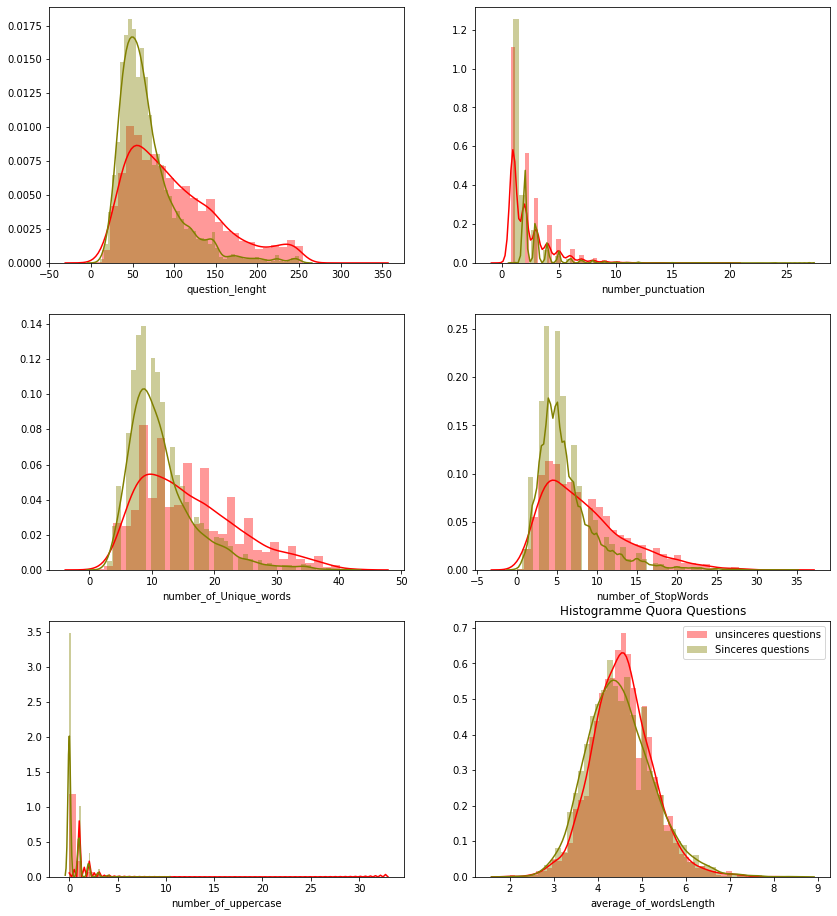

In [62]:
list_var=['question_lenght', 'number_punctuation', 'number_of_Unique_words', 
          'number_of_StopWords', 'number_of_uppercase', 'average_of_wordsLength']
def var_hist_global(df,X='target',Y=list_var, Title='Features Engineering - Histograms', KDE=False):
    fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2 ,figsize=(14,16))#, sharey=True )
    aX = [ax1, ax2,ax3,ax4,ax5,ax6]
    for i in range(len(list_var)):   
        sns.distplot( df[list_var[i]][df[X]== 1 ].dropna(), label="unsinceres questions" , ax= aX[i], kde= KDE , color = 'red')           
        sns.distplot( df[list_var[i]][df[X]== 0 ].dropna(), label="Sinceres questions"   , ax= aX[i], kde= KDE , color = "olive")
    plt.legend()
    plt.title(Title)
    #plt.show()
    plt.savefig("Features_Engineering_Histograms")
    
var_hist_global(df=cora_resampling,X='target',Y=list_var, Title='Histogramme Quora Questions', KDE=True)

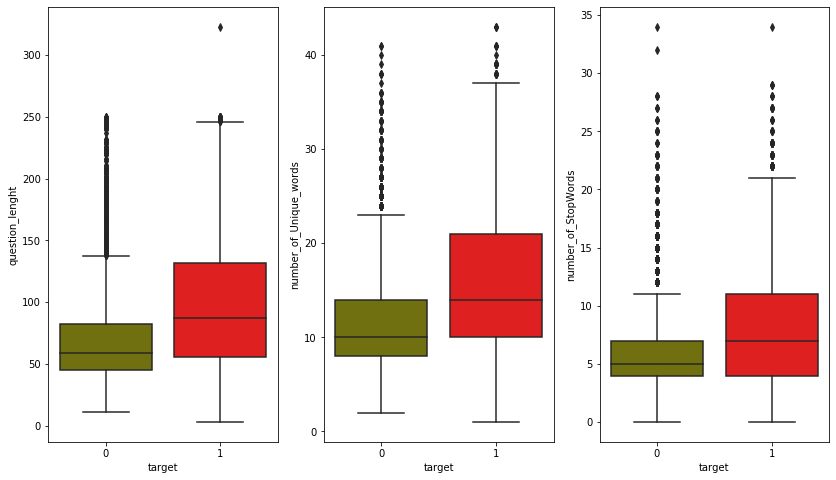

In [63]:
# Calculate number of obs per group & median to position labels
list_var = ['question_lenght', 'number_of_Unique_words', 'number_of_StopWords']
def violin_boxplott(df,X='target',Y=list_var, Title='Features Engineering - Box plot'): 
    fig, (ax1, ax2 ,ax3) = plt.subplots(1,3 ,figsize=(14,8))#, sharey=True )
    medians = cora_resampling.groupby(['target'])['question_lenght', 'number_of_Unique_words', 'number_of_StopWords'].median().values
 
    sns.boxplot( y=list_var[0],  x=X , data = df, ax= ax1 , palette=['olive','red'])
    sns.boxplot( y=list_var[1],  x=X , data = df, ax= ax2 , palette=['olive','red'])
    sns.boxplot( y=list_var[2],  x=X , data = df, ax= ax3 , palette=['olive','red'])
    #plt.title(Title)
    plt.savefig("Features_Engineering_Boxplot")
violin_boxplott(df=cora_resampling)

On constate que les variables suivantes : 
    - number_punctuation, number_of_uppercase et average_of_wordsLength ne sont pas discriminante par rapport à la cible. 
    En effet, les distribution des questions sincères et pas sincières sont quasiment les memes. 
    Elles seront peu voir pas du tout significatives pour expliquer le modèle.

In [64]:
from wordcloud import WordCloud, STOPWORDS
# Code recuperer de : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'quora','br', 'Po', 'th', 'sayi', 'fo', 'Unknown','will','say','now','must','want','much','talks','buy','dont','use','etc','go','ago','lot','ki', 'ba'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.savefig(title)
    plt.tight_layout()  

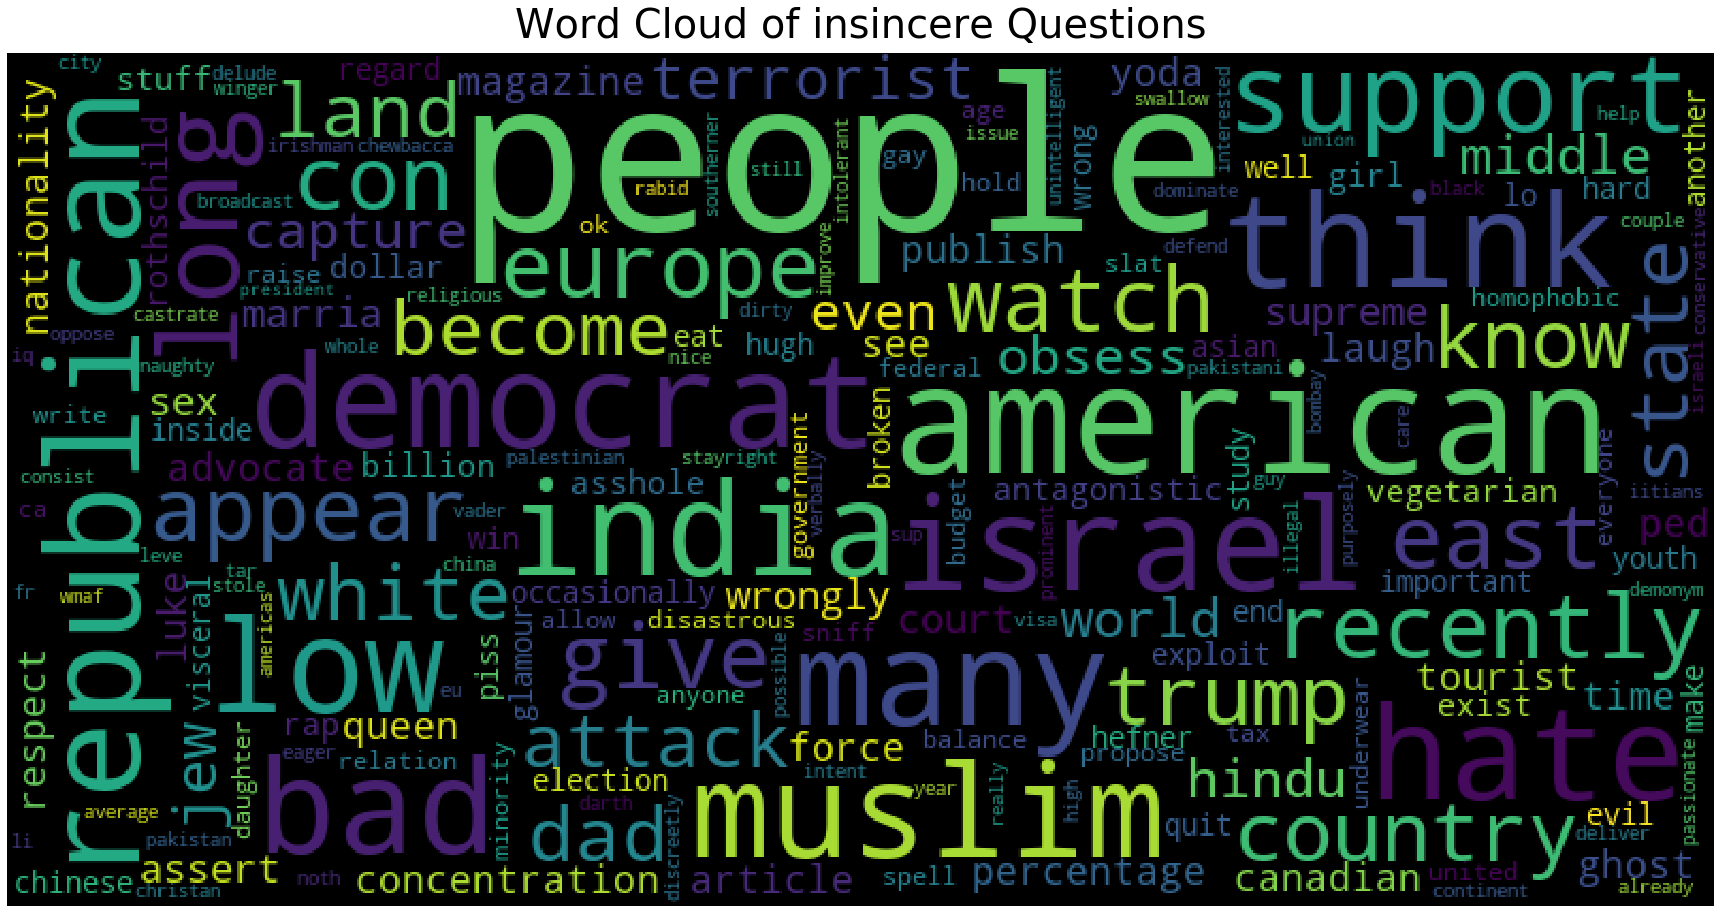

In [65]:
#plot_wordcloud(cora_data_neg_sample["question_text"], title="Word Cloud of insincere Questions")
#plot_wordcloud(cora_resampling['tokeniZ_stopWords_question'][cora_resampling['target']== 1]) 
plot_wordcloud(cora_resampling['lemmatize_question_for_tfidf'][cora_resampling['target']== 1], title="Word Cloud of insincere Questions") 

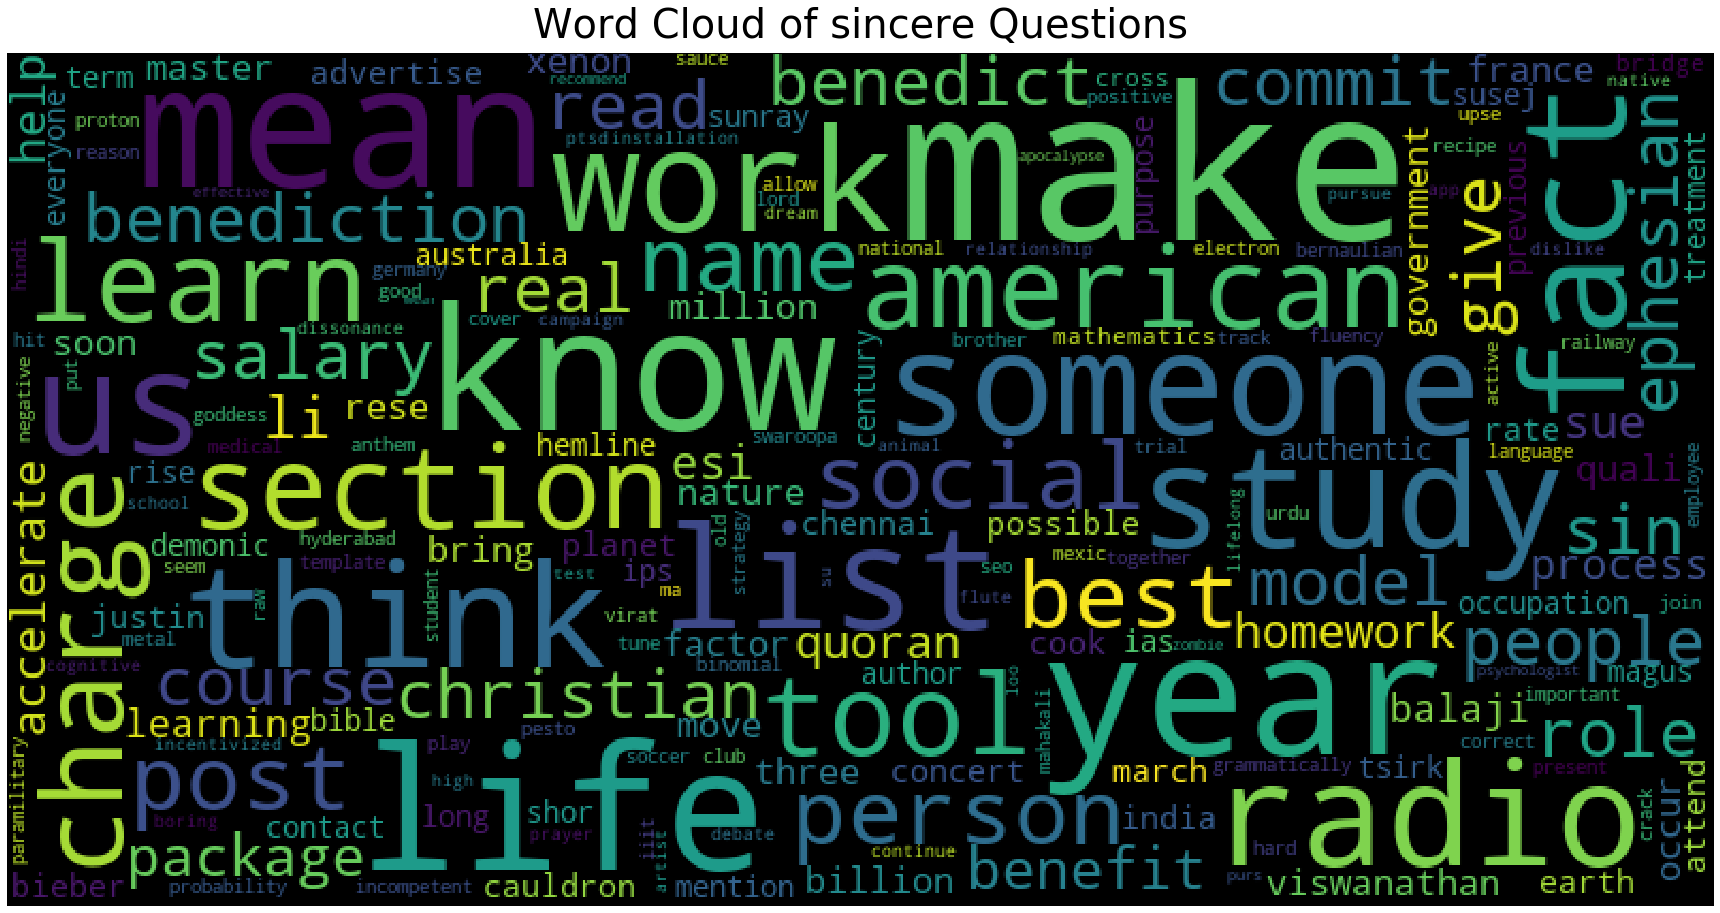

In [66]:
#plot_wordcloud(cora_data_positive_sample["question_text"], title="Word Cloud of sincere Questions")
plot_wordcloud(cora_resampling['lemmatize_question_for_tfidf'][cora_resampling['target']== 0], title="Word Cloud of sincere Questions")

SI POSSIBLE Essayer de faire l'histogramme du T3gram et Bigram.

In [67]:
# Code source : https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc
from collections import defaultdict
from wordcloud import  STOPWORDS
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

#train1_df = train_df[train_df["target"]==1]
#train0_df = train_df[train_df["target"]==0]
train1_df = cora_resampling[cora_resampling['target']==1]
train0_df = cora_resampling[cora_resampling['target']==0]
## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["lemmatize_question_for_tfidf"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["lemmatize_question_for_tfidf"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

#plt.figure(figsize=(10,16))
#sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
#plt.title("Frequent words for Insincere Questions", fontsize=16)
#plt.show()

//anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [68]:
freq_dict = defaultdict(int)
for sent in train0_df["lemmatize_question_for_tfidf"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["lemmatize_question_for_tfidf"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(20), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots - N_gram(2,2)")
py.iplot(fig, filename='word-plots')

In [69]:
freq_dict = defaultdict(int)
for sent in train0_df["lemmatize_question_for_tfidf"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["lemmatize_question_for_tfidf"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(20), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of sincere questions", 
                                          "Frequent trigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots - N_gram(3,3)")
py.iplot(fig, filename='word-plots')

# II. PREPARATION DES DONNEES 

In [70]:
cora_resampling.columns

Index(['qid', 'question_text', 'target', 'clean_question',
       'tokeniZ_stopWords_question', 'stemming_question',
       'stemming_question_for_tfidf', 'lemmatize_question',
       'lemmatize_question_for_tfidf', 'question_lenght', 'number_punctuation',
       'number_of_Unique_words', 'number_of_StopWords', 'number_of_uppercase',
       'average_of_wordsLength', 'number_of_words'],
      dtype='object')

In [71]:
from sklearn.model_selection import train_test_split
X_cora_train, X_cora_test, y_cora_train, y_cora_test = train_test_split(
            cora_resampling[['clean_question', 'stemming_question_for_tfidf', 'lemmatize_question_for_tfidf',
                             'tokeniZ_stopWords_question', 'stemming_question', 'lemmatize_question',
                             'question_lenght', 'number_punctuation', 'number_of_StopWords', 'number_of_Unique_words', 'number_of_uppercase','average_of_wordsLength']]
            ,cora_resampling['target'], 
            test_size=0.3, random_state=42)
X_cora_train.shape, X_cora_test.shape, y_cora_train.shape, y_cora_test.shape

((6755, 12), (2895, 12), (6755,), (2895,))

### **1. Vectorization des données**

#### **1.1 Tf-Idf Vectorizer** 

In [180]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(  ngram_range=(1,1), 
                                     analyzer='word',
                                     stop_words='english', 
                                     lowercase=True, 
                                     max_df=0.9, # remove too frequent words
                                     min_df=10, # remove too rare words
                                     max_features = None, # max words in vocabulary, will keep most frequent words
                                     binary=False #If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.
                                  )

In [181]:
#Stemmed questions vectorzation
X_tfidf_vectorizer_train = tfidf_vectorizer.fit_transform(X_cora_train['stemming_question_for_tfidf'])
X_tfidf_vectorizer_test = tfidf_vectorizer.transform(X_cora_test['stemming_question_for_tfidf'])

In [182]:
#Lemmentized questions vectorization
X_tfidf_Lem_vect_train = tfidf_vectorizer.fit_transform(X_cora_train['lemmatize_question_for_tfidf'])
X_tfidf_Lem_vect_test = tfidf_vectorizer.transform(X_cora_test['lemmatize_question_for_tfidf'])

In [183]:
#bigram questions vectorization
bigram_vectorizer = TfidfVectorizer(  ngram_range=(1,2), 
                                     analyzer='word',
                                     stop_words='english', 
                                     lowercase=True, 
                                     max_df=0.9, # remove too frequent words
                                     min_df=10, # remove too rare words
                                     max_features = None, # max words in vocabulary, will keep most frequent words
                                     binary=False #If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.
                                  )
X_bigram_vectorizer_train = bigram_vectorizer.fit_transform(X_cora_train['stemming_question_for_tfidf'])
X_bigram_vectorizer_test = bigram_vectorizer.transform(X_cora_test['stemming_question_for_tfidf'])

In [190]:
#T3gram questions vectorization
t3gram_vectorizer = TfidfVectorizer(  ngram_range=(1,4), 
                                     analyzer='word',
                                     stop_words='english', 
                                     lowercase=True, 
                                     max_df=0.9, # remove too frequent words
                                     min_df=10, # remove too rare words
                                     max_features = None, # max words in vocabulary, will keep most frequent words
                                     binary=False #If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.
                                  )
X_t3gram_vectorizer_train_ = t3gram_vectorizer.fit_transform(X_cora_train['stemming_question_for_tfidf'])
X_t3gram_vectorizer_test_  = t3gram_vectorizer.transform(X_cora_test['stemming_question_for_tfidf'])

In [185]:
#Range single word to t3gram questions vectorization
st3gram_vectorizer = TfidfVectorizer(  ngram_range=(1,3), 
                                     analyzer='word',
                                     stop_words='english', 
                                     lowercase=True, 
                                     max_df=0.9, # remove too frequent words
                                     min_df=10, # remove too rare words
                                     max_features = None, # max words in vocabulary, will keep most frequent words
                                     binary=False #If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.
                                  )
X_Singt3gram_vectorizer_train = st3gram_vectorizer.fit_transform(X_cora_train['stemming_question_for_tfidf'])
X_Singt3gram_vectorizer_test  = st3gram_vectorizer.transform(X_cora_test['stemming_question_for_tfidf'])

In [281]:
X_Singt3gram_vectorizer_train

<6755x885 sparse matrix of type '<class 'numpy.float64'>'
	with 25095 stored elements in Compressed Sparse Row format>

#### **1.2 Word embedding - Doc2Vec**

In [186]:
#Word2Vec with preprocessiong questions (without stopwords) 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

d2v_training_data = []
for i, doc in enumerate(X_cora_train['stemming_question']):
    d2v_training_data.append(TaggedDocument(words=doc,tags=[i]))

# ========== learning doc embeddings with doc2vec ==========

# PV stands for 'Paragraph Vector'
# PV-DBOW (distributed bag-of-words) dm=0

d2v = Doc2Vec(d2v_training_data, vector_size=300, window=10, alpha=0.1, min_alpha=1e-4, dm=0, negative=1, epochs=10, min_count=2, workers=4)
d2v_vecs = np.zeros((len(X_cora_train['stemming_question']), 300))
for i in range(len(X_cora_train['stemming_question'])):
    d2v_vecs[i,:] = d2v.docvecs[i]
    
d2v_test = np.zeros((len(X_cora_test['stemming_question']), 300))
for i in range(len(X_cora_test['stemming_question'])):
    d2v_test[i,:] = d2v.infer_vector(X_cora_test['stemming_question'].iloc[i])

In [187]:
#Word2Vec with lemmatize words
d2v_training_data = []
for i, doc in enumerate(X_cora_train['lemmatize_question']):
    d2v_training_data.append(TaggedDocument(words=doc,tags=[i]))

# ========== learning doc embeddings with doc2vec ==========

# PV stands for 'Paragraph Vector'
# PV-DBOW (distributed bag-of-words) dm=0

d2v = Doc2Vec(d2v_training_data, vector_size=200, window=5, alpha=0.1, min_alpha=1e-4, 
              dm=0, negative=1, epochs=10, min_count=2, workers=4)
d2v_vecs_bigram = np.zeros((len(X_cora_train['lemmatize_question']), 200))
for i in range(len(X_cora_train['lemmatize_question'])):
    d2v_vecs_bigram[i,:] = d2v.docvecs[i]
    
d2v_test_bigram = np.zeros((len(X_cora_test['lemmatize_question']), 200))
for i in range(len(X_cora_test['lemmatize_question'])):
    d2v_test_bigram[i,:] = d2v.infer_vector(X_cora_test['lemmatize_question'].iloc[i])

### **2. FEATURES SELECTION**

Faisons un test non parametrique d'indépendance entre les variables quantitatives créées et la variable cible. 
H0 (indépendance entre une variable données et la varibale cible) est rejetée si la P_value <= 0.05 

In [80]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SelectPercentile
from sklearn.pipeline import Pipeline

In [81]:
features = SelectKBest(mutual_info_classif,k=2).fit(X_cora_train[['question_lenght', 'number_punctuation', 'number_of_StopWords', 'number_of_Unique_words', 
                                        'number_of_uppercase','average_of_wordsLength']].fillna(0),y_cora_train)
independance_test = np.zeros((6,2))
for idx,i in enumerate(['question_lenght', 'number_punctuation', 'number_of_StopWords', 'number_of_Unique_words', 'number_of_uppercase','average_of_wordsLength']):
    #independance_test[idx,0]= features.pvalues_[idx]
    independance_test[idx,1]= features.scores_[idx]
    #print (i,features.pvalues_[idx],features.scores_[idx])
    #print('%s  %s'%(i,features.scores_[idx]))

In [82]:
list_var=['question_lenght', 'number_punctuation', 'number_of_StopWords', 'number_of_Unique_words', 'number_of_uppercase','average_of_wordsLength']
independance_df = pd.DataFrame({'Variables': list_var, 'p_values': independance_test[:,0], 'MI': independance_test[:,1]},index=None)
independance_df

Variables  p_values        MI
0         question_lenght       0.0  0.054974
1      number_punctuation       0.0  0.019976
2     number_of_StopWords       0.0  0.028547
3  number_of_Unique_words       0.0  0.041315
4     number_of_uppercase       0.0  0.009519
5  average_of_wordsLength       0.0  0.032612

On rejette H0 en faveur de l'hypothèse alternative (dépendance avec la variable cible) pour l'ensemble des variables textées.

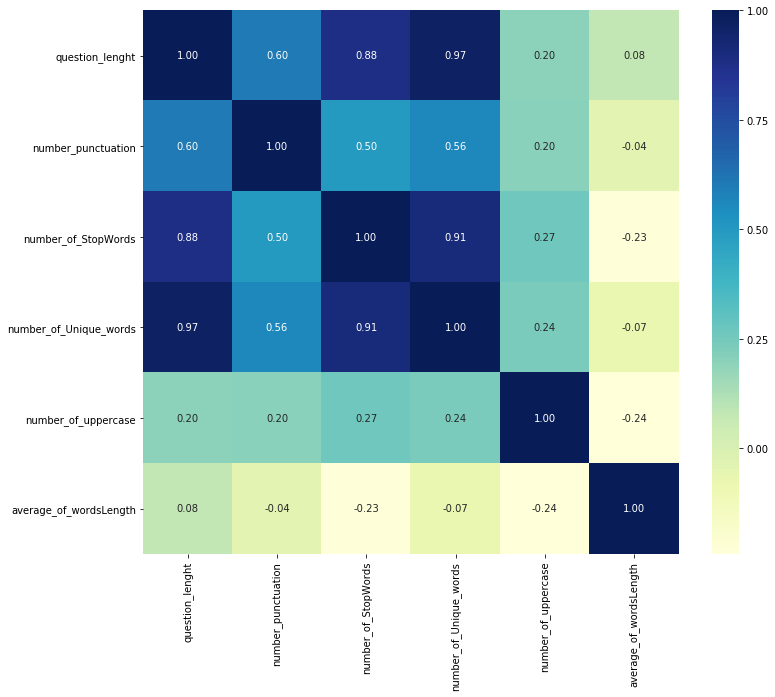

In [83]:
plt.figure(figsize=(12, 10))
_ = sns.heatmap(cora_resampling[['question_lenght', 'number_punctuation', 'number_of_StopWords', 
                                 'number_of_Unique_words', 'number_of_uppercase','average_of_wordsLength']].corr()
                ,cmap="YlGnBu", annot=True, fmt=".2f")
plt.savefig("Correlation Matrice")
plt.show()

**Pour les matrices generées à partir des textes via tf_idf et Doc2Vec nous appliquerons un filtre sur les features si nécessaire dans la section qui suit (lors de la modélisation).**

# III. MODELISATION


### **1. Description du process de modélisation**
Nou testerons dans cette section plusieurs modèles de classification tels les SVM, les methodes ensembles (RF, adaboost,...), Reseaux de neurones etc... dans l'objectif de choisir le meilleur modèle. Puis nous optimiserons les hyperparametres des modèles qui nous semblent les plus performants. Enfin nous generons les courbes d'apprentissage afn d'évaluer le niveau d'apprentissage de ces modèles pour verifer l'overfitting où  l'underfitting. 

In [84]:
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

def plot_learning_curve(estimator1, X, y, estimator2, ylim=(0, 1.1), cv=2, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    
    
    plt.figure(figsize=(12,6))
    #plt.title("Learning curves for %s" % type(estimator1).__name__)
    #plt.title("Learning curves for %s" %(estimator1))
    plt.grid()
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.xscale('log')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.subplot(1, 2, 1)
    plt.title("Learning curves for %s" % type(estimator1).__name__)
    plt.plot(
        train_sizes, train_scores_mean, 'o-',
        color="r", #linewidth=3, 
        label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, 'o-',
        color="olive", 
        label="Cross-validation score")
    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, alpha=0.1,
        color="firebrick")
    plt.fill_between(
        train_sizes, test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, alpha=0.1, color="darkgoldenrod")
    plt.legend(loc="best")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.subplot(1, 2, 2)
    plt.title("Learning curves for %s with 70 percent of best features" % type(estimator1).__name__)
    plt.plot(
        train_sizes, train_scores_mean, 'o-',
        color="r", #linewidth=3, 
        label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, 'o-',
        color="olive", 
        label="Cross-validation score")
    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, alpha=0.1,
        color="firebrick")
    plt.fill_between(
        train_sizes, test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, alpha=0.1, color="darkgoldenrod")
    plt.legend(loc="best")
    plt.savefig("Learning curves for %s" % type(estimator1).__name__)

In [85]:
df_models = pd.DataFrame({'Models':[], 'Sample':[], 'Accuracy':[],'Accuracy with 70% best features':[]})
data=[]

def modelize(list_clf,X,y,X_test,y_test):
    selector = SelectPercentile(mutual_info_classif,percentile=70)
    for clf in list_clf:
        Clf1 = clf().fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf())]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=2 , test_size=.3, random_state=51)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted'),accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Training', 'Accuracy':accuracy_score(y,Clf1.predict(X)),'Accuracy with 70% best features':accuracy_score(y,Clf2.predict(X)) })
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Test', 'Accuracy':accuracy_score(y_test,Clf1.predict(X_test)),'Accuracy with 70% best features':accuracy_score(y_test,Clf2.predict(X_test)) })
        #plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')

In [86]:
from sklearn.linear_model import LogisticRegressionCV , PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import NuSVC, LinearSVC, SVC, OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB

In [87]:
generalized_linear_model = [LogisticRegressionCV,PassiveAggressiveClassifier]
support_vector_machines =  [NuSVC, LinearSVC]   
decisionTreeClassification=[DecisionTreeClassifier]
ensemble_methods = [RandomForestClassifier , ExtraTreesClassifier,AdaBoostClassifier, GradientBoostingClassifier]
naive_bayes_model = [GaussianNB, MultinomialNB, ComplementNB]

#### **1.1 MODELISATION AVEC TF-IDF A PARTIR DES DONNEES SOUMISES A LA STEMMIZATION (1,1)**

In [88]:
#Generalized Linear Model
modelize(generalized_linear_model,X_tfidf_vectorizer_train,y_cora_train,X_tfidf_vectorizer_test,y_cora_test)

Model : LogisticRegressionCV
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.873723                   0.872691           /    0.864693                   0.863316
Test     :       0.826252                   0.824088           /    0.829016                   0.826385
Model : PassiveAggressiveClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.879349                   0.877767           /    0.864101                   0.863684
Test     :       0.810017                   0.806751           /    0.815544                   0.814430


**SVM For Unbalanced problems**

In problems where it is desired to give more importance to certain classes or certain individual samples keywords **class_weight** and **sample_weight** can be used.
**SVC** (but not **NuSVC**) implement a keyword **class_weight** in the **fit** method. 
It’s a dictionary of the form **{class_label : value}**, where value is a floating point number > 0 that sets the parameter **C** of class **class_label** to **C * value**.

In [89]:
def modelize_svc(list_clf,X,y,X_test,y_test):
    selector = SelectPercentile(mutual_info_classif,percentile=70)
    for clf in list_clf:
        Clf1 = clf(kernel='poly').fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(kernel='poly'))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=2 , test_size=.3, random_state=51)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Training', 'Accuracy':accuracy_score(y_test,Clf1.predict(X_test))
                       ,'Accuracy with 70% best features':accuracy_score(y_test,Clf2.predict(X_test)) })
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Test', 'Accuracy':accuracy_score(y_test,Clf1.predict(X_test))
                       ,'Accuracy with 70% best features':accuracy_score(y_test,Clf2.predict(X_test)) })
        #plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')
#Support Vector Machine
#modelize_svc([SVC],X_tfidf_vectorizer_train,y_cora_train,X_tfidf_vectorizer_test,y_cora_test)

In [90]:
#Support Vector Machine
modelize(support_vector_machines,X_tfidf_vectorizer_train,y_cora_train,X_tfidf_vectorizer_test,y_cora_test)

Model : NuSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.861584                   0.860169           /    0.853886                   0.851986
Test     :       0.827288                   0.824702           /    0.828325                   0.825777
Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.882309                   0.881724           /    0.868542                   0.867658
Test     :       0.824180                   0.822477           /    0.825216                   0.823061


In [91]:
#Decision Tree
modelize(decisionTreeClassification,X_tfidf_vectorizer_train,y_cora_train,X_tfidf_vectorizer_test,y_cora_test)

Model : DecisionTreeClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.986528                   0.986493           /    0.985196                   0.985152
Test     :       0.796891                   0.795980           /    0.798618                   0.797736


In [92]:
#Ensemble Methods
modelize(ensemble_methods,X_tfidf_vectorizer_train,y_cora_train,X_tfidf_vectorizer_test,y_cora_test)       

Model : RandomForestClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.975278                   0.975182           /    0.975278                   0.975193
Test     :       0.808636                   0.805665           /    0.805527                   0.802428
Model : ExtraTreesClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.986528                   0.986493           /    0.985196                   0.985152
Test     :       0.815199                   0.813893           /    0.805527                   0.802265
Model : AdaBoostClassifier
With all features                                              /    With 70% of the best feat

In [93]:
#Naives bayes
modelize([ MultinomialNB, ComplementNB],X_tfidf_vectorizer_train,y_cora_train,X_tfidf_vectorizer_test,y_cora_test)

Model : MultinomialNB
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.841895                   0.840685           /    0.829756                   0.826315
Test     :       0.814162                   0.812294           /    0.810708                   0.806681
Model : ComplementNB
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.826499                   0.828630           /    0.820133                   0.822083
Test     :       0.798618                   0.801385           /    0.798964                   0.801394


In [94]:
#Neural Network - Consomme beaucoup trop d'energie
Neural_network= [MLPClassifier]
modelize(Neural_network,X_tfidf_vectorizer_train,y_cora_train,X_tfidf_vectorizer_test,y_cora_test)

Model : MLPClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.986380                   0.986368           /    0.982235                   0.982163
Test     :       0.808290                   0.807111           /    0.814853                   0.812030


In [95]:
models_df =pd.concat([pd.DataFrame(data),df_models],ignore_index=True)  
models_df.sort_values(by=['Accuracy','Models','Sample'], ascending=False, axis=0, inplace=True)
test_df = pd.DataFrame(np.array(models_df[['Accuracy', 'Accuracy with 70% best features']]),
                       index=[models_df['Models'],models_df['Sample']], columns=['Accuracy', 'Accuracy with 70% best features'])

In [96]:
test_df

Accuracy  \
Models                      Sample               
ExtraTreesClassifier        Training  0.986528   
DecisionTreeClassifier      Training  0.986528   
MLPClassifier               Training  0.986380   
RandomForestClassifier      Training  0.975278   
LinearSVC                   Training  0.882309   
PassiveAggressiveClassifier Training  0.879349   
LogisticRegressionCV        Training  0.873723   
NuSVC                       Training  0.861584   
MultinomialNB               Training  0.841895   
NuSVC                       Test      0.827288   
ComplementNB                Training  0.826499   
LogisticRegressionCV        Test      0.826252   
LinearSVC                   Test      0.824180   
ExtraTreesClassifier        Test      0.815199   
MultinomialNB               Test      0.814162   
AdaBoostClassifier          Training  0.810215   
PassiveAggressiveClassifier Test      0.810017   
RandomForestClassifier      Test      0.808636   
GradientBoostingClassifier  Training  0.808438   
MLPClassifier               Test      0.808290   
AdaBoostClassifier          Test      0.804145   
ComplementNB                Test      0.798618   
DecisionTreeClassifier      Test      0.796891   
GradientBoostingClassifier  Test      0.779620   

                                      Accuracy with 70% best features  
Models                      Sample                                     
ExtraTreesClassifier        Training                         0.985196  
DecisionTreeClassifier      Training                         0.985196  
MLPClassifier               Training                         0.982235  
RandomForestClassifier      Training                         0.975278  
LinearSVC                   Training                         0.868542  
PassiveAggressiveClassifier Training                         0.864101  
LogisticRegressionCV        Training                         0.864693  
NuSVC                       Training                         0.853886  
MultinomialNB               Training                         0.829756  
NuSVC                       Test                             0.828325  
ComplementNB                Training                         0.820133  
LogisticRegressionCV        Test                             0.829016  
LinearSVC                   Test                             0.825216  
ExtraTreesClassifier        Test                             0.805527  
MultinomialNB               Test                             0.810708  
AdaBoostClassifier          Training                         0.810215  
PassiveAggressiveClassifier Test                             0.815544  
RandomForestClassifier      Test                             0.805527  
GradientBoostingClassifier  Training                         0.810511  
MLPClassifier               Test                             0.814853  
AdaBoostClassifier          Test                             0.804145  
ComplementNB                Test                             0.798964  
DecisionTreeClassifier      Test                             0.798618  
GradientBoostingClassifier  Test                             0.782038

In [97]:
test_df1=pd.merge(models_df[models_df['Sample']=='Test'],models_df[models_df['Sample']=='Training'],how='inner',on='Models')

In [98]:
final_model = pd.DataFrame( np.array(test_df1[['Sample_y','Accuracy_y', 'Accuracy with 70% best features_y','Sample_x','Accuracy_x', 'Accuracy with 70% best features_x']]),
            index=test_df1['Models'], columns=['','Accuracy', 'Accuracy with 70% best features','','Accuracy1', 'Accuracy with 70% best features'])

In [99]:
#final_model= pd.read_csv('models_stemmisation.csv')
final_model.sort_values(by=['Accuracy1'], ascending=False, axis=0, inplace=True)
final_model.rename(index=str,columns={'Unnamed: 1':'','Unnamed: 4':'', 'Accuracy':'Accuracy1', 'Accuracy with 70% best features.1':'Accuracy with 70% best features'},inplace=True)

In [100]:
final_model

Accuracy1  \
Models                                            
NuSVC                        Training  0.861584   
LogisticRegressionCV         Training  0.873723   
LinearSVC                    Training  0.882309   
ExtraTreesClassifier         Training  0.986528   
MultinomialNB                Training  0.841895   
PassiveAggressiveClassifier  Training  0.879349   
RandomForestClassifier       Training  0.975278   
MLPClassifier                Training   0.98638   
AdaBoostClassifier           Training  0.810215   
ComplementNB                 Training  0.826499   
DecisionTreeClassifier       Training  0.986528   
GradientBoostingClassifier   Training  0.808438   

                            Accuracy with 70% best features       Accuracy1  \
Models                                                                        
NuSVC                                              0.853886  Test  0.827288   
LogisticRegressionCV                               0.864693  Test  0.826252   
LinearSVC                                          0.868542  Test   0.82418   
ExtraTreesClassifier                               0.985196  Test  0.815199   
MultinomialNB                                      0.829756  Test  0.814162   
PassiveAggressiveClassifier                        0.864101  Test  0.810017   
RandomForestClassifier                             0.975278  Test  0.808636   
MLPClassifier                                      0.982235  Test   0.80829   
AdaBoostClassifier                                 0.810215  Test  0.804145   
ComplementNB                                       0.820133  Test  0.798618   
DecisionTreeClassifier                             0.985196  Test  0.796891   
GradientBoostingClassifier                         0.810511  Test   0.77962   

                            Accuracy with 70% best features  
Models                                                       
NuSVC                                              0.828325  
LogisticRegressionCV                               0.829016  
LinearSVC                                          0.825216  
ExtraTreesClassifier                               0.805527  
MultinomialNB                                      0.810708  
PassiveAggressiveClassifier                        0.815544  
RandomForestClassifier                             0.805527  
MLPClassifier                                      0.814853  
AdaBoostClassifier                                 0.804145  
ComplementNB                                       0.798964  
DecisionTreeClassifier                             0.798618  
GradientBoostingClassifier                         0.782038

#### **1.2 MODELISATION AVEC TF-IDF A PARTIR DES DONNEES SOUMISES A LA LEMMENTIZATION (1,1)**

In [101]:
#Nous utiliserons dans cette étape les modèles preselectionnés dans l'étape précedente.
generalized_linear_model2 = [LogisticRegressionCV,PassiveAggressiveClassifier]
support_vector_machines2 =  [LinearSVC,NuSVC]
ensemble_methods2 = [RandomForestClassifier , ExtraTreesClassifier]
Neural_network= [MLPClassifier]
naive_bayes_model = [MultinomialNB, ComplementNB]

In [102]:
df_models = pd.DataFrame({'Models':[], 'Sample':[], 'Accuracy':[],'Accuracy with 70% best features':[]})
data=[]

In [103]:
modelize(generalized_linear_model,X_tfidf_Lem_vect_train,y_cora_train,X_tfidf_Lem_vect_test,y_cora_test)

Model : LogisticRegressionCV
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.867950                   0.866839           /    0.859808                   0.858332
Test     :       0.825561                   0.823113           /    0.826598                   0.823762
Model : PassiveAggressiveClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.875796                   0.875056           /    0.856255                   0.854401
Test     :       0.813472                   0.811457           /    0.820035                   0.816605


In [104]:
modelize(support_vector_machines,X_tfidf_Lem_vect_train,y_cora_train,X_tfidf_Lem_vect_test,y_cora_test)

Model : NuSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.855662                   0.854100           /    0.852258                   0.850422
Test     :       0.826598                   0.823616           /    0.823143                   0.820003
Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.875204                   0.874494           /    0.863657                   0.862516
Test     :       0.823489                   0.821736           /    0.826943                   0.824468


In [105]:
modelize(ensemble_methods,X_tfidf_Lem_vect_train,y_cora_train,X_tfidf_Lem_vect_test,y_cora_test)

Model : RandomForestClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.971429                   0.971321           /    0.966987                   0.966846
Test     :       0.810363                   0.809282           /    0.803109                   0.800732
Model : ExtraTreesClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.982087                   0.982014           /    0.980311                   0.980220
Test     :       0.813817                   0.811736           /    0.801727                   0.798649
Model : AdaBoostClassifier
With all features                                              /    With 70% of the best feat

In [106]:
modelize(naive_bayes_model,X_tfidf_Lem_vect_train,y_cora_train,X_tfidf_Lem_vect_test,y_cora_test)

Model : MultinomialNB
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.839674                   0.837971           /    0.829608                   0.826070
Test     :       0.808981                   0.806502           /    0.803800                   0.798959
Model : ComplementNB
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.824278                   0.826381           /    0.818801                   0.820640
Test     :       0.796891                   0.799463           /    0.797927                   0.799989


In [107]:
%%time
modelize(Neural_network,X_tfidf_Lem_vect_train,y_cora_train,X_tfidf_Lem_vect_test,y_cora_test)

Model : MLPClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.982087                   0.982038           /    0.977498                   0.977393
Test     :       0.802418                   0.800084           /    0.815544                   0.812881
CPU times: user 45.8 s, sys: 782 ms, total: 46.5 s
Wall time: 30.2 s


In [108]:
%%time
modelize([DecisionTreeClassifier, SVC],X_tfidf_Lem_vect_train,y_cora_train,X_tfidf_Lem_vect_test,y_cora_test)

Model : DecisionTreeClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.982087                   0.982014           /    0.980311                   0.980220
Test     :       0.790674                   0.790002           /    0.795855                   0.794782
Model : SVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.618653                   0.472901           /    0.618653                   0.472901
Test     :       0.629016                   0.485766           /    0.629016                   0.485766
CPU times: user 18.6 s, sys: 339 ms, total: 19 s
Wall time: 22.3 s


In [109]:
models_df =pd.concat([pd.DataFrame(data),df_models],ignore_index=True)  
#models_df.sort_values(by=['Accuracy','Models','Sample'], ascending=False, axis=0, inplace=True)
#test_df = pd.DataFrame(np.array(models_df[['Accuracy', 'Accuracy with 70% best features']]),
#                       index=[models_df['Models'],models_df['Sample']], columns=['Accuracy', 'Accuracy with 70% best features'])
test_df1=pd.merge(models_df[models_df['Sample']=='Test'],models_df[models_df['Sample']=='Training'],how='inner',on='Models')
test_df1.sort_values(by=['Accuracy_x'], ascending=False, axis=0, inplace=True)
final_model2 = pd.DataFrame( np.array(test_df1[['Sample_y','Accuracy_y', 'Accuracy with 70% best features_y','Sample_x','Accuracy_x', 'Accuracy with 70% best features_x']]),
            index=test_df1['Models'], columns=['','Accuracy', 'Accuracy with 70% best features','','Accuracy1', 'Accuracy with 70% best features'])

final_model2.rename(index=str,columns={'Unnamed: 1':'','Unnamed: 4':'', 'Accuracy':'Accuracy1', 'Accuracy with 70% best features.1':'Accuracy with 70% best features'},inplace=True)
final_model2.to_csv('models_stemmisation1_2.csv')
final_model2

Accuracy1  \
Models                                            
NuSVC                        Training  0.855662   
LogisticRegressionCV         Training   0.86795   
LinearSVC                    Training  0.875204   
ExtraTreesClassifier         Training  0.982087   
PassiveAggressiveClassifier  Training  0.875796   
RandomForestClassifier       Training  0.971429   
MultinomialNB                Training  0.839674   
MLPClassifier                Training  0.982087   
AdaBoostClassifier           Training  0.807402   
ComplementNB                 Training  0.824278   
DecisionTreeClassifier       Training  0.982087   
GradientBoostingClassifier   Training  0.806218   
SVC                          Training  0.618653   

                            Accuracy with 70% best features       Accuracy1  \
Models                                                                        
NuSVC                                              0.852258  Test  0.826598   
LogisticRegressionCV                               0.859808  Test  0.825561   
LinearSVC                                          0.863657  Test  0.823489   
ExtraTreesClassifier                               0.980311  Test  0.813817   
PassiveAggressiveClassifier                        0.856255  Test  0.813472   
RandomForestClassifier                             0.966987  Test  0.810363   
MultinomialNB                                      0.829608  Test  0.808981   
MLPClassifier                                      0.977498  Test  0.802418   
AdaBoostClassifier                                 0.807402  Test  0.801036   
ComplementNB                                       0.818801  Test  0.796891   
DecisionTreeClassifier                             0.980311  Test  0.790674   
GradientBoostingClassifier                         0.806662  Test   0.78342   
SVC                                                0.618653  Test  0.629016   

                            Accuracy with 70% best features  
Models                                                       
NuSVC                                              0.823143  
LogisticRegressionCV                               0.826598  
LinearSVC                                          0.826943  
ExtraTreesClassifier                               0.801727  
PassiveAggressiveClassifier                        0.820035  
RandomForestClassifier                             0.803109  
MultinomialNB                                        0.8038  
MLPClassifier                                      0.815544  
AdaBoostClassifier                                 0.801036  
ComplementNB                                       0.797927  
DecisionTreeClassifier                             0.795855  
GradientBoostingClassifier                         0.781693  
SVC                                                0.629016

### **Conclusion : 
    Pour le modèle LinearSVC on constate que des performance identiques lorsque l'on passe des données vectorizée en stemming au données vectorizée lemmentizées. 
    Pour les autres modèles le lemmentization l'emporte sur les données en stemming.**

#### **1.3 MODELISATION AVEC TF-IDF A PARTIR DE DONNEES STEMMISEES N_GRAMS(1,2)**

In [110]:
df_models = pd.DataFrame({'Models':[], 'Sample':[], 'Accuracy':[],'Accuracy with 70% best features':[]})
data=[]

In [111]:
modelize(generalized_linear_model2,X_bigram_vectorizer_train,y_cora_train,X_bigram_vectorizer_test,y_cora_test)

Model : LogisticRegressionCV
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.874167                   0.873121           /    0.865137                   0.863772
Test     :       0.826252                   0.823997           /    0.831434                   0.828909
Model : PassiveAggressiveClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.889119                   0.888821           /    0.867654                   0.866553
Test     :       0.806908                   0.805851           /    0.817617                   0.815321


In [112]:
modelize(support_vector_machines2,X_bigram_vectorizer_train,y_cora_train,X_bigram_vectorizer_test,y_cora_test)

Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.883198                   0.882657           /    0.870022                   0.869100
Test     :       0.823489                   0.821736           /    0.824870                   0.822689
Model : NuSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.862028                   0.860583           /    0.854774                   0.852886
Test     :       0.831779                   0.829418           /    0.829706                   0.827133


In [113]:
modelize(ensemble_methods2,X_bigram_vectorizer_train,y_cora_train,X_bigram_vectorizer_test,y_cora_test)

Model : RandomForestClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.974389                   0.974295           /    0.973945                   0.973868
Test     :       0.813472                   0.810778           /    0.805181                   0.802525
Model : ExtraTreesClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.986528                   0.986493           /    0.985196                   0.985152
Test     :       0.814508                   0.812197           /    0.798618                   0.795128


In [114]:
modelize(naive_bayes_model,X_bigram_vectorizer_train,y_cora_train,X_bigram_vectorizer_test,y_cora_test)

Model : MultinomialNB
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.841747                   0.840423           /    0.830348                   0.826627
Test     :       0.816235                   0.814157           /    0.807945                   0.803448
Model : ComplementNB
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.826647                   0.828751           /    0.820429                   0.822242
Test     :       0.800345                   0.803048           /    0.801727                   0.803982


In [115]:
modelize(Neural_network,X_bigram_vectorizer_train,y_cora_train,X_bigram_vectorizer_test,y_cora_test)

Model : MLPClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.986528                   0.986509           /    0.981791                   0.981726
Test     :       0.807254                   0.805597           /    0.816235                   0.813432


In [116]:
models_df =pd.concat([pd.DataFrame(data),df_models],ignore_index=True)  
#models_df.sort_values(by=['Accuracy','Models','Sample'], ascending=False, axis=0, inplace=True)
#test_df = pd.DataFrame(np.array(models_df[['Accuracy', 'Accuracy with 70% best features']]),
#                       index=[models_df['Models'],models_df['Sample']], columns=['Accuracy', 'Accuracy with 70% best features'])
test_df1=pd.merge(models_df[models_df['Sample']=='Test'],models_df[models_df['Sample']=='Training'],how='inner',on='Models')
test_df1.sort_values(by=['Accuracy_x'], ascending=False, axis=0, inplace=True)
final_model2 = pd.DataFrame( np.array(test_df1[['Sample_y','Accuracy_y', 'Accuracy with 70% best features_y','Sample_x','Accuracy_x', 'Accuracy with 70% best features_x']]),
            index=test_df1['Models'], columns=['','Accuracy', 'Accuracy with 70% best features','','Accuracy', 'Accuracy with 70% best features'])

final_model2.rename(index=str,columns={'Unnamed: 1':'','Unnamed: 4':'', 'Accuracy.1':'Accuracy', 'Accuracy with 70% best features.1':'Accuracy with 70% best features'},inplace=True)
final_model2.to_csv('models_stemmisation1_2.csv')
final_model2

Accuracy  \
Models                                            
NuSVC                        Training  0.862028   
LogisticRegressionCV         Training  0.874167   
LinearSVC                    Training  0.883198   
MultinomialNB                Training  0.841747   
ExtraTreesClassifier         Training  0.986528   
RandomForestClassifier       Training  0.974389   
MLPClassifier                Training  0.986528   
PassiveAggressiveClassifier  Training  0.889119   
ComplementNB                 Training  0.826647   

                            Accuracy with 70% best features        Accuracy  \
Models                                                                        
NuSVC                                              0.854774  Test  0.831779   
LogisticRegressionCV                               0.865137  Test  0.826252   
LinearSVC                                          0.870022  Test  0.823489   
MultinomialNB                                      0.830348  Test  0.816235   
ExtraTreesClassifier                               0.985196  Test  0.814508   
RandomForestClassifier                             0.973945  Test  0.813472   
MLPClassifier                                      0.981791  Test  0.807254   
PassiveAggressiveClassifier                        0.867654  Test  0.806908   
ComplementNB                                       0.820429  Test  0.800345   

                            Accuracy with 70% best features  
Models                                                       
NuSVC                                              0.829706  
LogisticRegressionCV                               0.831434  
LinearSVC                                           0.82487  
MultinomialNB                                      0.807945  
ExtraTreesClassifier                               0.798618  
RandomForestClassifier                             0.805181  
MLPClassifier                                      0.816235  
PassiveAggressiveClassifier                        0.817617  
ComplementNB                                       0.801727

#### **1.4 MODELISATION AVEC TF-IDF A PARTIR DES DONNEES SOUMISES A LA LEMMENTIZATION et TREE_GRAMS (1,3)**

In [117]:
df_models = pd.DataFrame({'Models':[], 'Sample':[], 'Accuracy':[],'Accuracy with 70% best features':[]})
data=[]

In [118]:
modelize(generalized_linear_model2,X_Singt3gram_vectorizer_train,y_cora_train,X_Singt3gram_vectorizer_test,y_cora_test) 

Model : LogisticRegressionCV
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.874167                   0.873121           /    0.865137                   0.863772
Test     :       0.826252                   0.823997           /    0.831434                   0.828909
Model : PassiveAggressiveClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.882902                   0.882277           /    0.868838                   0.869074
Test     :       0.813817                   0.812327           /    0.814853                   0.814489


In [119]:
modelize(support_vector_machines2,X_Singt3gram_vectorizer_train,y_cora_train,X_Singt3gram_vectorizer_test,y_cora_test)

Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.883198                   0.882657           /    0.870022                   0.869100
Test     :       0.823489                   0.821736           /    0.824870                   0.822689
Model : NuSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.862028                   0.860583           /    0.854774                   0.852886
Test     :       0.831779                   0.829418           /    0.829706                   0.827133


In [120]:
modelize(ensemble_methods2,X_Singt3gram_vectorizer_train,y_cora_train,X_Singt3gram_vectorizer_test,y_cora_test)

Model : RandomForestClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.973649                   0.973540           /    0.973057                   0.972956
Test     :       0.808290                   0.806050           /    0.798964                   0.795451
Model : ExtraTreesClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.986528                   0.986493           /    0.985196                   0.985152
Test     :       0.812090                   0.809527           /    0.797237                   0.794445


In [121]:
modelize(naive_bayes_model,X_Singt3gram_vectorizer_train,y_cora_train,X_Singt3gram_vectorizer_test,y_cora_test)

Model : MultinomialNB
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.841747                   0.840423           /    0.830348                   0.826627
Test     :       0.816235                   0.814157           /    0.807945                   0.803448
Model : ComplementNB
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.826647                   0.828751           /    0.820429                   0.822242
Test     :       0.800345                   0.803048           /    0.801727                   0.803982


In [122]:
modelize(Neural_network,X_Singt3gram_vectorizer_train,y_cora_train,X_Singt3gram_vectorizer_test,y_cora_test)

Model : MLPClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.986528                   0.986511           /    0.982531                   0.982463
Test     :       0.808981                   0.808186           /    0.808636                   0.805769


In [123]:
models_df =pd.concat([pd.DataFrame(data),df_models],ignore_index=True)  
#models_df.sort_values(by=['Accuracy','Models','Sample'], ascending=False, axis=0, inplace=True)
#test_df = pd.DataFrame(np.array(models_df[['Accuracy', 'Accuracy with 70% best features']]),
#                       index=[models_df['Models'],models_df['Sample']], columns=['Accuracy', 'Accuracy with 70% best features'])
test_df1=pd.merge(models_df[models_df['Sample']=='Test'],models_df[models_df['Sample']=='Training'],how='inner',on='Models')
test_df1.sort_values(by=['Accuracy_x'], ascending=False, axis=0, inplace=True)
final_model2 = pd.DataFrame( np.array(test_df1[['Sample_y','Accuracy_y', 'Accuracy with 70% best features_y','Sample_x','Accuracy_x', 'Accuracy with 70% best features_x']]),
            index=test_df1['Models'], columns=['','Accuracy', 'Accuracy with 70% best features','','Accuracy', 'Accuracy with 70% best features'])

final_model2.rename(index=str,columns={'Unnamed: 1':'','Unnamed: 4':'', 'Accuracy.1':'Accuracy', 'Accuracy with 70% best features.1':'Accuracy with 70% best features'},inplace=True)
final_model2.to_csv('models_stemmisaton1_3.csv')
final_model2

Accuracy  \
Models                                            
NuSVC                        Training  0.862028   
LogisticRegressionCV         Training  0.874167   
LinearSVC                    Training  0.883198   
MultinomialNB                Training  0.841747   
PassiveAggressiveClassifier  Training  0.882902   
ExtraTreesClassifier         Training  0.986528   
MLPClassifier                Training  0.986528   
RandomForestClassifier       Training  0.973649   
ComplementNB                 Training  0.826647   

                            Accuracy with 70% best features        Accuracy  \
Models                                                                        
NuSVC                                              0.854774  Test  0.831779   
LogisticRegressionCV                               0.865137  Test  0.826252   
LinearSVC                                          0.870022  Test  0.823489   
MultinomialNB                                      0.830348  Test  0.816235   
PassiveAggressiveClassifier                        0.868838  Test  0.813817   
ExtraTreesClassifier                               0.985196  Test   0.81209   
MLPClassifier                                      0.982531  Test  0.808981   
RandomForestClassifier                             0.973057  Test   0.80829   
ComplementNB                                       0.820429  Test  0.800345   

                            Accuracy with 70% best features  
Models                                                       
NuSVC                                              0.829706  
LogisticRegressionCV                               0.831434  
LinearSVC                                           0.82487  
MultinomialNB                                      0.807945  
PassiveAggressiveClassifier                        0.814853  
ExtraTreesClassifier                               0.797237  
MLPClassifier                                      0.808636  
RandomForestClassifier                             0.798964  
ComplementNB                                       0.801727

#### **1.5 MODELISATION AVEC TF-IDF A PARTIR DES DONNEES SOUMISES A LA STEMMISATION et N_GRAMS (1,4)**

In [124]:
df_models = pd.DataFrame({'Models':[], 'Sample':[], 'Accuracy':[],'Accuracy with 70% best features':[]})
data=[]

In [125]:
modelize(generalized_linear_model2,X_t3gram_vectorizer_train,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

Model : LogisticRegressionCV
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.874167                   0.873121           /    0.865137                   0.863772
Test     :       0.826252                   0.823997           /    0.831434                   0.828909
Model : PassiveAggressiveClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.883494                   0.882995           /    0.869726                   0.869755
Test     :       0.808636                   0.807651           /    0.820035                   0.819476


In [126]:
modelize(support_vector_machines2,X_t3gram_vectorizer_train,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.883198                   0.882657           /    0.870022                   0.869100
Test     :       0.823489                   0.821736           /    0.824870                   0.822689
Model : NuSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.862028                   0.860583           /    0.854774                   0.852886
Test     :       0.831779                   0.829418           /    0.829706                   0.827133


In [127]:
modelize(ensemble_methods2,X_t3gram_vectorizer_train,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

Model : RandomForestClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.974093                   0.973998           /    0.972909                   0.972788
Test     :       0.813817                   0.811303           /    0.803454                   0.799478
Model : ExtraTreesClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.986528                   0.986493           /    0.985196                   0.985152
Test     :       0.820725                   0.818257           /    0.800691                   0.797570


In [128]:
modelize(naive_bayes_model,X_t3gram_vectorizer_train,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

Model : MultinomialNB
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.841747                   0.840423           /    0.830348                   0.826627
Test     :       0.816235                   0.814157           /    0.807945                   0.803448
Model : ComplementNB
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.826647                   0.828751           /    0.820429                   0.822242
Test     :       0.800345                   0.803048           /    0.801727                   0.803982


In [129]:
modelize(Neural_network,X_t3gram_vectorizer_train,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

Model : MLPClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.986528                   0.986500           /    0.982383                   0.982346
Test     :       0.802763                   0.800997           /    0.811399                   0.810345


In [130]:
models_df =pd.concat([pd.DataFrame(data),df_models],ignore_index=True)  
#models_df.sort_values(by=['Accuracy','Models','Sample'], ascending=False, axis=0, inplace=True)
#test_df = pd.DataFrame(np.array(models_df[['Accuracy', 'Accuracy with 70% best features']]),
#                       index=[models_df['Models'],models_df['Sample']], columns=['Accuracy', 'Accuracy with 70% best features'])
test_df1=pd.merge(models_df[models_df['Sample']=='Test'],models_df[models_df['Sample']=='Training'],how='inner',on='Models')
test_df1.sort_values(by=['Accuracy_x'], ascending=False, axis=0, inplace=True)
final_model2 = pd.DataFrame( np.array(test_df1[['Sample_y','Accuracy_y', 'Accuracy with 70% best features_y','Sample_x','Accuracy_x', 'Accuracy with 70% best features_x']]),
            index=test_df1['Models'], columns=['','Accuracy', 'Accuracy with 70% best features','','Accuracy', 'Accuracy with 70% best features'])

final_model2.rename(index=str,columns={'Unnamed: 1':'','Unnamed: 4':'', 'Accuracy.1':'Accuracy', 'Accuracy with 70% best features.1':'Accuracy with 70% best features'},inplace=True)
final_model2.to_csv('models_stemmisaton1_4.csv')
final_model2

Accuracy  \
Models                                            
NuSVC                        Training  0.862028   
LogisticRegressionCV         Training  0.874167   
LinearSVC                    Training  0.883198   
ExtraTreesClassifier         Training  0.986528   
MultinomialNB                Training  0.841747   
RandomForestClassifier       Training  0.974093   
PassiveAggressiveClassifier  Training  0.883494   
MLPClassifier                Training  0.986528   
ComplementNB                 Training  0.826647   

                            Accuracy with 70% best features        Accuracy  \
Models                                                                        
NuSVC                                              0.854774  Test  0.831779   
LogisticRegressionCV                               0.865137  Test  0.826252   
LinearSVC                                          0.870022  Test  0.823489   
ExtraTreesClassifier                               0.985196  Test  0.820725   
MultinomialNB                                      0.830348  Test  0.816235   
RandomForestClassifier                             0.972909  Test  0.813817   
PassiveAggressiveClassifier                        0.869726  Test  0.808636   
MLPClassifier                                      0.982383  Test  0.802763   
ComplementNB                                       0.820429  Test  0.800345   

                            Accuracy with 70% best features  
Models                                                       
NuSVC                                              0.829706  
LogisticRegressionCV                               0.831434  
LinearSVC                                           0.82487  
ExtraTreesClassifier                               0.800691  
MultinomialNB                                      0.807945  
RandomForestClassifier                             0.803454  
PassiveAggressiveClassifier                        0.820035  
MLPClassifier                                      0.811399  
ComplementNB                                       0.801727

On constate que la technique de lemmentization donne de meilleurs resultats pour les algorithmes des ensembles methods (random forest, extra Trees, Gradiant Boosting).
Aussi on remarque que les n_gram(1,3) donne de meilleurs resultats que la lemmetization sur les modèle lineaire de type regression logistique et Passive Agressive Classifier. Cette remarque est valable pour le linearSCV.
Pour le MultiLayer Perceptron le resultat est meilleur pour les n_gram(1,3)

#### **2.1 MODELISATION AVEC Doc2Vec A PARTIR DES DONNEES SOUMISES A LA STEMMISATION**

In [131]:
df_models = pd.DataFrame({'Models':[], 'Sample':[], 'Accuracy':[],'Accuracy with 70% best features':[]})
data=[]

In [132]:
def modelize(list_clf,X,y,X_test,y_test):
    selector = SelectPercentile(mutual_info_classif,percentile=70)
    for clf in list_clf:
        Clf1 = clf().fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf())]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=2 , test_size=.3, random_state=51)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted'),accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Training', 'Accuracy':accuracy_score(y,Clf1.predict(X)),'Accuracy with 70% best features':accuracy_score(y,Clf2.predict(X)) })
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Test', 'Accuracy':accuracy_score(y_test,Clf1.predict(X_test)),'Accuracy with 70% best features':accuracy_score(y_test,Clf2.predict(X_test)) })
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')

Model : LogisticRegressionCV
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.770836                   0.761603           /    0.760326                   0.749317
Test     :       0.731952                   0.718306           /    0.729879                   0.714229
Model : PassiveAggressiveClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.669282                   0.582197           /    0.705551                   0.652637
Test     :       0.665976                   0.570062           /    0.705009                   0.645206


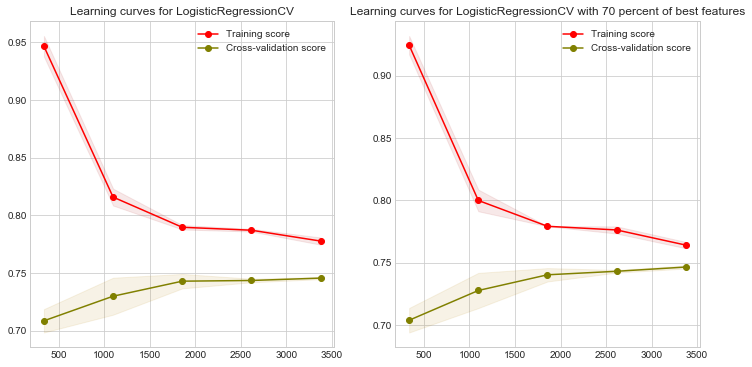

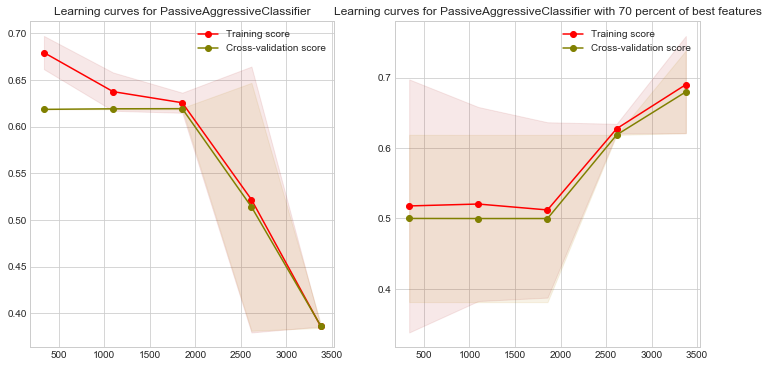

In [133]:
modelize(generalized_linear_model2,d2v_vecs,y_cora_train,d2v_test,y_cora_test) 

Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.636566                   0.513334           /    0.631088                   0.501373
Test     :       0.640415                   0.511877           /    0.635579                   0.501223
Model : NuSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.735011                   0.705314           /    0.735751                   0.707175
Test     :       0.727116                   0.690210           /    0.728152                   0.694029
CPU times: user 1min 42s, sys: 1.54 s, total: 1min 43s
Wall time: 3min 18s


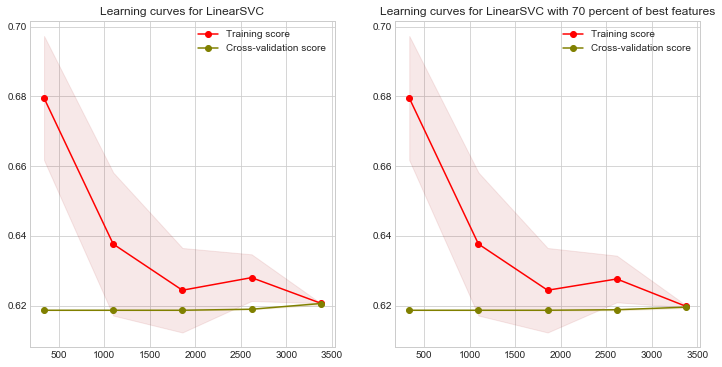

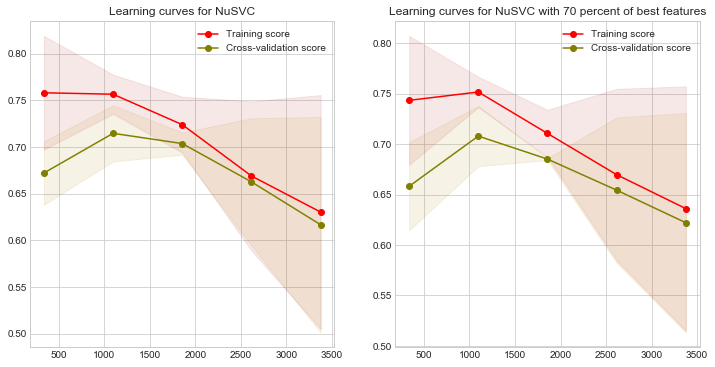

In [134]:
%%time
modelize(support_vector_machines2,d2v_vecs,y_cora_train,d2v_test,y_cora_test)

Model : RandomForestClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.986084                   0.986038           /    0.985344                   0.985299
Test     :       0.710190                   0.671315           /    0.722971                   0.688682
Model : ExtraTreesClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       1.000000                   1.000000           /    1.000000                   1.000000
Test     :       0.697064                   0.644244           /    0.704663                   0.657694


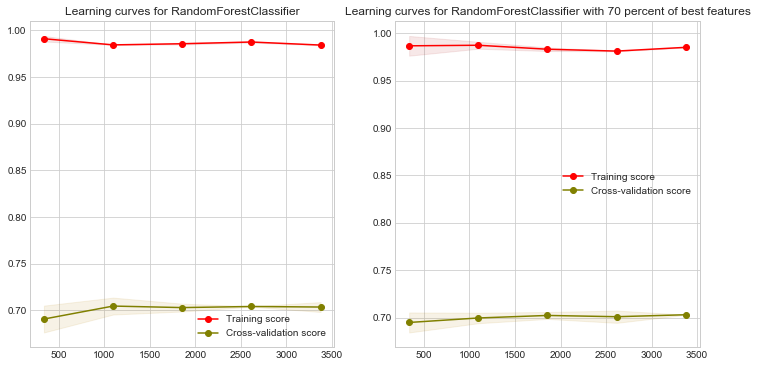

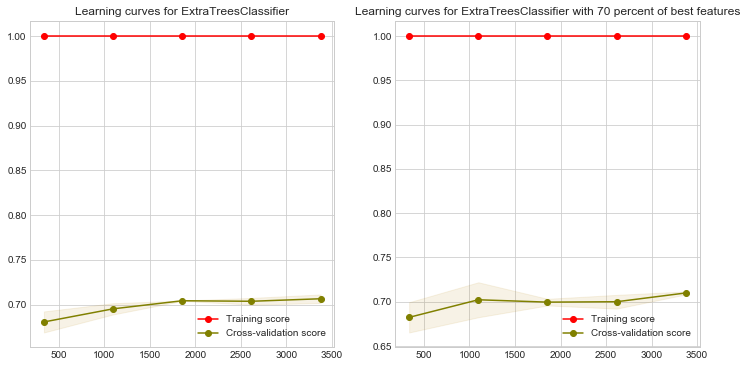

In [135]:
modelize(ensemble_methods2,d2v_vecs,y_cora_train,d2v_test,y_cora_test)

Model : MLPClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.783420                   0.777993           /    0.772761                   0.765047
Test     :       0.731606                   0.723255           /    0.731952                   0.719860


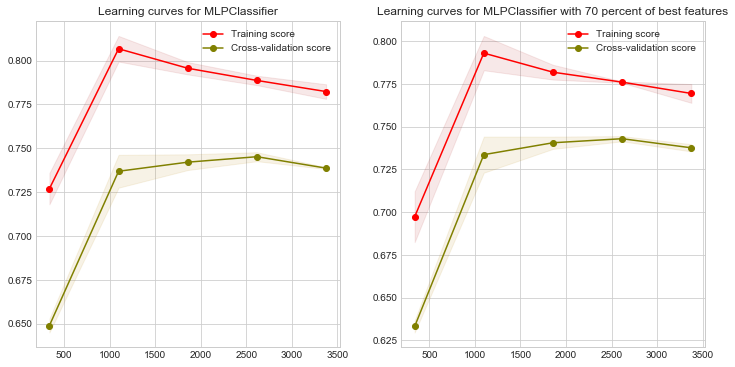

In [136]:
modelize(Neural_network,d2v_vecs,y_cora_train,d2v_test,y_cora_test)

Model : DecisionTreeClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       1.000000                   1.000000           /    1.000000                   1.000000
Test     :       0.676339                   0.665128           /    0.674266                   0.664465
Model : AdaBoostClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.769356                   0.762757           /    0.773501                   0.767145
Test     :       0.723316                   0.691609           /    0.719516                   0.688569
Model : GradientBoostingClassifier
With all features                                              /    With 70% of the bes

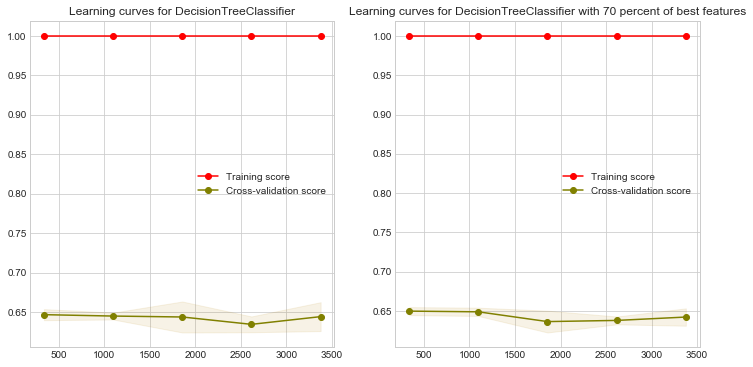

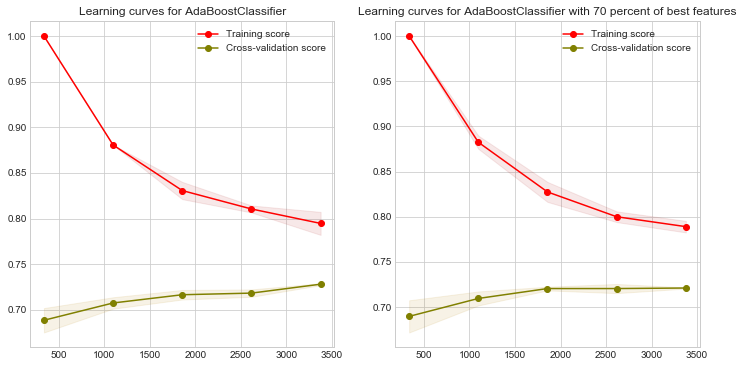

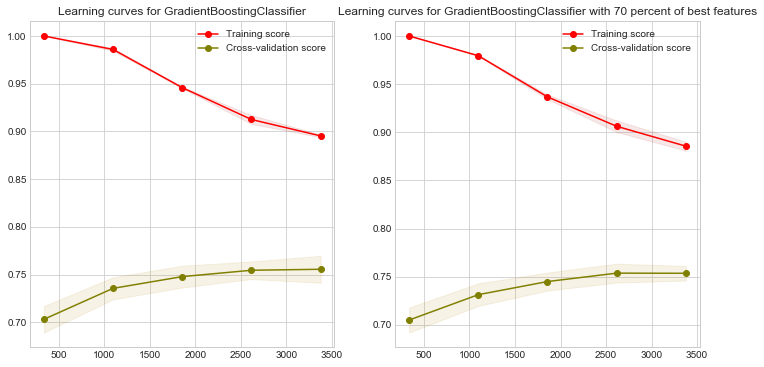

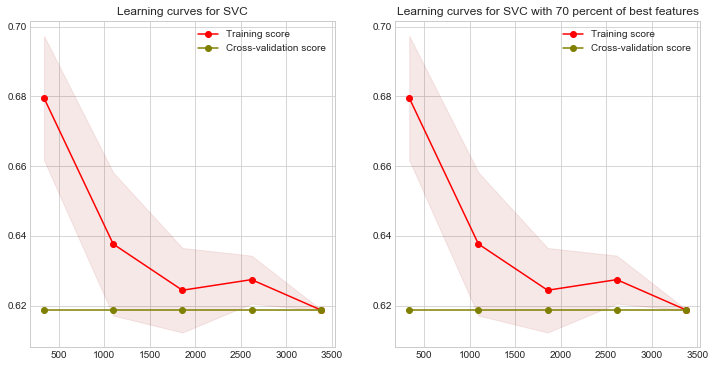

In [137]:
modelize([DecisionTreeClassifier,AdaBoostClassifier,GradientBoostingClassifier, SVC],d2v_vecs,y_cora_train,d2v_test,y_cora_test)

In [138]:
models_df =pd.concat([pd.DataFrame(data),df_models],ignore_index=True)  
#models_df.sort_values(by=['Accuracy','Models','Sample'], ascending=False, axis=0, inplace=True)
#test_df = pd.DataFrame(np.array(models_df[['Accuracy', 'Accuracy with 70% best features']]),
#                       index=[models_df['Models'],models_df['Sample']], columns=['Accuracy', 'Accuracy with 70% best features'])
test_df1=pd.merge(models_df[models_df['Sample']=='Test'],models_df[models_df['Sample']=='Training'],how='inner',on='Models')
test_df1.sort_values(by=['Accuracy_x'], ascending=False, axis=0, inplace=True)
final_model2 = pd.DataFrame( np.array(test_df1[['Sample_y','Accuracy_y', 'Accuracy with 70% best features_y','Sample_x','Accuracy_x', 'Accuracy with 70% best features_x']]),
            index=test_df1['Models'], columns=['','Accuracy', 'Accuracy with 70% best features','','Accuracy', 'Accuracy with 70% best features'])

final_model2.rename(index=str,columns={'Unnamed: 1':'','Unnamed: 4':'', 'Accuracy.1':'Accuracy', 'Accuracy with 70% best features.1':'Accuracy with 70% best features'},inplace=True)
final_model2.to_csv('models_stemmisatonDo2vec.csv')
final_model2

Accuracy  \
Models                                            
LogisticRegressionCV         Training  0.770836   
MLPClassifier                Training   0.78342   
GradientBoostingClassifier   Training  0.836862   
NuSVC                        Training  0.735011   
AdaBoostClassifier           Training  0.769356   
RandomForestClassifier       Training  0.986084   
ExtraTreesClassifier         Training         1   
DecisionTreeClassifier       Training         1   
PassiveAggressiveClassifier  Training  0.669282   
LinearSVC                    Training  0.636566   
SVC                          Training  0.618653   

                            Accuracy with 70% best features        Accuracy  \
Models                                                                        
LogisticRegressionCV                               0.760326  Test  0.731952   
MLPClassifier                                      0.772761  Test  0.731606   
GradientBoostingClassifier                         0.835825  Test  0.728843   
NuSVC                                              0.735751  Test  0.727116   
AdaBoostClassifier                                 0.773501  Test  0.723316   
RandomForestClassifier                             0.985344  Test   0.71019   
ExtraTreesClassifier                                      1  Test  0.697064   
DecisionTreeClassifier                                    1  Test  0.676339   
PassiveAggressiveClassifier                        0.705551  Test  0.665976   
LinearSVC                                          0.631088  Test  0.640415   
SVC                                                0.618653  Test  0.629016   

                            Accuracy with 70% best features  
Models                                                       
LogisticRegressionCV                               0.729879  
MLPClassifier                                      0.731952  
GradientBoostingClassifier                         0.734024  
NuSVC                                              0.728152  
AdaBoostClassifier                                 0.719516  
RandomForestClassifier                             0.722971  
ExtraTreesClassifier                               0.704663  
DecisionTreeClassifier                             0.674266  
PassiveAggressiveClassifier                        0.705009  
LinearSVC                                          0.635579  
SVC                                                0.629016

Add some ML algo from Keras and Tensorflow

#### **2.1 MODELISATION AVEC Doc2Vec A PARTIR DES DONNEES SOUMISES A LA LEMMATISATION**

In [139]:
df_models = pd.DataFrame({'Models':[], 'Sample':[], 'Accuracy':[],'Accuracy with 70% best features':[]})
data=[]

In [140]:
def modelize(list_clf,X,y,X_test,y_test):
    selector = SelectPercentile(mutual_info_classif,percentile=70)
    for clf in list_clf:
        Clf1 = clf().fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf())]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=2 , test_size=.3, random_state=51)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted'),accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Training', 'Accuracy':accuracy_score(y,Clf1.predict(X)),'Accuracy with 70% best features':accuracy_score(y,Clf2.predict(X)) })
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Test', 'Accuracy':accuracy_score(y_test,Clf1.predict(X_test)),'Accuracy with 70% best features':accuracy_score(y_test,Clf2.predict(X_test)) })
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')

Model : LogisticRegressionCV
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.770836                   0.761603           /    0.760326                   0.749317
Test     :       0.731952                   0.718306           /    0.729879                   0.714229
Model : PassiveAggressiveClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.659808                   0.563456           /    0.648705                   0.540042
Test     :       0.659067                   0.554787           /    0.652159                   0.538887


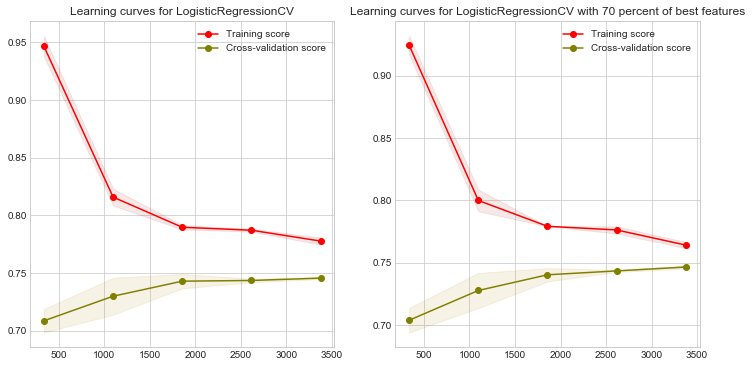

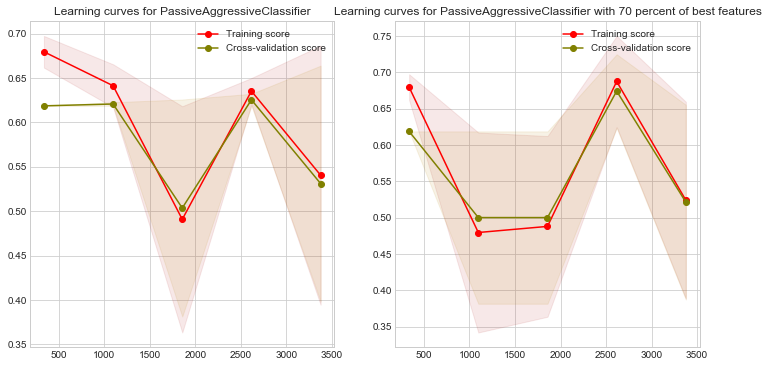

In [141]:
modelize(generalized_linear_model2,d2v_vecs,y_cora_train,d2v_test,y_cora_test) 

Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.636566                   0.513334           /    0.631088                   0.501373
Test     :       0.640415                   0.511877           /    0.635579                   0.501223
Model : NuSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.735011                   0.705314           /    0.735751                   0.707175
Test     :       0.727116                   0.690210           /    0.728152                   0.694029


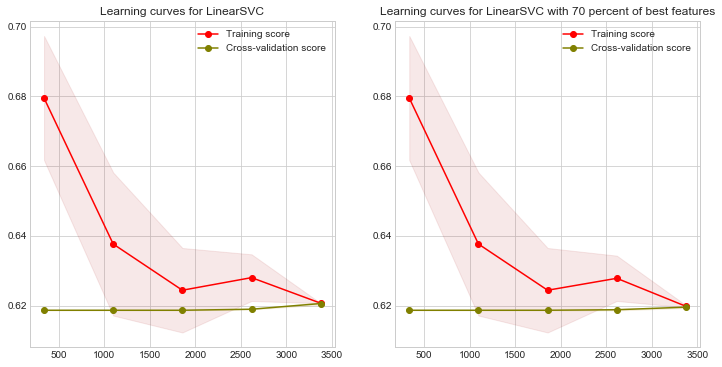

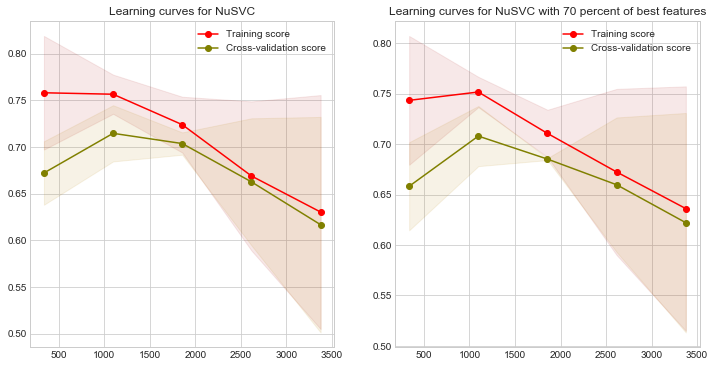

In [142]:
modelize(support_vector_machines2,d2v_vecs,y_cora_train,d2v_test,y_cora_test)

Model : RandomForestClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.985640                   0.985594           /    0.985936                   0.985890
Test     :       0.716408                   0.681994           /    0.726770                   0.695459
Model : ExtraTreesClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       1.000000                   1.000000           /    1.000000                   1.000000
Test     :       0.707772                   0.660935           /    0.697064                   0.651337


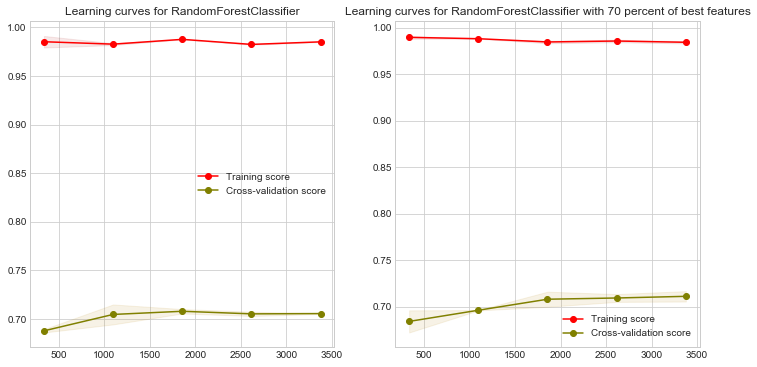

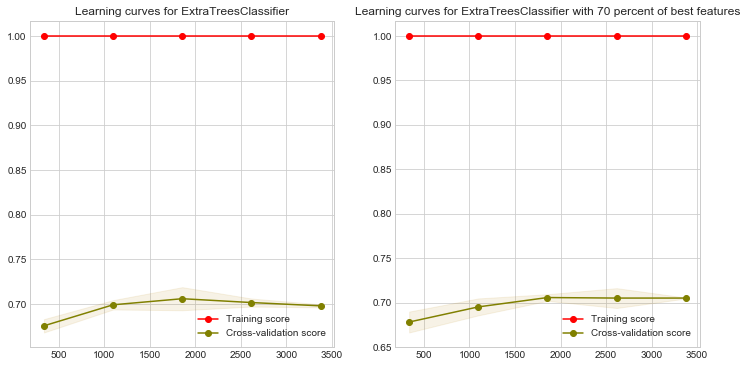

In [143]:
modelize(ensemble_methods2,d2v_vecs,y_cora_train,d2v_test,y_cora_test)

Model : MLPClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.780015                   0.773539           /    0.769948                   0.763649
Test     :       0.732642                   0.722149           /    0.731261                   0.721612


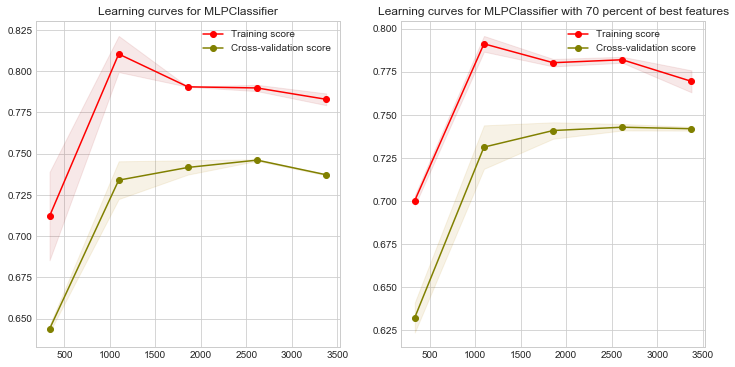

In [144]:
modelize(Neural_network,d2v_vecs,y_cora_train,d2v_test,y_cora_test)

Model : DecisionTreeClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       1.000000                   1.000000           /    1.000000                   1.000000
Test     :       0.677720                   0.666558           /    0.675648                   0.665889
Model : AdaBoostClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.769356                   0.762757           /    0.773501                   0.767145
Test     :       0.723316                   0.691609           /    0.719516                   0.688569
Model : GradientBoostingClassifier
With all features                                              /    With 70% of the bes

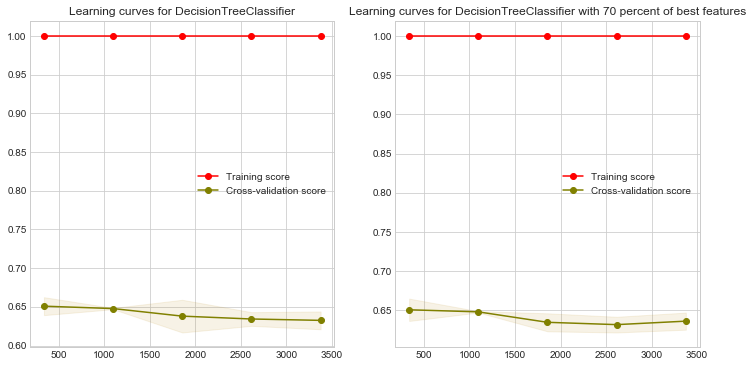

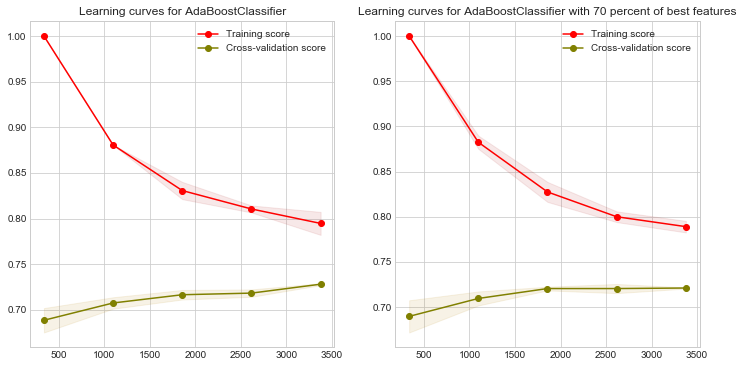

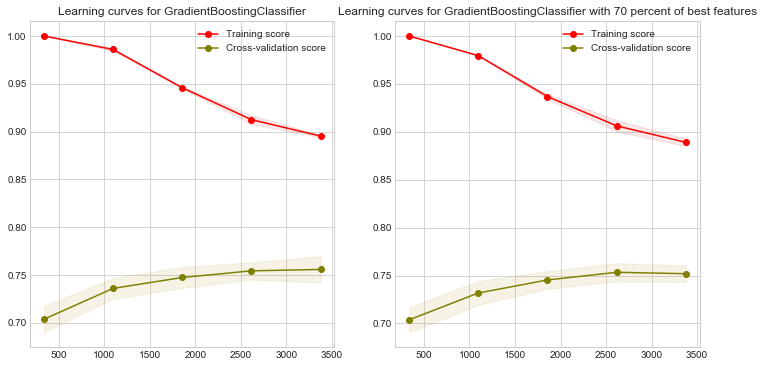

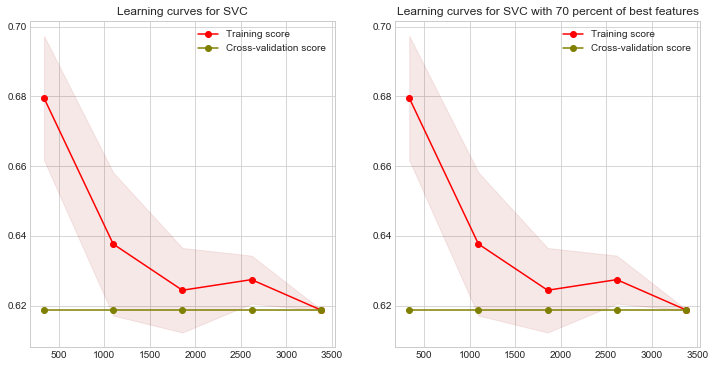

In [145]:
modelize([DecisionTreeClassifier,AdaBoostClassifier,GradientBoostingClassifier, SVC],d2v_vecs,y_cora_train,d2v_test,y_cora_test)

In [146]:
models_df =pd.concat([pd.DataFrame(data),df_models],ignore_index=True)  
#models_df.sort_values(by=['Accuracy','Models','Sample'], ascending=False, axis=0, inplace=True)
#test_df = pd.DataFrame(np.array(models_df[['Accuracy', 'Accuracy with 70% best features']]),
#                       index=[models_df['Models'],models_df['Sample']], columns=['Accuracy', 'Accuracy with 70% best features'])
test_df1=pd.merge(models_df[models_df['Sample']=='Test'],models_df[models_df['Sample']=='Training'],how='inner',on='Models')
test_df1.sort_values(by=['Accuracy_x'], ascending=False, axis=0, inplace=True)
final_model2 = pd.DataFrame( np.array(test_df1[['Sample_y','Accuracy_y', 'Accuracy with 70% best features_y','Sample_x','Accuracy_x', 'Accuracy with 70% best features_x']]),
            index=test_df1['Models'], columns=['','Accuracy', 'Accuracy with 70% best features','','Accuracy', 'Accuracy with 70% best features'])

final_model2.rename(index=str,columns={'Unnamed: 1':'','Unnamed: 4':'', 'Accuracy.1':'Accuracy', 'Accuracy with 70% best features.1':'Accuracy with 70% best features'},inplace=True)
final_model2.to_csv('models_stemmisatonDo2vec.csv')
final_model2

Accuracy  \
Models                                            
MLPClassifier                Training  0.780015   
LogisticRegressionCV         Training  0.770836   
GradientBoostingClassifier   Training  0.836862   
NuSVC                        Training  0.735011   
AdaBoostClassifier           Training  0.769356   
RandomForestClassifier       Training   0.98564   
ExtraTreesClassifier         Training         1   
DecisionTreeClassifier       Training         1   
PassiveAggressiveClassifier  Training  0.659808   
LinearSVC                    Training  0.636566   
SVC                          Training  0.618653   

                            Accuracy with 70% best features        Accuracy  \
Models                                                                        
MLPClassifier                                      0.769948  Test  0.732642   
LogisticRegressionCV                               0.760326  Test  0.731952   
GradientBoostingClassifier                         0.835825  Test  0.728843   
NuSVC                                              0.735751  Test  0.727116   
AdaBoostClassifier                                 0.773501  Test  0.723316   
RandomForestClassifier                             0.985936  Test  0.716408   
ExtraTreesClassifier                                      1  Test  0.707772   
DecisionTreeClassifier                                    1  Test   0.67772   
PassiveAggressiveClassifier                        0.648705  Test  0.659067   
LinearSVC                                          0.631088  Test  0.640415   
SVC                                                0.618653  Test  0.629016   

                            Accuracy with 70% best features  
Models                                                       
MLPClassifier                                      0.731261  
LogisticRegressionCV                               0.729879  
GradientBoostingClassifier                         0.734024  
NuSVC                                              0.728152  
AdaBoostClassifier                                 0.719516  
RandomForestClassifier                              0.72677  
ExtraTreesClassifier                               0.697064  
DecisionTreeClassifier                             0.675648  
PassiveAggressiveClassifier                        0.652159  
LinearSVC                                          0.635579  
SVC                                                0.629016

#### **2.1 MODELISATION AVEC Doc2Vec A PARTIR DES DONNEES SOUMISES A LA LEMMATISATION**

In [147]:
df_models = pd.DataFrame({'Models':[], 'Sample':[], 'Accuracy':[],'Accuracy with 70% best features':[]})
data=[]
def modelize(list_clf,X,y,X_test,y_test):
    selector = SelectPercentile(mutual_info_classif,percentile=70)
    for clf in list_clf:
        Clf1 = clf().fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf())]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=2 , test_size=.3, random_state=51)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted'),accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Training', 'Accuracy':accuracy_score(y,Clf1.predict(X)),'Accuracy with 70% best features':accuracy_score(y,Clf2.predict(X)) })
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Test', 'Accuracy':accuracy_score(y_test,Clf1.predict(X_test)),'Accuracy with 70% best features':accuracy_score(y_test,Clf2.predict(X_test)) })
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')

Model : LogisticRegressionCV
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.736788                   0.715664           /    0.730274                   0.707020
Test     :       0.717789                   0.688711           /    0.709499                   0.676784
Model : PassiveAggressiveClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.724648                   0.693639           /    0.655811                   0.555789
Test     :       0.711226                   0.670001           /    0.652159                   0.538887


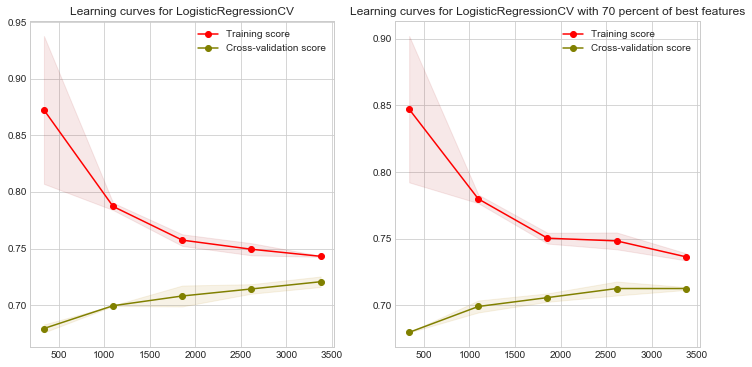

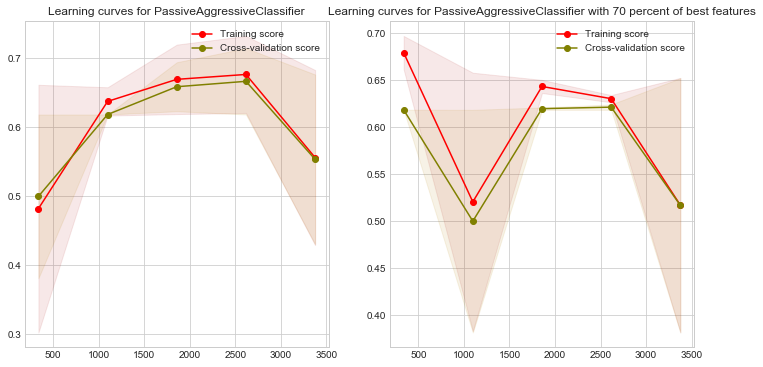

In [148]:
modelize(generalized_linear_model2,d2v_vecs_bigram,y_cora_train,d2v_test_bigram,y_cora_test) 

Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.640415                   0.522741           /    0.635085                   0.510657
Test     :       0.644560                   0.520833           /    0.640760                   0.512630
Model : NuSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.716210                   0.677215           /    0.719319                   0.681406
Test     :       0.708808                   0.657264           /    0.703627                   0.653115


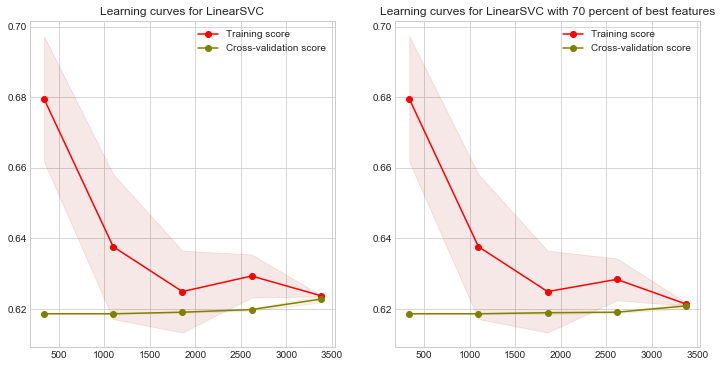

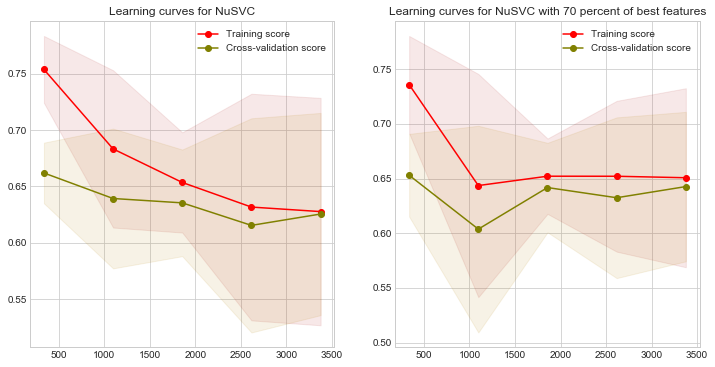

In [149]:
modelize(support_vector_machines2,d2v_vecs_bigram,y_cora_train,d2v_test_bigram,y_cora_test)

Model : RandomForestClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.983864                   0.983803           /    0.984752                   0.984694
Test     :       0.696718                   0.654572           /    0.708808                   0.671016
Model : ExtraTreesClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       1.000000                   1.000000           /    1.000000                   1.000000
Test     :       0.697064                   0.642082           /    0.687392                   0.628066


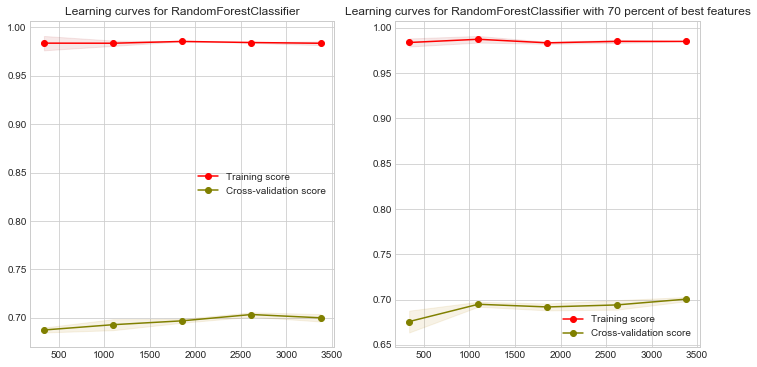

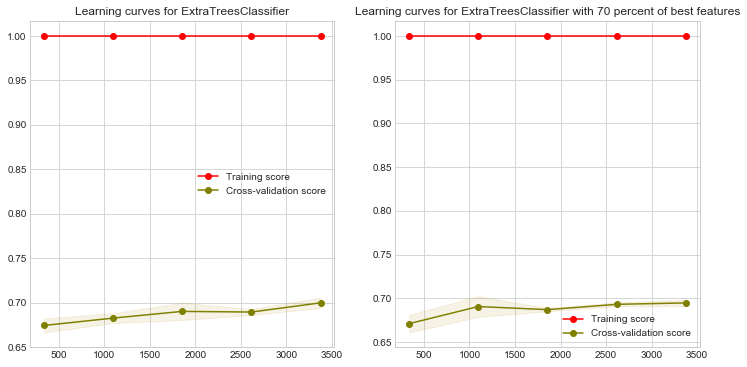

In [150]:
modelize(ensemble_methods2,d2v_vecs_bigram,y_cora_train,d2v_test_bigram,y_cora_test)

Model : MLPClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.757957                   0.749882           /    0.746410                   0.735143
Test     :       0.711572                   0.698964           /    0.717098                   0.699334


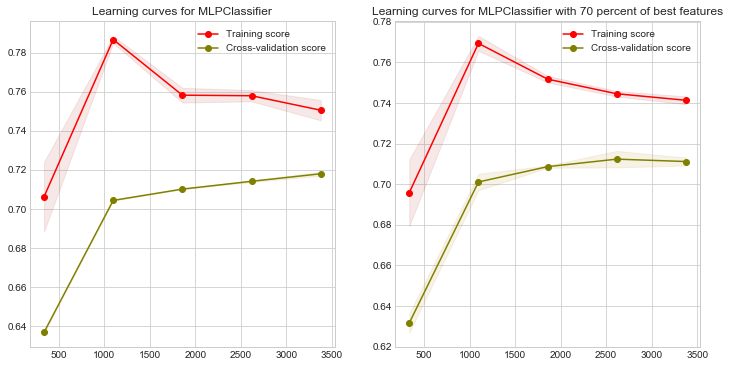

In [151]:
modelize(Neural_network,d2v_vecs_bigram,y_cora_train,d2v_test_bigram,y_cora_test)

In [152]:
models_df =pd.concat([pd.DataFrame(data),df_models],ignore_index=True)  
#models_df.sort_values(by=['Accuracy','Models','Sample'], ascending=False, axis=0, inplace=True)
#test_df = pd.DataFrame(np.array(models_df[['Accuracy', 'Accuracy with 70% best features']]),
#                       index=[models_df['Models'],models_df['Sample']], columns=['Accuracy', 'Accuracy with 70% best features'])
test_df1=pd.merge(models_df[models_df['Sample']=='Test'],models_df[models_df['Sample']=='Training'],how='inner',on='Models')
test_df1.sort_values(by=['Accuracy_x'], ascending=False, axis=0, inplace=True)
final_model2 = pd.DataFrame( np.array(test_df1[['Sample_y','Accuracy_y', 'Accuracy with 70% best features_y','Sample_x','Accuracy_x', 'Accuracy with 70% best features_x']]),
            index=test_df1['Models'], columns=['','Accuracy', 'Accuracy with 70% best features','','Accuracy', 'Accuracy with 70% best features'])

final_model2.rename(index=str,columns={'Unnamed: 1':'','Unnamed: 4':'', 'Accuracy.1':'Accuracy', 'Accuracy with 70% best features.1':'Accuracy with 70% best features'},inplace=True)
final_model2.to_csv('models_lemmATISatIonDo2vec.csv')
final_model2

Accuracy  \
Models                                            
LogisticRegressionCV         Training  0.736788   
MLPClassifier                Training  0.757957   
PassiveAggressiveClassifier  Training  0.724648   
NuSVC                        Training   0.71621   
ExtraTreesClassifier         Training         1   
RandomForestClassifier       Training  0.983864   
LinearSVC                    Training  0.640415   

                            Accuracy with 70% best features        Accuracy  \
Models                                                                        
LogisticRegressionCV                               0.730274  Test  0.717789   
MLPClassifier                                       0.74641  Test  0.711572   
PassiveAggressiveClassifier                        0.655811  Test  0.711226   
NuSVC                                              0.719319  Test  0.708808   
ExtraTreesClassifier                                      1  Test  0.697064   
RandomForestClassifier                             0.984752  Test  0.696718   
LinearSVC                                          0.635085  Test   0.64456   

                            Accuracy with 70% best features  
Models                                                       
LogisticRegressionCV                               0.709499  
MLPClassifier                                      0.717098  
PassiveAggressiveClassifier                        0.652159  
NuSVC                                              0.703627  
ExtraTreesClassifier                               0.687392  
RandomForestClassifier                             0.708808  
LinearSVC                                           0.64076

### HYPERPARAMETERS TUNING
Nos meilleurs modèles sont les suivants:
    - LinearSVC appliqué avec une matrice Tf-Idf de données stemmisées en n_grams(1,3)
    - LogisticRegression avec une matrice Tf-Idf de données stemmisées en n_grams(1,4)
    - ExtraTreeClassifier avec une matrice Tf-Idf de données stemmisées en n_grams(1,4)
    - MLPClassifier vec une matrice Tf-Idf de données stemmisées en n_grams(1,4)
    
Nous appliquerons deux méthodes d'optimisation d'hyperparametre afin d'en comparer les resultats : GridSearchCV et HyperOpt    


In [153]:
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold
from sklearn.feature_selection import SelectPercentile
from hyperopt import hp,fmin,Trials, tpe, STATUS_FAIL, STATUS_OK, space_eval, anneal
from hyperopt.pyll import scope
from hyperopt.pyll import stochastic

from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import normalize, StandardScaler

import time
random_state = 42
kf = KFold(n_splits=2,random_state=random_state)
n_iter= 50


**1. ExtraTreeClassifier Hyperparameters Tuning**

In [154]:
#Parameters Optimization with HyperOpt 
#Tree-structure Parzen Estimator: TPE is a default algorithm for the Hyperopt. It uses Bayesian approach for optimization. 
#At every step it is trying to build probabilistic model of the function and choose the most promising parameters for the next step.
#1. We need to create a function to minimize.
def extraTree_accuracy_cv(params, random_state=random_state, cv=kf, X=X_t3gram_vectorizer_train, y=y_cora_train):
    # the function gets a set of variable parameters in "param"
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']),  #The number of trees in the forest.
              'max_features': str(params['max_features']), #The number of features to consider when looking for the best split.
              'min_samples_split': int(params['min_samples_split']), #The minimum number of samples required to split an internal node
              'max_depth': int(params['max_depth'])} #The maximum depth of the tree
    # we use this params to create a new LinearSVC Classifier
    model = ExtraTreesClassifier(random_state=random_state, **params, n_jobs = -1)
    # and then conduct the cross validation with the same folds as before
    try:
        return {'loss' : -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean(),
                'time' : time.time(),
                'status' : STATUS_OK }
    except (Exception, e):
        return {'status' : STATUS_FAIL,
                'time' : time.time(),
                'exception' : str(e)}

In [155]:
%%time
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 80, 1),
       'max_features': hp.choice('max_features', ["sqrt","log2"]),
       'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1)  
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=extraTree_accuracy_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )
# computing the score on the test set
model = ExtraTreesClassifier(random_state=random_state, 
                             n_estimators=int(best['n_estimators']), 
                             max_depth=int(best['max_depth']),
                             min_samples_split= int(space_eval(space,best)['min_samples_split']),
                             max_features=str(space_eval(space,best)['max_features']),
                             n_jobs=-1)
model.fit(X_t3gram_vectorizer_train,y_cora_train)
tpe_test_score=accuracy_score(y_cora_test, model.predict(X_t3gram_vectorizer_test))

CPU times: user 14.5 s, sys: 587 ms, total: 15.1 s
Wall time: 4min 26s


In [156]:
print(stochastic.sample(space))

{'max_depth': 38.0, 'max_features': 'sqrt', 'min_samples_split': 3.0, 'n_estimators': 1687.0}


In [157]:
print("Best Accuracy score on train set {:.3f} params {}".format( -extraTree_accuracy_cv(space_eval(space,best))['loss'], space_eval(space,best)))
print('Accuracy score on validation sample {:.3f}'.format(tpe_test_score))

Best Accuracy score on train set 0.815 params {'max_depth': 80.0, 'max_features': 'sqrt', 'min_samples_split': 5.0, 'n_estimators': 645.0}
Accuracy score on validation sample 0.828


In [158]:
print("Best Accuracy score on train set {:.3f} params {}".format( -extraTree_accuracy_cv(space_eval(space,best))['loss'], space_eval(space,best)))
print('Accuracy score on validation sample {:.3f}'.format(tpe_test_score))

Best Accuracy score on train set 0.815 params {'max_depth': 80.0, 'max_features': 'sqrt', 'min_samples_split': 5.0, 'n_estimators': 645.0}
Accuracy score on validation sample 0.828


In [159]:
#extraTree_accuracy_cv(best), 
space_eval(space,best)

{'max_depth': 80.0,
 'max_features': 'sqrt',
 'min_samples_split': 5.0,
 'n_estimators': 645.0}

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a60943668>,
      dtype=object)

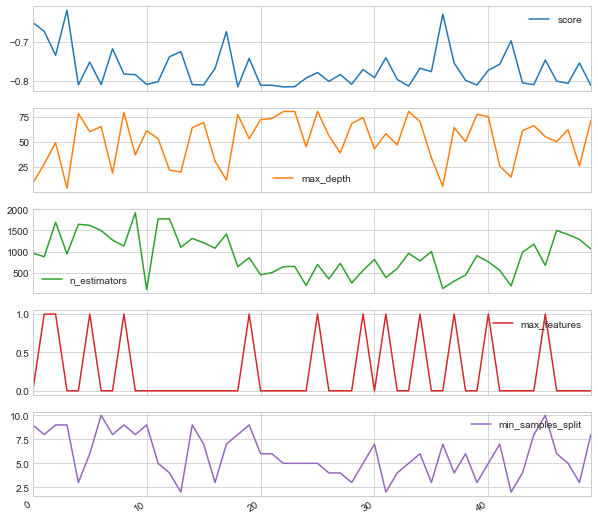

In [160]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['max_features'][0],
                      x['misc']['vals']['min_samples_split'][0]
                      
                      
                      ] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators', 'max_features', 'min_samples_split'])
tpe_results_df.plot(subplots=True,figsize=(10, 10))

Model : ExtraTreesClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.932791                   0.931333           /    0.930570                   0.929060
Test     :       0.827634                   0.823022           /    0.821762                   0.816550
CPU times: user 30 s, sys: 1.17 s, total: 31.1 s
Wall time: 59.6 s


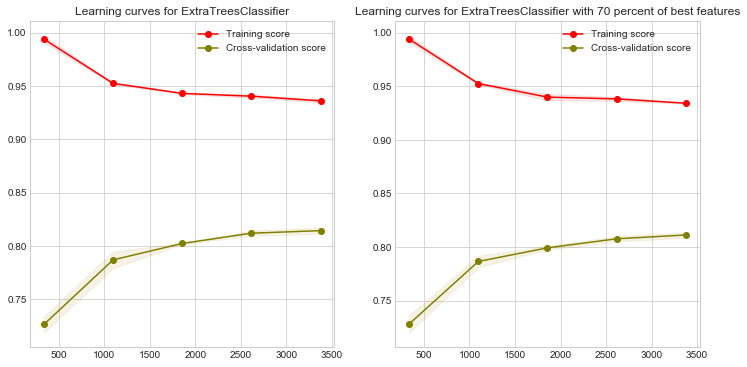

In [161]:
%%time
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=70)
def modelize(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Clf1 = clf(random_state=random_state, n_estimators=int(best['n_estimators']), max_depth=int(best['max_depth']), min_samples_split= int(space_eval(space,best)['min_samples_split']),
                             max_features=str(space_eval(space,best)['max_features']), n_jobs=-1).fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(random_state=random_state, n_estimators=int(best['n_estimators']), max_depth=int(best['max_depth']), min_samples_split= int(space_eval(space,best)['min_samples_split']),
                             max_features=str(space_eval(space,best)['max_features']), n_jobs=-1))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=random_state)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')
    
modelize([ExtraTreesClassifier],X_t3gram_vectorizer_train,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

In [162]:
#Parameters Optimization with HyperOpt 
#Tree-structure Parzen Estimator: TPE is a default algorithm for the Hyperopt. It uses Bayesian approach for optimization. 
#At every step it is trying to build probabilistic model of the function and choose the most promising parameters for the next step.
#1. We need to create a function to minimize.
def RF_cv(params, random_state=random_state, cv=kf, X=X_t3gram_vectorizer_train, y=y_cora_train):
    # the function gets a set of variable parameters in "param"
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']),  #The number of trees in the forest.
              'max_features': str(params['max_features']), #The number of features to consider when looking for the best split.
              'min_samples_split': int(params['min_samples_split']), #The minimum number of samples required to split an internal node
              'max_depth': int(params['max_depth'])} #The maximum depth of the tree
    # we use this params to create a new LinearSVC Classifier
    model = RandomForestClassifier(random_state=random_state, **params, n_jobs = -1)
    # and then conduct the cross validation with the same folds as before
    try:
        return {'loss' : -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean(),
                'time' : time.time(),
                'status' : STATUS_OK }
    except (Exception, e):
        return {'status' : STATUS_FAIL,
                'time' : time.time(),
                'exception' : str(e)}

In [163]:
%%time
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 20, 500, 1),
       'max_depth' : hp.quniform('max_depth', 2, 100, 1),
       'max_features': hp.choice('max_features', ["sqrt","log2"]),
       'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1)  
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=RF_cv, # function to optimize
          space=space, 
          algo=anneal.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )
# computing the score on the test set
model = RandomForestClassifier(random_state=random_state, 
                             n_estimators=int(best['n_estimators']),
                             #n_estimators= 302,  
                             max_depth=int(best['max_depth']),
                             min_samples_split= int(space_eval(space,best)['min_samples_split']),
                             max_features=str(space_eval(space,best)['max_features']),
                             n_jobs=-1)
model.fit(X_t3gram_vectorizer_train,y_cora_train)
tpe_test_score=accuracy_score(y_cora_test, model.predict(X_t3gram_vectorizer_test))

CPU times: user 1.2 s, sys: 95.8 ms, total: 1.3 s
Wall time: 43.7 s


In [164]:
hp.quniform('n_estimators', 20, 500, 50)

In [165]:
print("Best Accuracy score on train set {:.3f} params {}".format( -RF_cv(space_eval(space,best))['loss'], space_eval(space,best)))
print('Accuracy score on validation sample {:.3f}'.format(tpe_test_score))

Best Accuracy score on train set 0.815 params {'max_depth': 100.0, 'max_features': 'sqrt', 'min_samples_split': 6.0, 'n_estimators': 50.0}
Accuracy score on validation sample 0.821


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5aec9a90>,
      dtype=object)

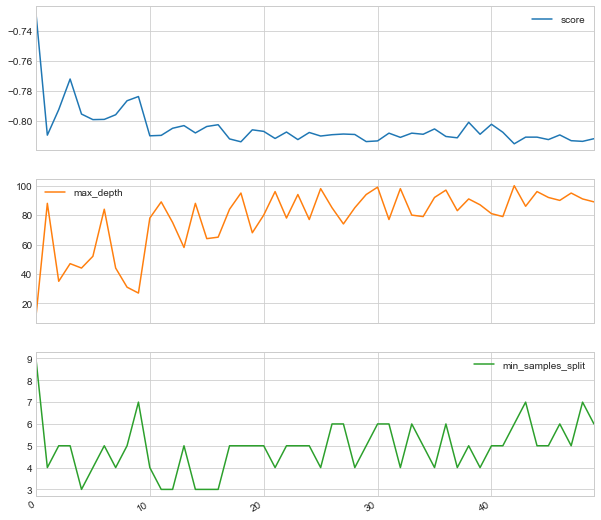

In [166]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      #x['misc']['vals']['n_estimators'][0],
                     # x['misc']['vals']['max_features'][0],
                      x['misc']['vals']['min_samples_split'][0]
                      
                      
                      ] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', #'n_estimators',# 'max_features', 
                                    'min_samples_split'])
tpe_results_df.plot(subplots=True,figsize=(10, 10))

Model : RandomForestClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.945522                   0.944644           /    0.947742                   0.946944
Test     :       0.816580                   0.813708           /    0.814853                   0.811135
CPU times: user 16.3 s, sys: 431 ms, total: 16.8 s
Wall time: 25.8 s


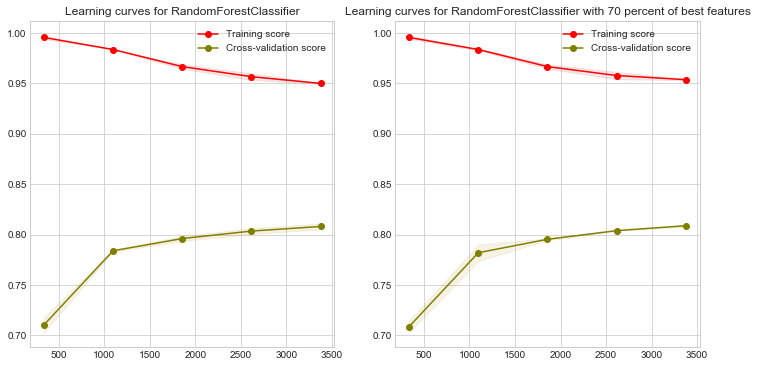

In [167]:
%%time
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=70)
def modelize(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        #Clf1 = clf(random_state=random_state, n_estimators=int(best['n_estimators']), max_depth=int(best['max_depth']), min_samples_split= int(space_eval(space,best)['min_samples_split']),
        #                     max_features=str(space_eval(space,best)['max_features']), n_jobs=-1).fit(X,y)
        #Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(random_state=random_state, n_estimators=int(best['n_estimators']), max_depth=int(best['max_depth']), min_samples_split= int(space_eval(space,best)['min_samples_split']),
        #                     max_features=str(space_eval(space,best)['max_features']), n_jobs=-1))]).fit(X,y)
        Clf1 = clf(random_state=random_state, n_estimators=302, max_depth=96, n_jobs=-1).fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(random_state=random_state, n_estimators=302, max_depth=96,n_jobs=-1) )]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=random_state)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')
    
modelize([RandomForestClassifier],X_t3gram_vectorizer_train,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

In [168]:
from sklearn.model_selection import validation_curve
from matplotlib import pyplot as plt

def plot_validation_curve(estimator, X, y, param_name, param_range,
                          ylim=(0, 1.1), cv=5, n_jobs=-1, scoring=None):
    estimator_name = type(estimator).__name__
    plt.figure(figsize=(10,6))
    plt.title("Validation curves for %s on %s"
              % (param_name, estimator_name))
    plt.grid()
    plt.xlim(min(param_range), max(param_range))
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.xscale('log')
    
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name, param_range,
        cv=cv, n_jobs=n_jobs, scoring=scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.plot(
        param_range, train_scores_mean, 'o-',
        color="firebrick", linewidth=3, 
        label="Training score")
    plt.plot(
        param_range, test_scores_mean, 'o-',
        color="darkgoldenrod", 
        label="Cross-validation score")
    plt.fill_between(
        param_range, train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, alpha=0.1,
        color="firebrick")
    plt.fill_between(
        param_range, test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, alpha=0.1, color="darkgoldenrod")
    plt.legend(loc="best")



[   1  108  215  322  429  536  643  750  857  964 1071 1178 1285 1392
 1500]
CPU times: user 518 ms, sys: 63.9 ms, total: 582 ms
Wall time: 23.2 s


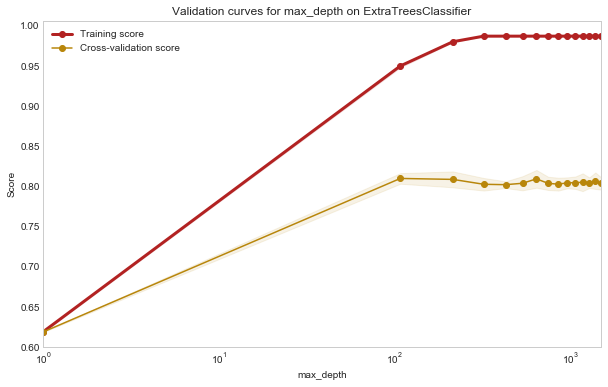

In [169]:
%%time
%matplotlib inline
cv = StratifiedShuffleSplit(n_splits=10 #nombre de fois qu'on regenere le train test
                            , train_size=.8, random_state=random_state)

clf = ExtraTreesClassifier(n_jobs=-1)
param_name = 'max_depth'
param_range = np.linspace(1,1500,15,dtype=int)
print(param_range)
plot_validation_curve(
    clf, X_t3gram_vectorizer_train, y_cora_train, param_name, param_range, cv=cv.split(X_t3gram_vectorizer_train, y_cora_train), scoring='accuracy')

In [170]:
param_range

array([   1,  108,  215,  322,  429,  536,  643,  750,  857,  964, 1071,
       1178, 1285, 1392, 1500])

[  1  56 111 167 222 278 333 389 444 500]
CPU times: user 57.9 ms, sys: 6.01 ms, total: 63.9 ms
Wall time: 34.7 s


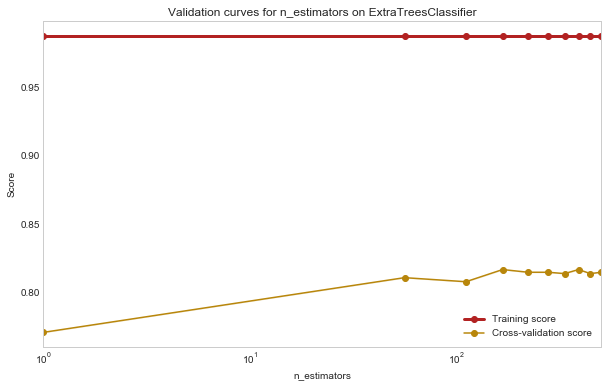

In [171]:
%%time
%matplotlib inline
cv = StratifiedShuffleSplit(n_splits=1 #nombre de fois qu'on regenere le train test
                            , train_size=.7, random_state=random_state)

clf = ExtraTreesClassifier(n_jobs=-1)
param_name = 'n_estimators'
param_range = np.linspace(1,500,10,dtype=int)
print(param_range)
plot_validation_curve(
    clf, X_t3gram_vectorizer_train, y_cora_train, param_name, param_range, cv=cv.split(X_t3gram_vectorizer_train, y_cora_train), scoring='accuracy')

In [172]:
%%time

#Parameters Optimization with HyperOpt 
#Tree-structure Parzen Estimator: TPE is a default algorithm for the Hyperopt. It uses Bayesian approach for optimization. 
#At every step it is trying to build probabilistic model of the function and choose the most promising parameters for the next step.
#1. We need to create a function to minimize.
def ExtraTC_cv(params, random_state=random_state, cv=kf, X=X_t3gram_vectorizer_train, y=y_cora_train):
    # the function gets a set of variable parameters in "param"
    # the function gets a set of variable parameters in "param"
    params = {#'n_estimators': int(params['n_estimators']),  #The number of trees in the forest.
              'max_features': str(params['max_features']), #The number of features to consider when looking for the best split.
              'min_samples_split': int(params['min_samples_split']), #The minimum number of samples required to split an internal node
              'max_depth': int(params['max_depth'])} #The maximum depth of the tree
    # we use this params to create a new LinearSVC Classifier
    model = ExtraTreesClassifier(random_state=random_state, **params, n_jobs = -1, n_estimators=110)
    # and then conduct the cross validation with the same folds as before
    try:
        return {'loss' : -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean(),
                'time' : time.time(),
                'status' : STATUS_OK }
    except (Exception, e):
        return {'status' : STATUS_FAIL,
                'time' : time.time(),
                'exception' : str(e)}
    
# possible values of parameters
space={#'n_estimators': hp.quniform('n_estimators', 80, 180, 1),
       'max_depth' : hp.quniform('max_depth', 215, 430, 1),
       'max_features': hp.choice('max_features', ["sqrt","log2"]),
       'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1)  
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=ExtraTC_cv, # function to optimize
          space=space, 
          algo=anneal.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )
# computing the score on the test set
model = ExtraTreesClassifier(random_state=random_state, 
                             #n_estimators=int(best['n_estimators']),
                             n_estimators= 110,  
                             max_depth=int(best['max_depth']),
                             min_samples_split= int(space_eval(space,best)['min_samples_split']),
                             max_features=str(space_eval(space,best)['max_features']),
                             n_jobs=-1)
model.fit(X_t3gram_vectorizer_train,y_cora_train)
tpe_test_score=accuracy_score(y_cora_test, model.predict(X_t3gram_vectorizer_test))

CPU times: user 2.59 s, sys: 97.7 ms, total: 2.69 s
Wall time: 52.9 s


In [174]:
print("Best Accuracy score on train set {:.3f} params {}".format( -ExtraTC_cv(space_eval(space,best))['loss'], space_eval(space,best)))
print('Accuracy score on validation sample {:.3f}'.format(tpe_test_score))

Best Accuracy score on train set 0.826 params {'max_depth': 281.0, 'max_features': 'log2', 'min_samples_split': 10.0}
Accuracy score on validation sample 0.832


Model : ExtraTreesClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.961954                   0.961682           /    0.959141                   0.958885
Test     :       0.831779                   0.830108           /    0.829706                   0.828464
CPU times: user 8.48 s, sys: 141 ms, total: 8.62 s
Wall time: 10.4 s


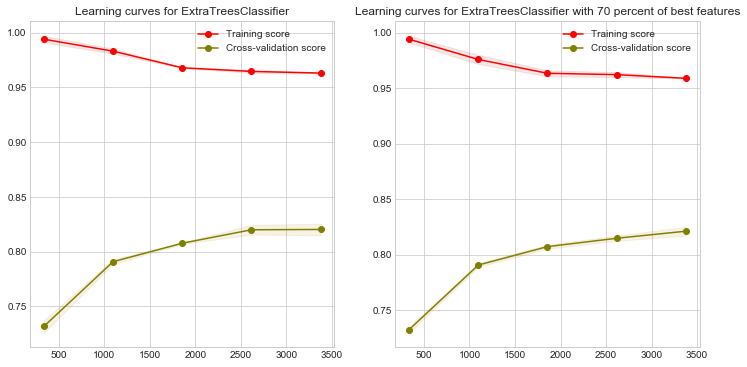

In [175]:
%%time
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=70)
def modelize(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Clf1 = clf(random_state=random_state, n_estimators=110, max_depth=int(best['max_depth']), min_samples_split= int(space_eval(space,best)['min_samples_split']),
                             max_features=str(space_eval(space,best)['max_features']), n_jobs=-1).fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(random_state=random_state, n_estimators=110, max_depth=int(best['max_depth']), min_samples_split= int(space_eval(space,best)['min_samples_split']),
                             max_features=str(space_eval(space,best)['max_features']), n_jobs=-1))]).fit(X,y)
        #Clf1 = clf(random_state=random_state, n_estimators=302, max_depth=96, n_jobs=-1).fit(X,y)
        #Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(random_state=random_state, n_estimators=302, max_depth=96,n_jobs=-1) )]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=random_state)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')
    
modelize([ExtraTreesClassifier],X_t3gram_vectorizer_train,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

[   1  108  215  322  429  536  643  750  857  964 1071 1178 1285 1392
 1500]
CPU times: user 92.2 ms, sys: 72.3 ms, total: 164 ms
Wall time: 8.12 s


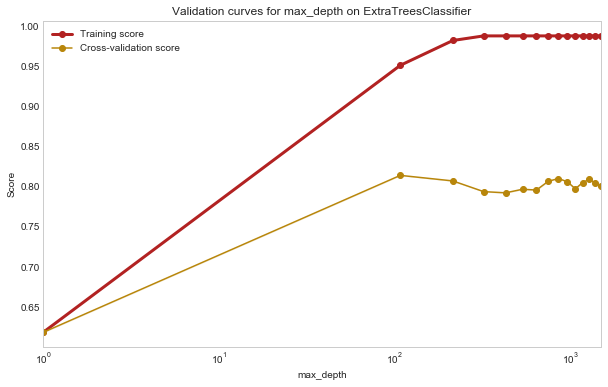

In [192]:
%%time
%matplotlib inline
cv = StratifiedShuffleSplit(n_splits=1 #nombre de fois qu'on regenere le train test
                            , train_size=.7, random_state=random_state)

clf = ExtraTreesClassifier(n_jobs=-1)
param_name = 'max_depth'
param_range = np.linspace(1,1500,15,dtype=int)
print(param_range)
plot_validation_curve(
    clf, X_t3gram_vectorizer_train_, y_cora_train, param_name, param_range, cv=cv.split(X_t3gram_vectorizer_train_, y_cora_train), scoring='accuracy')

[  1 117 234 350 467 583 700]
CPU times: user 56.1 ms, sys: 35.1 ms, total: 91.2 ms
Wall time: 31 s


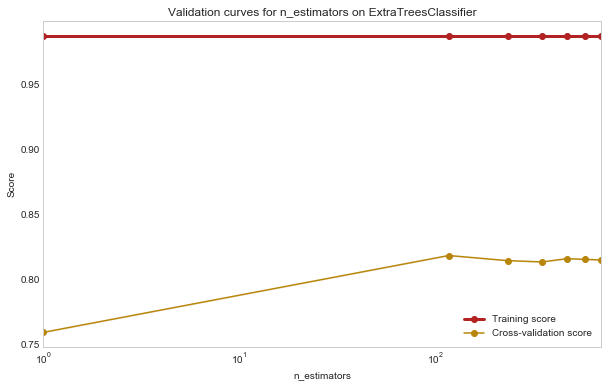

In [193]:
%%time
%matplotlib inline
cv = StratifiedShuffleSplit(n_splits=1 #nombre de fois qu'on regenere le train test
                            , train_size=.7, random_state=random_state)

clf = ExtraTreesClassifier(n_jobs=-1)
param_name = 'n_estimators'
param_range = np.linspace(1,700,7,dtype=int)
print(param_range)
plot_validation_curve(
    clf, X_t3gram_vectorizer_train, y_cora_train, param_name, param_range, cv=cv.split(X_t3gram_vectorizer_train, y_cora_train), scoring='accuracy')

In [195]:
%%time

def ExtraTC_cv(params, random_state=random_state, cv=kf, X=X_t3gram_vectorizer_train, y=y_cora_train):
    # the function gets a set of variable parameters in "param"
    # the function gets a set of variable parameters in "param"
    params = {#'n_estimators': int(params['n_estimators']),  #The number of trees in the forest.
              'max_features': str(params['max_features']), #The number of features to consider when looking for the best split.
              'min_samples_split': int(params['min_samples_split']), #The minimum number of samples required to split an internal node
              'max_depth': int(params['max_depth'])} #The maximum depth of the tree
    # we use this params to create a new LinearSVC Classifier
    model = ExtraTreesClassifier(random_state=random_state, **params, n_jobs = -1, n_estimators=110)
    # and then conduct the cross validation with the same folds as before
    return {'loss' : -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean(),
                'time' : time.time(),
                'status' : STATUS_OK }

    
# possible values of parameters
space={#'n_estimators': hp.quniform('n_estimators', 80, 180, 1),
       'max_depth' : hp.quniform('max_depth', 400, 500, 1),
       'max_features': hp.choice('max_features', ["sqrt","log2"]),
       'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1)  
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=ExtraTC_cv, # function to optimize
          space=space, 
          algo=anneal.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )
# computing the score on the test set
model = ExtraTreesClassifier(random_state=random_state, 
                             #n_estimators=int(best['n_estimators']),
                             n_estimators= 117,  
                             max_depth=int(best['max_depth']),
                             min_samples_split= int(space_eval(space,best)['min_samples_split']),
                             max_features=str(space_eval(space,best)['max_features']),
                             n_jobs=-1)
model.fit(X_t3gram_vectorizer_train_,y_cora_train)

CPU times: user 2.67 s, sys: 104 ms, total: 2.77 s
Wall time: 57.4 s


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=487, max_features='log2', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=10,
                     min_weight_fraction_leaf=0.0, n_estimators=117, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [199]:
print("Best Accuracy score on train set {:.3f} params {}".format( -ExtraTC_cv(space_eval(space,best))['loss'], space_eval(space,best)))
tpe_test_score=accuracy_score(y_cora_test, model.predict(X_t3gram_vectorizer_test))
print('Accuracy score on validation sample {:.3f}'.format(tpe_test_score))
tpe_test_score=balanced_accuracy_score(y_cora_test, model.predict(X_t3gram_vectorizer_test))
print('balanced Accuracy score on validation sample {:.3f}'.format(tpe_test_score))

Best Accuracy score on train set 0.824 params {'max_depth': 487.0, 'max_features': 'log2', 'min_samples_split': 10.0}
Accuracy score on validation sample 0.831
balanced Accuracy score on validation sample 0.816


Model : ExtraTreesClassifier
With all features                                              /    With 70% of the best features
                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score
training :       0.968410                   0.972539           /    0.960686                   0.965264
Test     :       0.816187                   0.830306           /    0.818706                   0.832157
CPU times: user 10.8 s, sys: 214 ms, total: 11 s
Wall time: 13.2 s


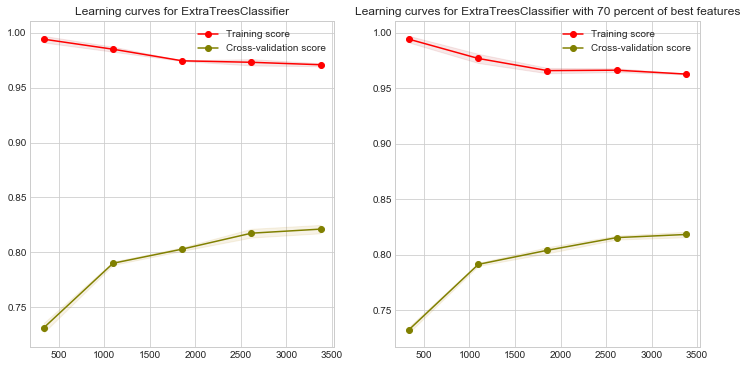

In [200]:
%%time
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=70)
def modelize(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Clf1 = clf(random_state=random_state, n_estimators=117, max_depth=int(best['max_depth']), min_samples_split= int(space_eval(space,best)['min_samples_split']),
                             max_features=str(space_eval(space,best)['max_features']), n_jobs=-1).fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(random_state=random_state, n_estimators=110, max_depth=int(best['max_depth']), min_samples_split= int(space_eval(space,best)['min_samples_split']),
                             max_features=str(space_eval(space,best)['max_features']), n_jobs=-1))]).fit(X,y)
        #Clf1 = clf(random_state=random_state, n_estimators=302, max_depth=96, n_jobs=-1).fit(X,y)
        #Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(random_state=random_state, n_estimators=302, max_depth=96,n_jobs=-1) )]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=random_state)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),
                balanced_accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted'),
                balanced_accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')
    
modelize([ExtraTreesClassifier],X_t3gram_vectorizer_train_,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

In [202]:
%%time
#OPTIMISATION DES HYPERPARAMETRES DU MODEL LINEARSVC AVEC GRIDSEARCH - We want to decrease the classifier's complexty (decrease parameter C of LinearSVC)
from sklearn.model_selection import GridSearchCV
param_grid={'max_depth': np.linspace( 10, 200, 10,dtype=int), # Maximum number of levels in tree
            'n_estimators': np.linspace(100,1000, 10 ,dtype=int), # Number of trees in random forest
            'max_features' : ['auto', 'log2'], # Number of features to consider at every split
            'min_samples_split' : [2, 5, 10], # Minimum number of samples required to split a node
            #'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
           }
model = RandomForestClassifier(random_state=random_state, n_jobs=-1)
kf = KFold(n_splits=3,random_state=random_state)

gs=GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=kf, verbose=False)
gs.fit(X_t3gram_vectorizer_train,y_cora_train)
gs_test_score=accuracy_score(y_cora_test, gs.predict(X_t3gram_vectorizer_test))

CPU times: user 14.9 s, sys: 861 ms, total: 15.7 s
Wall time: 50min 7s


In [204]:
print("Best Accuracy on training sample: {:.3f} with hyperparameters {}".format(gs.best_score_, gs.best_params_))
print("Best Accuracy on validation sample: {:.3f} ".format(gs_test_score))

Best Accuracy on training sample: 0.831 with hyperparameters {'max_depth': 178, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 600}
Best Accuracy on validation sample: 0.834 


In [205]:
print("Best Accuracy on training sample: {:.3f} with hyperparameters {}".format(gs.best_score_, gs.best_params_))
print("Best Accuracy on validation sample: {:.3f} ".format(gs_test_score))

Best Accuracy on training sample: 0.831 with hyperparameters {'max_depth': 178, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 600}
Best Accuracy on validation sample: 0.834 


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5d1a2cf8>,
      dtype=object)

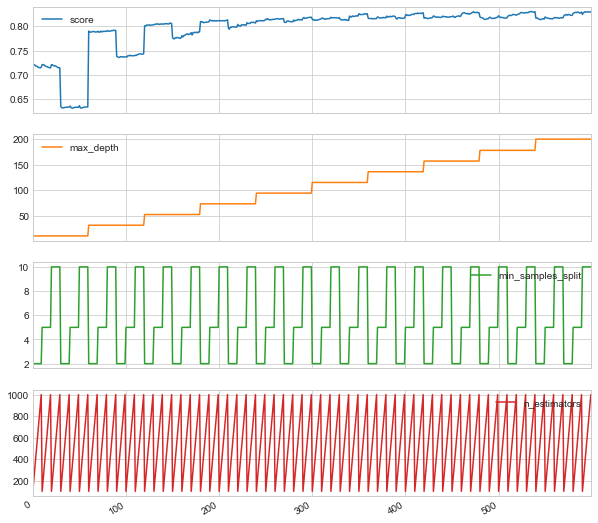

In [206]:
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_max_depth'].data,
                                         gs.cv_results_['param_max_features'].data,
                                         gs.cv_results_['param_min_samples_split'].data,
                                         gs.cv_results_['param_n_estimators'].data]),
                                           
                           columns=['score', 'max_depth', 'max_features', 'min_samples_split', 'n_estimators',])
gs_results_df.plot(subplots=True,figsize=(10, 10))


In [207]:
print((gs.cv_results_).keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [208]:
gs_results_df.sample(5)

score max_depth max_features min_samples_split n_estimators
13   0.718431        10         auto                 5          400
190  0.813175        73         auto                 5          100
476  0.828127       157         log2                10          700
363  0.815988       136         auto                 2          400
184   0.80755        73         auto                 2          500

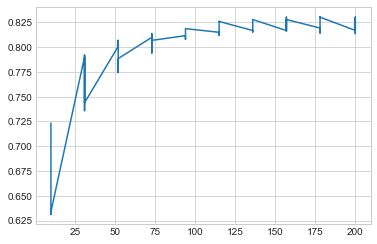

In [209]:
#gs_results_df.plot([gs_results_df['max_depth'],gs_results_df['score']])
plt.plot(gs_results_df['max_depth'],gs_results_df['score'])

**2. LinearSVC Hyperparameters Tuning**

In [211]:
%%time
#OPTIMISATION DES HYPERPARAMETRES DU MODEL LINEARSVC AVEC GRIDSEARCH - We want to decrease the classifier's complexty (decrease parameter C of LinearSVC)
from sklearn.model_selection import GridSearchCV
param_grid={'C': np.linspace(0.0000001, 1, 250)}
model = LinearSVC()
kf = KFold(n_splits=2,random_state=42)
n_iter= 50
random_state = 42
gs=GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=kf, verbose=False)
gs.fit(X_Singt3gram_vectorizer_train,y_cora_train)
gs_test_score=accuracy_score(y_cora_test, gs.predict(X_Singt3gram_vectorizer_test))

CPU times: user 387 ms, sys: 56.3 ms, total: 444 ms
Wall time: 2.71 s


In [215]:
print("Best Accuracy on training sample: {:.3f} with hyperparameters {}".format(gs.best_score_, gs.best_params_))
print("Best Accuracy on validation sample: {:.3f} ".format(gs_test_score))

Best Accuracy on training sample: 0.817 with hyperparameters {'C': 0.3654619108433735}
Best Accuracy on validation sample: 0.828 


In [219]:
print("Best Accuracy for training{:.3f} params {}".format(gs.best_score_, gs.best_params_))
print("Best Accuracy for validation: {:.3f}".format(gs_test_score))

Best Accuracy for training0.817 params {'C': 0.3654619108433735}
Best Accuracy for validation: 0.828


In [220]:
print("Best Accuracy on training sample: {:.3f} with hyperparameters {}".format(gs.best_score_, gs.best_params_))
print("Best Accuracy on validation sample: {:.3f} ".format(gs_test_score))

Best Accuracy on training sample: 0.817 with hyperparameters {'C': 0.3654619108433735}
Best Accuracy on validation sample: 0.828 


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5c5d7550>,
      dtype=object)

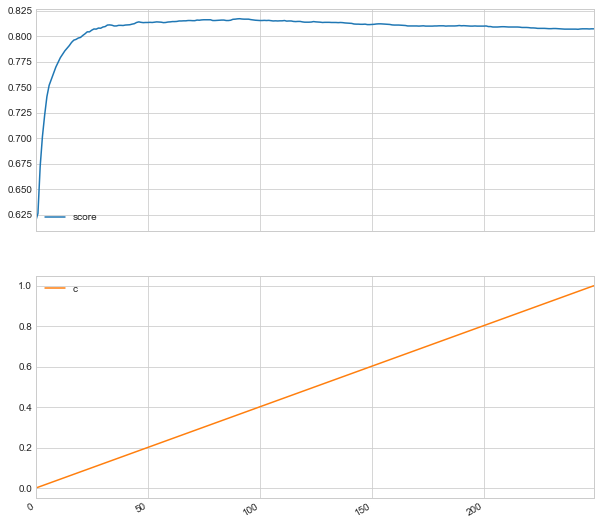

In [221]:
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_C'].data]),
                           columns=['score', 'c'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

In [223]:
%%time
#Let's RECALL THE lINEARsvc with the penality = l1, which results in sparse solutions. Sparse solutions correspond to an implicit feature selection.
from sklearn.model_selection import GridSearchCV
param_grid={'C': np.linspace(0.0000001, 1, 250),
            'penalty' : ['l1'],
            'dual': [False]}
model = LinearSVC()
kf = KFold(n_splits=2,random_state=42)
n_iter= 50
random_state = 42
gs=GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=kf, verbose=False)
gs.fit(X_Singt3gram_vectorizer_train,y_cora_train)
gs_test_score=accuracy_score(y_cora_test, gs.predict(X_Singt3gram_vectorizer_test))

CPU times: user 343 ms, sys: 66.4 ms, total: 410 ms
Wall time: 2.18 s


In [224]:
print("Best Accuracy on training sample: {:.3f} with hyperparameters {}".format(gs.best_score_, gs.best_params_))
print("Best Accuracy on validation sample: {:.3f} ".format(gs_test_score))

Best Accuracy on training sample: 0.811 with hyperparameters {'C': 0.5421687204819277, 'dual': False, 'penalty': 'l1'}
Best Accuracy on validation sample: 0.833 


In [225]:
print("Best Accuracy on training sample: {:.3f} with hyperparameters {}".format(gs.best_score_, gs.best_params_))
print("Best Accuracy on validation sample: {:.3f} ".format(gs_test_score))

Best Accuracy on training sample: 0.811 with hyperparameters {'C': 0.5421687204819277, 'dual': False, 'penalty': 'l1'}
Best Accuracy on validation sample: 0.833 


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5bfbbe10>,
      dtype=object)

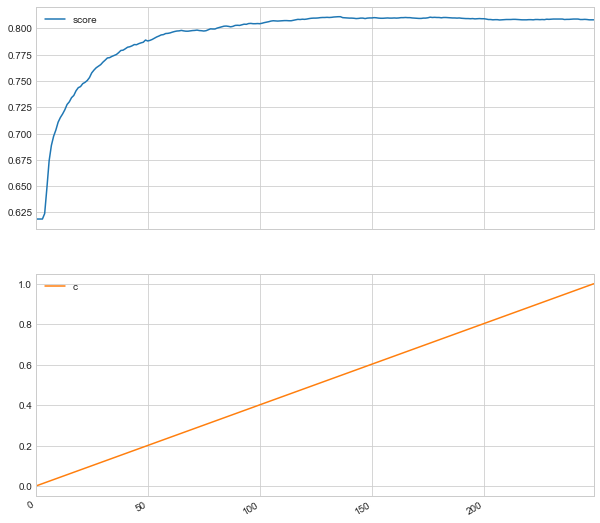

In [226]:
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_C'].data]),
                           columns=['score', 'c'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

**We prefer the hyperparameter in the first case: C = 0.46231161155778894 with best accuracy score = 0.878** 

Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.878608                   0.877869           /    0.868394                   0.867305
Test     :       0.826943                   0.825052           /    0.828325                   0.826186
CPU times: user 312 ms, sys: 45.7 ms, total: 358 ms
Wall time: 940 ms


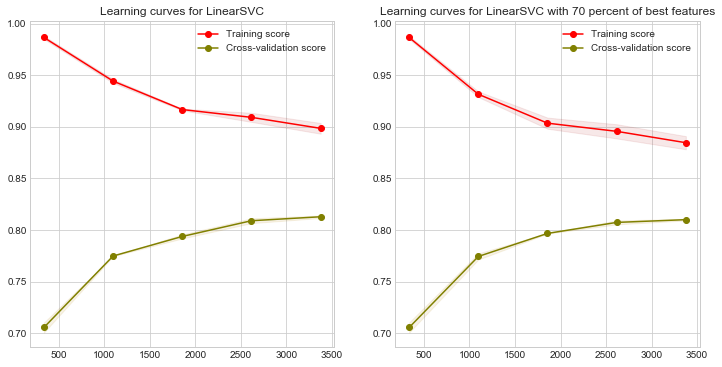

In [227]:
%%time
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=70)
def modelize_LinearSVC(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Clf1 = clf(C=0.46231161155778894).fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(C=0.46231161155778894))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=42)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')
    
modelize_LinearSVC([LinearSVC],X_Singt3gram_vectorizer_train,y_cora_train,X_Singt3gram_vectorizer_test,y_cora_test)

In [228]:
#Nouvel Echantillonage  
cora_data_neg_sample = cora_data[cora_data['target'] == 1] #Negatives comments
cora_data_positive_sample = cora_data[cora_data['target'] == 0].reindex()  #Positive Comments

cora_resampling = pd.concat([pd.DataFrame(cora_data_positive_sample.sample(20000)),
                               pd.DataFrame(cora_data_neg_sample)])
100*(cora_resampling.groupby('target')['question_text'].count())/cora_resampling['target'].count()

target
0    45.397798
1    54.602202
Name: question_text, dtype: float64

In [229]:
cora_resampling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44055 entries, 1011214 to 1141284
Data columns (total 3 columns):
qid              44055 non-null object
question_text    44055 non-null object
target           44055 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [230]:
#Cleaning the data 
cora_resampling['clean_question'] = cora_resampling['question_text'].apply(clean_str)
#Tokenizing and stopwords removing
cora_resampling['tokeniZ_stopWords_question'] = cora_resampling['clean_question'].apply(tokeniZ_stopWords)
#Words Stemming
cora_resampling['stemming_question'] = [[ps.stem(word) for word in words] for words in cora_resampling['tokeniZ_stopWords_question'] ]
cora_resampling['stemming_question_for_tfidf'] = [' '.join(words) for words in cora_resampling['stemming_question']] 

In [231]:
cora_resampling.columns

Index(['qid', 'question_text', 'target', 'clean_question',
       'tokeniZ_stopWords_question', 'stemming_question',
       'stemming_question_for_tfidf'],
      dtype='object')

In [339]:
X_cora_train, X_cora_test, y_cora_train, y_cora_test = train_test_split(
            cora_resampling['stemming_question_for_tfidf']
            ,cora_resampling['target'], 
            test_size=0.3, random_state=42)
X_cora_train.shape, X_cora_test.shape, y_cora_train.shape, y_cora_test.shape

((30838,), (13217,), (30838,), (13217,))

In [341]:
#Vectorization with tf-idf
X_Singt3gram_vectorizer_train_ = st3gram_vectorizer.fit_transform(X_cora_train)
X_Singt3gram_vectorizer_test_  = st3gram_vectorizer.transform(X_cora_test)

In [342]:
%%time
#OPTIMISATION DES HYPERPARAMETRES DU MODEL LINEARSVC AVEC GRIDSEARCH - We want to increase the regularization of the classifier (decrease parameter C of LinearSVC)
from sklearn.model_selection import GridSearchCV
param_grid={'C': np.linspace(0.0000001, 1, 250)}
model = LinearSVC()
kf = KFold(n_splits=2,random_state=42)
n_iter= 50
random_state = 42
gs=GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=kf, verbose=False)
gs.fit(X_Singt3gram_vectorizer_train_,y_cora_train_)
gs_test_score=accuracy_score(y_cora_test_, gs.predict(X_Singt3gram_vectorizer_test_))

CPU times: user 996 ms, sys: 482 ms, total: 1.48 s
Wall time: 15.1 s


In [343]:
print("Best Accuracy on training sample: {:.3f} with hyperparameters {}".format(gs.best_score_, gs.best_params_))
print("Best Accuracy on validation sample: {:.3f} ".format(gs_test_score))

Best Accuracy on training sample: 0.857 with hyperparameters {'C': 0.19678722891566267}
Best Accuracy on validation sample: 0.865 


In [344]:
from sklearn.metrics import balanced_accuracy_score

Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score
training :       0.897118                   0.898305           /    0.883095                   0.883932
Test     :       0.864546                   0.865824           /    0.861816                   0.862445
CPU times: user 701 ms, sys: 161 ms, total: 862 ms
Wall time: 1.82 s


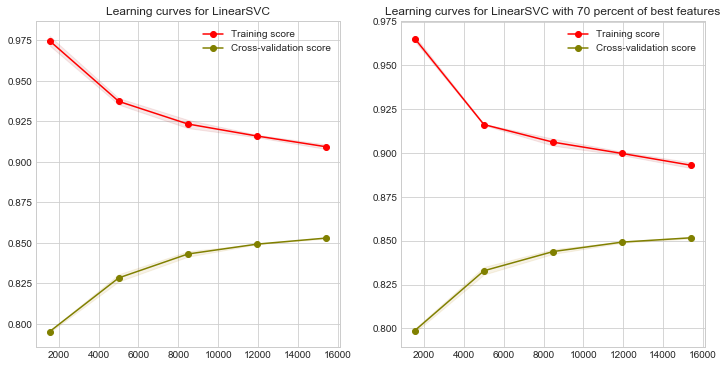

In [345]:
%%time
#Let's try to increase the data regularization by using the Standardization method
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=60)
def modelize_LinearSVC(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Clf1 = clf(C=0.4056225493975904).fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(C=0.4056225493975904))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=51)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),balanced_accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,balanced_accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='balanced_accuracy')
        print('=============================================')
    
modelize_LinearSVC([LinearSVC],X_Singt3gram_vectorizer_train,y_cora_train,X_Singt3gram_vectorizer_test,y_cora_test)

Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score
training :       0.871717                   0.873102           /    0.867769                   0.868040
Test     :       0.825984                   0.827034           /    0.837973                   0.838583
CPU times: user 5.3 s, sys: 92 ms, total: 5.39 s
Wall time: 9.37 s


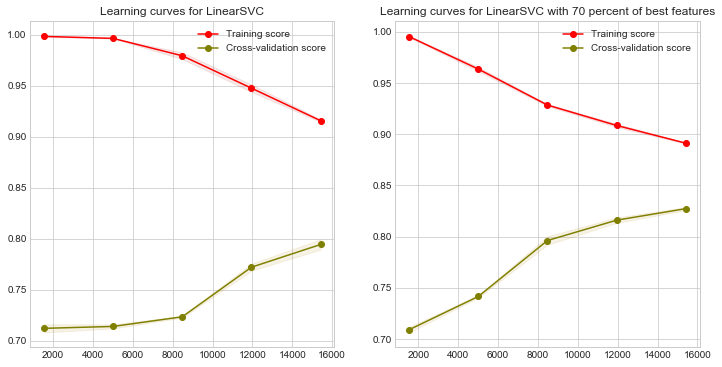

In [346]:
%%time
#Let's try to increase the data regularization by using the Standardization method
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=60)
def modelize_LinearSVC(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Clf1 = clf(C=0.4056225493975904).fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(C=0.4056225493975904))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=51)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),balanced_accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,balanced_accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='balanced_accuracy')
        print('=============================================')
norm=StandardScaler(with_mean=False)
modelize_LinearSVC([LinearSVC],norm.fit_transform(X_Singt3gram_vectorizer_train),y_cora_train,norm.transform(X_Singt3gram_vectorizer_test),y_cora_test)

Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score
training :       0.897118                   0.898305           /    0.883095                   0.883932
Test     :       0.864546                   0.865824           /    0.861816                   0.862445
CPU times: user 562 ms, sys: 49.1 ms, total: 611 ms
Wall time: 1.18 s


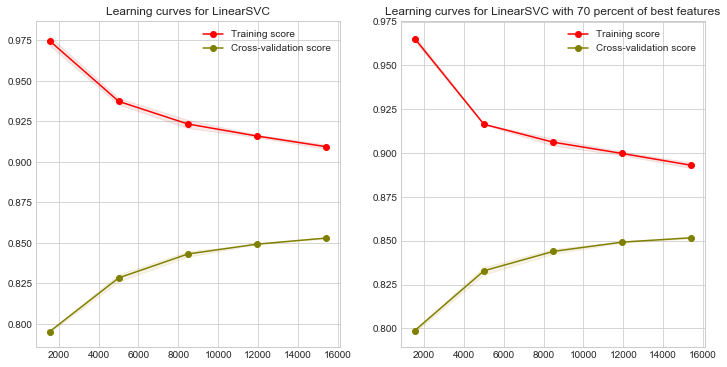

In [347]:
%%time
#Let's try to increase the data regularization by using the normalization method
modelize_LinearSVC([LinearSVC],normalize(X_Singt3gram_vectorizer_train,norm='l2'),y_cora_train,normalize(X_Singt3gram_vectorizer_test,norm='l2'),y_cora_test)

**3. MLPClassiffer Hyperparameters optimization**

In [348]:
#Parameters Optimization with HyperOpt 
#1. We need to create a function to minimize.
def MLP_accuracy_cv(params, random_state=random_state, cv=kf, X=X_t3gram_vectorizer_train, y=y_cora_train):
    # the function gets a set of variable parameters in "param" 
    params = {'hidden_layer_sizes': tuple(params['hidden_layer_sizes']), 
              'activation': str(params['activation']),#Activation functions for the hidden layers
              'solver': str(params['solver']), #The solver for weight optimization.
              'alpha': int(params['alpha']), #L2 penalty (regularization term) parameter
              'learning_rate': str(params['learning_rate'])} #Learning rate schedule for weight updates
    # we use this params to create a new LinearSVC Classifier
    model = MLPClassifier(random_state=random_state ,# **params)
                          hidden_layer_sizes = params['hidden_layer_sizes'],
                          activation = params['activation'],
                          solver = params['solver'],
                          alpha = params['alpha'],
                          learning_rate = params['learning_rate'])
    # and then conduct the cross validation with the same folds as before
    try:
        return {'loss' : -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean(),
                'time' : time.time(),
                'status' : STATUS_OK }
    except (Exception, e):
        return {'status' : STATUS_FAIL,
                'time' : time.time(),
                'exception' : str(e)}

In [349]:
%%time
# possible values of parameters
space={'hidden_layer_sizes': hp.choice('hidden_layer_sizes' , [(20,10,5,),(5,25,50,),(100,25,5,)]),
       'activation' : hp.choice('activation' , ["identity", "logistic", "tanh", "relu"]), 
       'solver' : hp.choice( 'solver' , ["lbfgs", "sgd", "adam"]),
       'alpha': hp.uniform('alpha',0.0001,0.9),
       'learning_rate': hp.choice('learning_rate' , ["constant", "invscaling", "adaptive"])
      }
      

# trials will contain logging information
trials = Trials()

best=fmin(fn=MLP_accuracy_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state)) # fixing random state for the reproducibility

NameError: name 'e' is not defined

In [241]:
%%time
# computing the score on the test set
model = MLPClassifier(random_state=random_state, activation = str(space_eval(space,best)['activation'] ),
                                                 solver = str(space_eval(space,best)['solver']),
                                                 alpha = int(best['alpha']),
                                                 hidden_layer_sizes=tuple(space_eval(space,best)['hidden_layer_sizes']),
                                                 learning_rate = str(space_eval(space,best)['learning_rate'] ))
model.fit(X_t3gram_vectorizer_train,y_cora_train)
tpe_test_score=accuracy_score(y_cora_test, model.predict(X_t3gram_vectorizer_test))

CPU times: user 23.1 s, sys: 370 ms, total: 23.5 s
Wall time: 13.2 s


In [242]:
%%time
print("Best Accuracy score on train set {:.3f} params {}".format( -MLP_accuracy_cv(space_eval(space,best))['loss'], space_eval(space,best)))
print('Accuracy score on validation sample {:.3f}'.format(tpe_test_score))

Best Accuracy score on train set 0.806 params {'activation': 'identity', 'alpha': 0.2364576960899428, 'hidden_layer_sizes': (100, 25, 5), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Accuracy score on validation sample 0.822
CPU times: user 11.8 ms, sys: 11.8 ms, total: 23.6 ms
Wall time: 7.08 s


Model : MLPClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.880533                   0.879990           /    0.862028                   0.861225
Test     :       0.822453                   0.820711           /    0.828325                   0.826620
CPU times: user 41.9 s, sys: 652 ms, total: 42.6 s
Wall time: 1min 3s


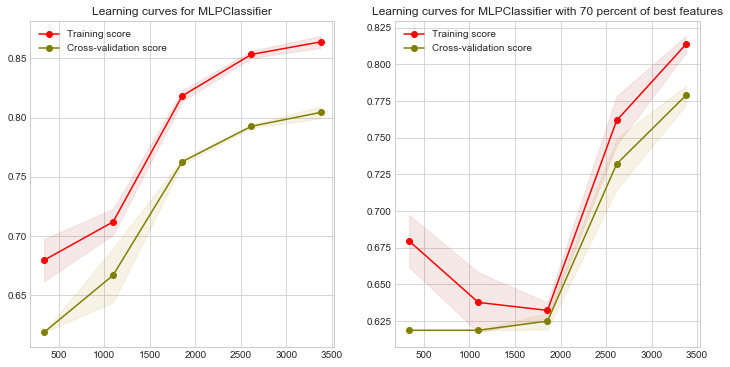

In [243]:
%%time
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=70)
def modelize_MLP(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Model = MLPClassifier(random_state=random_state, activation = str(space_eval(space,best)['activation'] ),
                                                 solver = str(space_eval(space,best)['solver']),
                                                 alpha = int(best['alpha']),
                                                 hidden_layer_sizes=tuple(space_eval(space,best)['hidden_layer_sizes']),
                                                 learning_rate = str(space_eval(space,best)['learning_rate'] ))
        
        Clf1 = Model.fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',MLPClassifier(random_state=random_state, activation = str(space_eval(space,best)['activation'] ),
                                                 solver = str(space_eval(space,best)['solver']),
                                                 alpha = int(best['alpha']),
                                                 hidden_layer_sizes=tuple(space_eval(space,best)['hidden_layer_sizes']),
                                                 learning_rate = str(space_eval(space,best)['learning_rate'] )))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=random_state)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')
        
modelize_MLP([MLPClassifier],X_t3gram_vectorizer_train,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

In [244]:
cora_data_neg_sample = cora_data[cora_data['target'] == 1] #Negatives comments
cora_data_positive_sample = cora_data[cora_data['target'] == 0].reindex()  #Positive Comments

cora_resampling = pd.concat([pd.DataFrame(cora_data_positive_sample.sample(4000)),
                               pd.DataFrame(cora_data_neg_sample.sample(2500))])
100*(cora_resampling.groupby('target')['question_text'].count())/cora_resampling['target'].count()

target
0    61.538462
1    38.461538
Name: question_text, dtype: float64

In [245]:
#Cleaning the data 
cora_resampling['clean_question'] = cora_resampling['question_text'].apply(clean_str)
#Tokenizing and stopwords removing
cora_resampling['tokeniZ_stopWords_question'] = cora_resampling['clean_question'].apply(tokeniZ_stopWords)
#Words lemmatization
cora_resampling['lemmatize_question'] = cora_resampling['tokeniZ_stopWords_question'].apply(lemat_words)
cora_resampling['lemmatize_question_for_tfidf'] = [' '.join(x) for x in cora_resampling['lemmatize_question'] ]
#Vectorization with tf-idf
X_Singt3gram_vectorizer_train = st3gram_vectorizer.fit_transform(X_cora_train['lemmatize_question_for_tfidf'])
X_Singt3gram_vectorizer_test  = st3gram_vectorizer.transform(X_cora_test['lemmatize_question_for_tfidf'])

Model : MLPClassifier
With all features                                              /    With 70% of the best features
                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score
training :       0.869197                   0.879990           /    0.848509                   0.861225
Test     :       0.801194                   0.820711           /    0.807390                   0.826620
CPU times: user 40 s, sys: 485 ms, total: 40.5 s
Wall time: 57.4 s


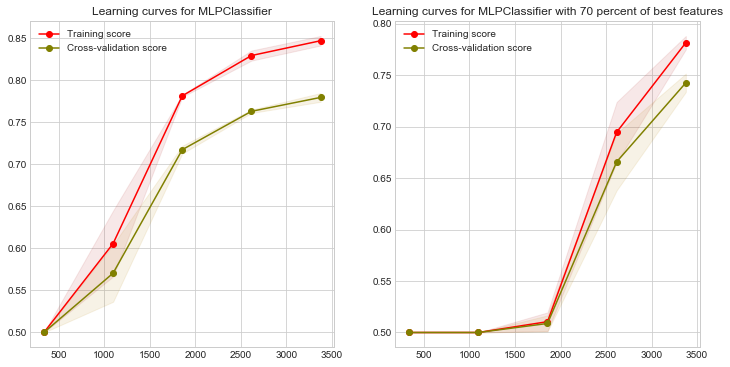

In [246]:
%%time
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=70)
def modelize_MLP(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Model = MLPClassifier(random_state=random_state, activation = str(space_eval(space,best)['activation'] ),
                                                 solver = str(space_eval(space,best)['solver']),
                                                 alpha = int(best['alpha']),
                                                 hidden_layer_sizes=tuple(space_eval(space,best)['hidden_layer_sizes']),
                                                 learning_rate = str(space_eval(space,best)['learning_rate'] ))
        
        Clf1 = Model.fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',MLPClassifier(random_state=random_state, activation = str(space_eval(space,best)['activation'] ),
                                                 solver = str(space_eval(space,best)['solver']),
                                                 alpha = int(best['alpha']),
                                                 hidden_layer_sizes=tuple(space_eval(space,best)['hidden_layer_sizes']),
                                                 learning_rate = str(space_eval(space,best)['learning_rate'] )))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=random_state)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),balanced_accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,balanced_accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='balanced_accuracy')
        print('=============================================')
        
modelize_MLP([MLPClassifier],X_t3gram_vectorizer_train,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

**4. Logistic Regression Hyperparameters tuning**

In [247]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
random_state = 42

In [249]:
%%time
#Let's try to increase the model complexity.

param_grid={'C': np.linspace(1, 12, 100),
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'liblinear']}
model = LogisticRegression( n_jobs=-1)
kf = KFold(n_splits=3,random_state=random_state)

gs=GridSearchCV(model, param_grid, scoring='accuracy',  n_jobs=-1, cv=kf, verbose=False)
gs.fit(X_t3gram_vectorizer_train,y_cora_train)
gs_test_score=accuracy_score(y_cora_test, gs.predict(X_t3gram_vectorizer_test))

CPU times: user 2.27 s, sys: 138 ms, total: 2.41 s
Wall time: 37.7 s


In [250]:
print("Best Accuracy on training sample: {:.3f} with hyperparameters {}".format(gs.best_score_, gs.best_params_))
print("Best Accuracy on validation sample: {:.3f} ".format(gs_test_score))

Best Accuracy on training sample: 0.820 with hyperparameters {'C': 2.888888888888889, 'solver': 'saga'}
Best Accuracy on validation sample: 0.827 


In [251]:
print("Best Accuracy on training sample: {:.3f} with hyperparameters {}".format(gs.best_score_, gs.best_params_))
print("Best Accuracy on validation sample: {:.3f} ".format(gs_test_score))

Best Accuracy on training sample: 0.820 with hyperparameters {'C': 2.888888888888889, 'solver': 'saga'}
Best Accuracy on validation sample: 0.827 


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a58435080>,
      dtype=object)

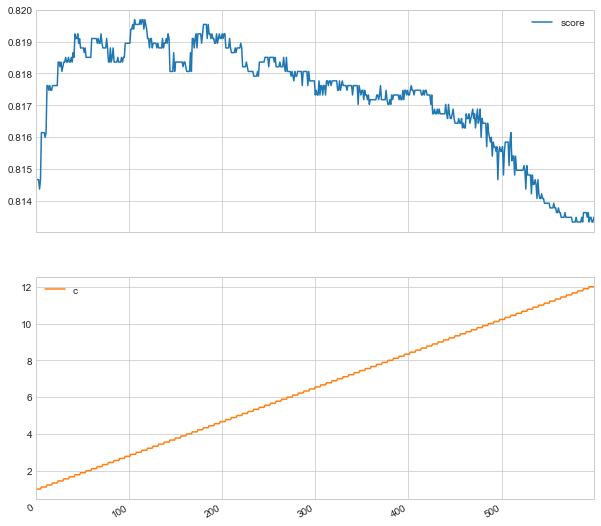

In [252]:
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_C'].data]),
                           columns=['score', 'c'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

Model : LogisticRegression
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.862154                   0.875304           /    0.852356                   0.866658
Test     :       0.802985                   0.823760           /    0.806387                   0.827452
CPU times: user 302 ms, sys: 19.3 ms, total: 321 ms
Wall time: 448 ms


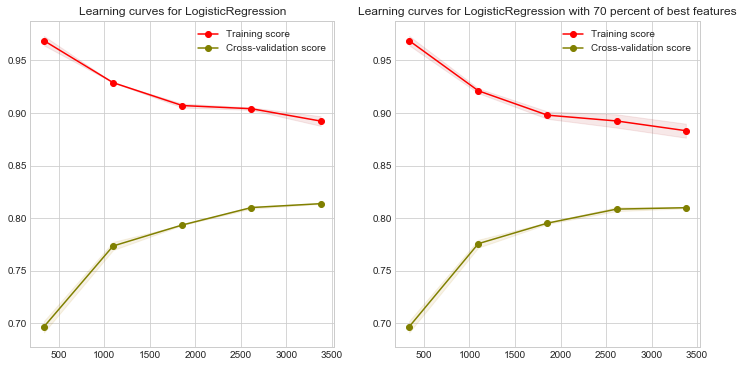

In [253]:
%%time
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=71)
def modelize_LogReg(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Clf1 = clf(C=3.3855421686746987).fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(C=3.3855421686746987))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=42)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),
                balanced_accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted'),
                balanced_accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')
    
modelize_LogReg([LogisticRegression],X_t3gram_vectorizer_train,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

In [256]:
%%time
#Let's try to increase the model complexity.

param_grid={'C': np.linspace(1, 100, 250), 'penalty': ['l1']}
model = LogisticRegression()
kf = KFold(n_splits=3,random_state=random_state)

gs=GridSearchCV(model, param_grid, scoring='accuracy',  n_jobs=-1, cv=kf, verbose=False)
gs.fit(X_t3gram_vectorizer_train,y_cora_train)
gs_test_score=accuracy_score(y_cora_test, gs.predict(X_t3gram_vectorizer_test))

CPU times: user 583 ms, sys: 35 ms, total: 618 ms
Wall time: 6.95 s


In [257]:
print("Best Accuracy on training sample: {:.3f} with hyperparameters {}".format(gs.best_score_, gs.best_params_))
print("Best Accuracy on validation sample: {:.3f} ".format(gs_test_score))

Best Accuracy on training sample: 0.819 with hyperparameters {'C': 1.3975903614457832, 'penalty': 'l1'}
Best Accuracy on validation sample: 0.830 


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a65559b00>,
      dtype=object)

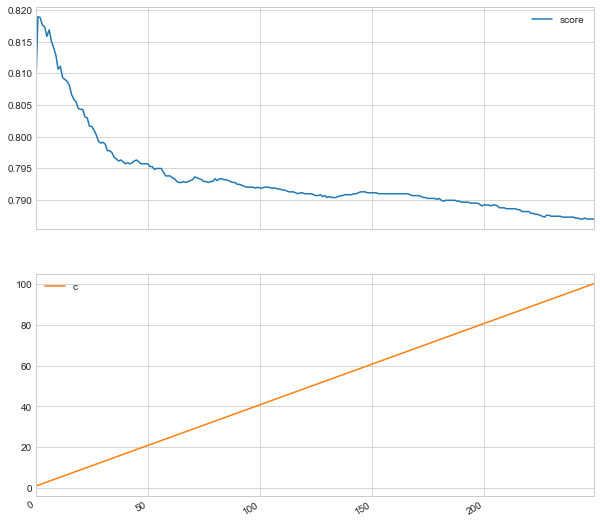

In [258]:
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_C'].data]),
                           columns=['score', 'c'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

Model : LogisticRegression
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.881114                   0.889999           /    0.861117                   0.872896
Test     :       0.793017                   0.811719           /    0.797708                   0.816746
CPU times: user 330 ms, sys: 27.3 ms, total: 357 ms
Wall time: 664 ms


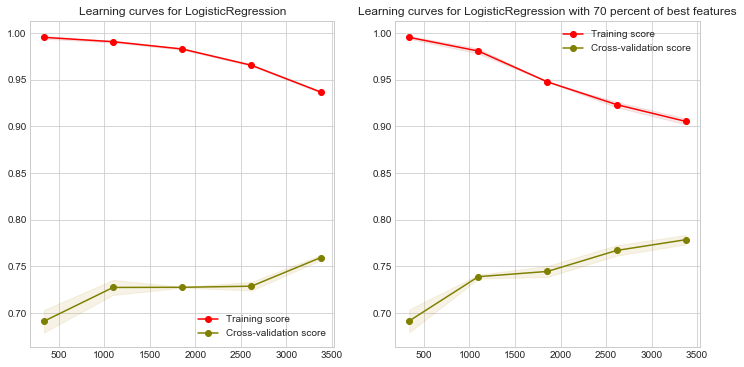

In [259]:
%%time
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=70)
def modelize_LogReg(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Clf1 = clf(C= 2.9879518072289155, penalty= 'l1').fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(C=2.9879518072289155, penalty='l1'))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=42)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),
                balanced_accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,balanced_accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')
norm=StandardScaler(with_mean=False)
modelize_LogReg([LogisticRegression],norm.fit_transform(X_t3gram_vectorizer_train),y_cora_train,norm.transform(X_t3gram_vectorizer_test),y_cora_test)

Model : LogisticRegression
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.881577                   0.890314           /    0.861266                   0.872918
Test     :       0.793757                   0.812415           /    0.797434                   0.816419
CPU times: user 409 ms, sys: 23.9 ms, total: 433 ms
Wall time: 685 ms


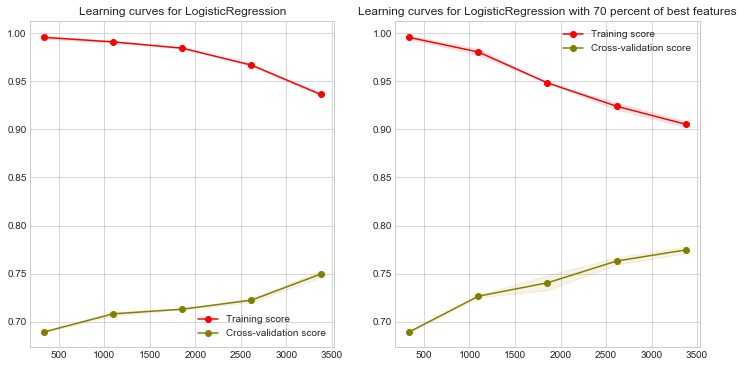

In [260]:
%%time
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=70)
def modelize_LogReg(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Clf1 = clf(C= 3.3855421686746987, penalty= 'l2').fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(C=3.3855421686746987, penalty='l2'))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=42)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),
                balanced_accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,balanced_accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')
norm=StandardScaler(with_mean=False)
modelize_LogReg([LogisticRegression],norm.fit_transform(X_t3gram_vectorizer_train),y_cora_train,norm.transform(X_t3gram_vectorizer_test),y_cora_test)

In [287]:
#Nouvel Echantillonage  
cora_data_neg_sample = cora_data[cora_data['target'] == 1] #Negatives comments
cora_data_positive_sample = cora_data[cora_data['target'] == 0].reindex()  #Positive Comments

cora_resampling = pd.concat([pd.DataFrame(cora_data_positive_sample.sample(20000)),
                               pd.DataFrame(cora_data_neg_sample)])
100*(cora_resampling.groupby('target')['question_text'].count())/cora_resampling['target'].count()

#Cleaning the data 
cora_resampling['clean_question'] = cora_resampling['question_text'].apply(clean_str)
#Tokenizing and stopwords removing
cora_resampling['tokeniZ_stopWords_question'] = cora_resampling['clean_question'].apply(tokeniZ_stopWords)
#Words Stemming
cora_resampling['stemming_question'] = [[ps.stem(word) for word in words] for words in cora_resampling['tokeniZ_stopWords_question'] ]
cora_resampling['stemming_question_for_tfidf'] = [' '.join(words) for words in cora_resampling['stemming_question']] 

X_cora_train, X_cora_test, y_cora_train, y_cora_test = train_test_split(
            cora_resampling['stemming_question_for_tfidf']
            ,cora_resampling['target'], 
            test_size=0.3, random_state=42)
X_cora_train.shape, X_cora_test.shape, y_cora_train.shape, y_cora_test.shape

#Vectorization with tf-idf
X_Singt3gram_vectorizer_train = st3gram_vectorizer.fit_transform(X_cora_train)
X_Singt3gram_vectorizer_test  = st3gram_vectorizer.transform(X_cora_test)

X_t3gram_vectorizer_train = t3gram_vectorizer.fit_transform(X_cora_train)
X_t3gram_vectorizer_test  = t3gram_vectorizer.transform(X_cora_test)

In [288]:
%%time
#OPTIMISATION DES HYPERPARAMETRES DU MODEL LINEARSVC AVEC GRIDSEARCH - We want to increase the regularization of the classifier (decrease parameter C of LinearSVC)
from sklearn.model_selection import GridSearchCV
param_grid={'C': np.linspace(1, 10, 50), 'penalty': ['l2']}
model = LogisticRegression(n_jobs=-1)
kf = KFold(n_splits=3,random_state=random_state)

gs=GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=kf, verbose=False)
gs.fit(X_t3gram_vectorizer_train,y_cora_train)
gs_test_score=balanced_accuracy_score(y_cora_test, gs.predict(X_t3gram_vectorizer_test))

CPU times: user 565 ms, sys: 163 ms, total: 728 ms
Wall time: 8.87 s


In [289]:
print("Best Accuracy on training sample: {:.3f} with hyperparameters {}".format(gs.best_score_, gs.best_params_))
print("Best Accuracy on validation sample: {:.3f} ".format(gs_test_score))

Best Accuracy on training sample: 0.859 with hyperparameters {'C': 1.9183673469387754, 'penalty': 'l2'}
Best Accuracy on validation sample: 0.863 


In [290]:
print("Best Accuracy on training sample: {:.3f} with hyperparameters {}".format(gs.best_score_, gs.best_params_))

gs_test_scorer=accuracy_score(y_cora_test, gs.predict(X_t3gram_vectorizer_test))
print("Best Accuracy on validation sample: {:.3f} ".format(gs_test_scorer))
print("Best balanced Accuracy on validation sample: {:.3f} ".format(gs_test_score))

Best Accuracy on training sample: 0.859 with hyperparameters {'C': 1.9183673469387754, 'penalty': 'l2'}
Best Accuracy on validation sample: 0.864 
Best balanced Accuracy on validation sample: 0.863 


Model : LogisticRegression
With all features                                              /    With 70% of the best features
                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score
training :       0.895332                   0.896608           /    0.866018                   0.866408
Test     :       0.863812                   0.865136           /    0.851556                   0.852372
CPU times: user 586 ms, sys: 59.3 ms, total: 646 ms
Wall time: 1.23 s


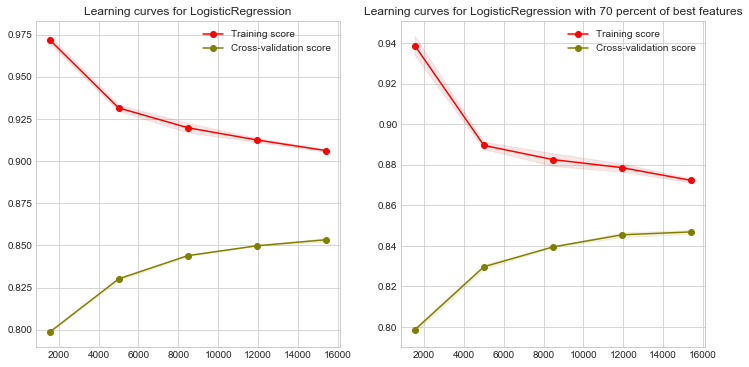

In [291]:
%%time
from sklearn.metrics import balanced_accuracy_score

#Let's try to increase the data regularization by using the Standardization method
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=30)
def modelize_LogReg(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Clf1 = clf(C=3.272727272727273).fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(C=3.272727272727273))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=51)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),balanced_accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,balanced_accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='balanced_accuracy')
        print('=============================================')
    
modelize_LogReg([LogisticRegression],X_t3gram_vectorizer_train,y_cora_train,X_t3gram_vectorizer_test,y_cora_test)

Model : LogisticRegression
With all features                                              /    With 70% of the best features
                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score
training :       0.907150                   0.908087           /    0.867109                   0.867158
Test     :       0.849048                   0.850008           /    0.849873                   0.850444
CPU times: user 1.2 s, sys: 42.9 ms, total: 1.25 s
Wall time: 2.78 s


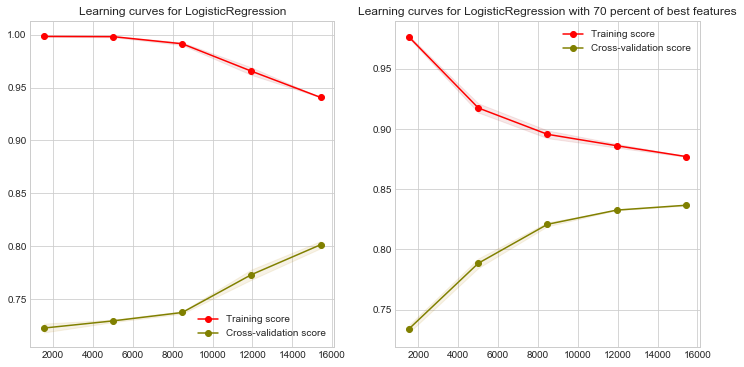

In [292]:
%%time
norm=StandardScaler(with_mean=False)
modelize_LogReg([LogisticRegression],norm.fit_transform(X_t3gram_vectorizer_train),y_cora_train,norm.transform(X_t3gram_vectorizer_test),y_cora_test)

Model : LogisticRegression
With all features                                              /    With 70% of the best features
                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score
training :       0.895332                   0.896608           /    0.866018                   0.866408
Test     :       0.863812                   0.865136           /    0.851556                   0.852372
CPU times: user 583 ms, sys: 41.5 ms, total: 625 ms
Wall time: 1.21 s


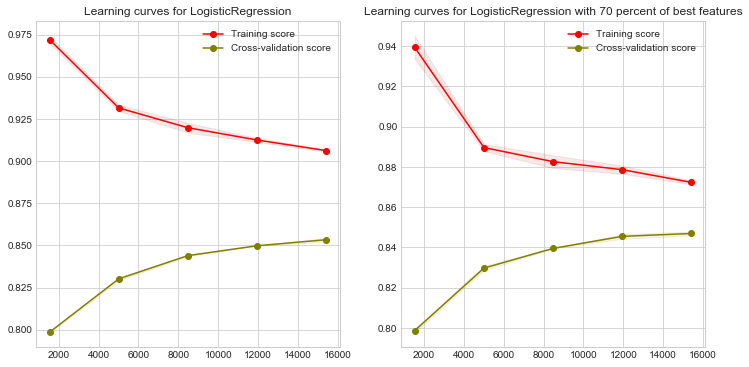

In [293]:
%%time
selector = SelectPercentile(f_classif,percentile=30)
modelize_LogReg([LogisticRegression],normalize(X_t3gram_vectorizer_train),y_cora_train,normalize(X_t3gram_vectorizer_test),y_cora_test)

In [294]:
%%time
random_state=42
kf = KFold(n_splits=3,random_state=random_state)

searchCV = LogisticRegressionCV(
        Cs=list(np.linspace(0.0001, 100, 250))
        ,penalty='l1'
        ,scoring='accuracy'
        ,cv=kf
        ,random_state=random_state
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='saga'
        ,tol=10
    )
searchCV.fit(X_Singt3gram_vectorizer_train, y_cora_train)

CPU times: user 5min 21s, sys: 841 ms, total: 5min 22s
Wall time: 5min 25s


LogisticRegressionCV(Cs=[0.0001, 0.4017060240963855, 0.803312048192771,
                         1.2049180722891566, 1.606524096385542,
                         2.008130120481928, 2.4097361445783134,
                         2.811342168674699, 3.2129481927710843,
                         3.61455421686747, 4.016160240963855, 4.417766265060241,
                         4.819372289156626, 5.220978313253012,
                         5.622584337349397, 6.024190361445783,
                         6.425796385542168, 6.8274024096385535,
                         7.229008...
                         10.040250602409637, 10.441856626506024,
                         10.843462650602408, 11.245068674698794,
                         11.646674698795179, ...],
                     class_weight=None,
                     cv=KFold(n_splits=3, random_state=42, shuffle=False),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=10000, mul

In [295]:
print ('Max accuracy training sample:', searchCV.scores_[1].mean(axis=0).max())
print('Max accuracy validation sample:', accuracy_score(searchCV.predict(X_Singt3gram_vectorizer_test),y_cora_test))

Max accuracy training sample: 0.8572863035700834
Max accuracy validation sample: 0.8445940833774684


In [296]:
%%time
from sklearn.metrics import balanced_accuracy_score

#Let's try to increase the data regularization by using the Standardization method
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=70)
def modelize_LogReg(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Clf1 = clf.fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf)]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=51)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),balanced_accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,balanced_accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='balanced_accuracy')
        print('=============================================')
    
modelize_LogReg([LogisticRegressionCV(Cs=list(np.linspace(0.0001, 100, 250)),penalty='l2',scoring='accuracy',cv=kf
     ,random_state=random_state,max_iter=10000,fit_intercept=True,solver='newton-cg',tol=10)],X_Singt3gram_vectorizer_train,y_cora_train,X_Singt3gram_vectorizer_test,y_cora_test)

Model : LogisticRegressionCV
With all features                                              /    With 70% of the best features
                 Balanced Accuracy Score    F1 Score                Balanced Accuracy Score    F1 Score


ValueError: X has 3652 features per sample; expecting 2556

Model : LogisticRegression
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.907150                   0.908087           /    0.891020                   0.891663
Test     :       0.849048                   0.850008           /    0.852379                   0.853463
CPU times: user 1.29 s, sys: 169 ms, total: 1.46 s
Wall time: 7.83 s


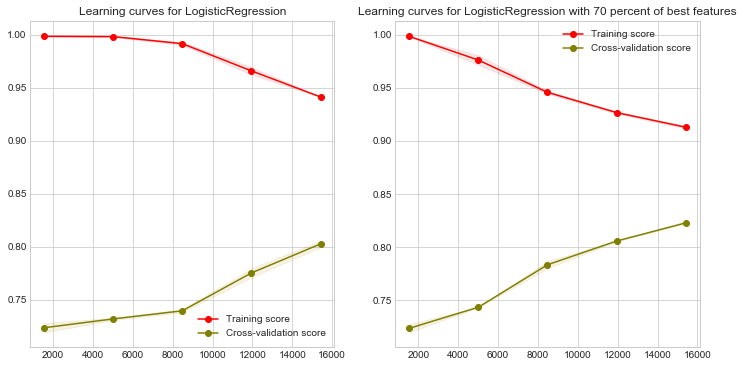

In [297]:
%%time
#Lets generate the learning curve of the optimized model
selector = SelectPercentile(f_classif,percentile=70)
def modelize_LogReg(list_clf,X,y,X_test,y_test):
    for clf in list_clf:
        Clf1 = clf(C= 3.3855421686746987, penalty= 'l2').fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(C=3.3855421686746987, penalty='l2'))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=3 , test_size=.3, random_state=42)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),
                balanced_accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(balanced_accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,balanced_accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')
norm=StandardScaler(with_mean=False)
modelize_LogReg([LogisticRegression],norm.fit_transform(X_t3gram_vectorizer_train),y_cora_train,norm.transform(X_t3gram_vectorizer_test),y_cora_test)

In [298]:
%%time
random_state=42
kf = KFold(n_splits=3,random_state=random_state)

searchCV = LogisticRegressionCV(
        Cs=list(np.linspace(0.0001, 100, 250))
        ,penalty='l1'
        ,scoring='accuracy'
        ,cv=kf
        ,random_state=random_state
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='saga'
        ,tol=10
    )
searchCV.fit(X_Singt3gram_vectorizer_train, y_cora_train)

CPU times: user 5min 24s, sys: 1.79 s, total: 5min 26s
Wall time: 5min 53s


LogisticRegressionCV(Cs=[0.0001, 0.4017060240963855, 0.803312048192771,
                         1.2049180722891566, 1.606524096385542,
                         2.008130120481928, 2.4097361445783134,
                         2.811342168674699, 3.2129481927710843,
                         3.61455421686747, 4.016160240963855, 4.417766265060241,
                         4.819372289156626, 5.220978313253012,
                         5.622584337349397, 6.024190361445783,
                         6.425796385542168, 6.8274024096385535,
                         7.229008...
                         10.040250602409637, 10.441856626506024,
                         10.843462650602408, 11.245068674698794,
                         11.646674698795179, ...],
                     class_weight=None,
                     cv=KFold(n_splits=3, random_state=42, shuffle=False),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=10000, mul

In [299]:
print ('Max accuracy training sample:', searchCV.scores_[1].mean(axis=0).max())
print('Max accuracy validation sample:', accuracy_score(searchCV.predict(X_Singt3gram_vectorizer_test),y_cora_test))

Max accuracy training sample: 0.8572863035700834
Max accuracy validation sample: 0.8445940833774684


In [300]:
%%time
random_state=42
kf = KFold(n_splits=3,random_state=random_state)

searchCV = LogisticRegressionCV(
        Cs=list(np.linspace(0.0001, 100, 250))
        ,penalty='l2'
        ,scoring='accuracy'
        ,cv=kf
        ,random_state=random_state
        ,max_iter=10000
        ,fit_intercept=True
        #,solver='saga'
        ,tol=10
    )
searchCV.fit(norm.fit_transform(X_Singt3gram_vectorizer_train), y_cora_train)

CPU times: user 3.97 s, sys: 105 ms, total: 4.08 s
Wall time: 4.33 s


LogisticRegressionCV(Cs=[0.0001, 0.4017060240963855, 0.803312048192771,
                         1.2049180722891566, 1.606524096385542,
                         2.008130120481928, 2.4097361445783134,
                         2.811342168674699, 3.2129481927710843,
                         3.61455421686747, 4.016160240963855, 4.417766265060241,
                         4.819372289156626, 5.220978313253012,
                         5.622584337349397, 6.024190361445783,
                         6.425796385542168, 6.8274024096385535,
                         7.229008...
                         10.040250602409637, 10.441856626506024,
                         10.843462650602408, 11.245068674698794,
                         11.646674698795179, ...],
                     class_weight=None,
                     cv=KFold(n_splits=3, random_state=42, shuffle=False),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=10000, mul

In [301]:
print ('Max accuracy training sample:', searchCV.scores_[1].mean(axis=0).max())
print ('Max accuracy validation sample:', accuracy_score(searchCV.predict(norm.transform(X_Singt3gram_vectorizer_test)),y_cora_test))

Max accuracy training sample: 0.8441207307054074
Max accuracy validation sample: 0.8524627373836725


In [302]:
searchCV.get_params

<bound method BaseEstimator.get_params of LogisticRegressionCV(Cs=[0.0001, 0.4017060240963855, 0.803312048192771,
                         1.2049180722891566, 1.606524096385542,
                         2.008130120481928, 2.4097361445783134,
                         2.811342168674699, 3.2129481927710843,
                         3.61455421686747, 4.016160240963855, 4.417766265060241,
                         4.819372289156626, 5.220978313253012,
                         5.622584337349397, 6.024190361445783,
                         6.425796385542168, 6.8274024096385535,
                         7.229008...
                         10.040250602409637, 10.441856626506024,
                         10.843462650602408, 11.245068674698794,
                         11.646674698795179, ...],
                     class_weight=None,
                     cv=KFold(n_splits=3, random_state=42, shuffle=False),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
              

### Conclusion

In [303]:
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold
from sklearn.feature_selection import SelectPercentile
from hyperopt import hp,fmin,Trials, tpe, STATUS_FAIL, STATUS_OK, space_eval, anneal
from hyperopt.pyll import scope
from hyperopt.pyll import stochastic

from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import normalize, StandardScaler

import time
random_state = 42
kf = KFold(n_splits=2,random_state=random_state)
n_iter= 50

In [304]:
%%time
import time
random_state = 42

kf = KFold(n_splits=2,random_state=random_state)
n_iter= 50
Model_final_MLPClassifier = Pipeline([('Feature Selection',SelectPercentile(f_classif,percentile=70)),('Classification',MLPClassifier(random_state=random_state, activation = str(space_eval(space,best)['activation'] ),
                                                 solver = str(space_eval(space,best)['solver']),
                                                 alpha = int(best['alpha']),
                                                 hidden_layer_sizes=tuple(space_eval(space,best)['hidden_layer_sizes']),
                                                 learning_rate = str(space_eval(space,best)['learning_rate'] )))]).fit(X_t3gram_vectorizer_train_,y_cora_train_)

Model_final_LogReg = Pipeline([('Feature Selection',SelectPercentile(f_classif,percentile=70)),('Classification',LogisticRegression(C=3.272727272727273))]).fit(X_t3gram_vectorizer_train_,y_cora_train_)
Model_final_LinearSVC = Pipeline([('Feature Selection',SelectPercentile(f_classif,percentile=70)),('Classification',LinearSVC(C=0.4056225493975904))]).fit(X_Singt3gram_vectorizer_train_,y_cora_train_)
Model_final_ExtraTreesClassifier = ExtraTreesClassifier(max_depth= 443.0, max_features= 'sqrt', min_samples_split= 5, n_estimators=117).fit(X_t3gram_vectorizer_train_,y_cora_train_)

CPU times: user 3min 21s, sys: 3.56 s, total: 3min 25s
Wall time: 2min 15s


In [306]:
#mATRICES DE CONFUSIONS
from sklearn.metrics import confusion_matrix
cm_ETree = confusion_matrix(y_cora_test_, Model_final_ExtraTreesClassifier.predict(X_t3gram_vectorizer_test_))
cm_LinearSVC = confusion_matrix(y_cora_test_, Model_final_LinearSVC.predict(X_Singt3gram_vectorizer_test_))
cm_LogReg = confusion_matrix(y_cora_test_, Model_final_LogReg.predict(X_t3gram_vectorizer_test_))
cm_MLP = confusion_matrix(y_cora_test_, Model_final_MLPClassifier.predict(X_t3gram_vectorizer_test_))

In [307]:
#MATRICES DE CONFUSIONS NORMALISEES
cm_ExtraTreesClassifier = cm_ETree.astype('float') / cm_ETree.sum(axis=1)[:, np.newaxis]
cm_LinearSVC = cm_LinearSVC.astype('float') / cm_LinearSVC.sum(axis=1)[:, np.newaxis]
cm_LogisticRegression = cm_LogReg.astype('float') / cm_LogReg.sum(axis=1)[:, np.newaxis]
cm_MLPClassifier = cm_MLP.astype('float') / cm_MLP.sum(axis=1)[:, np.newaxis]

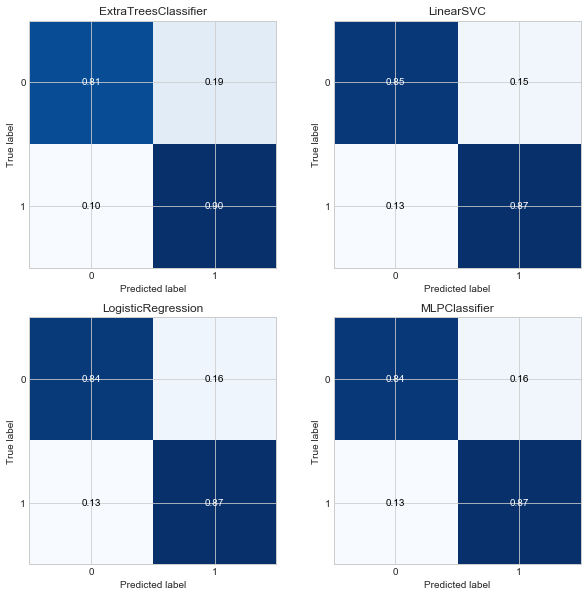

In [308]:
from sklearn.utils.multiclass import unique_labels
classes = unique_labels(y_cora_test_)
#dict_models = {'cm_ExtraTreesClassifier' : 'ExtraTreesClassifier', 'cm_LinearSVC': 'LinearSVC', 'cm_LogisticRegression': 'LogisticRegression', 'cm_MLPClassifier': 'MLPClassifier'}

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))
aX = [ax1, ax2,ax3,ax4]
dict_models = ['ExtraTreesClassifier',  'LinearSVC',  'LogisticRegression',  'MLPClassifier']
for IDX, i in enumerate([cm_ExtraTreesClassifier, cm_LinearSVC, cm_LogisticRegression, cm_MLPClassifier]):
    im = aX[IDX].imshow(i, interpolation='nearest', cmap=plt.cm.Blues)
    #aX[IDX].figure.colorbar(im, aX[IDX]=aX[IDX])

    # We want to show all ticks...
    aX[IDX].set(xticks=np.arange(i.shape[1]), yticks=np.arange(i.shape[0]),
           xticklabels=classes, yticklabels=classes, # ... and label them with the respective list entries
           title= dict_models[IDX],
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    #plt.setp(aX[i].get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = i.max() / 2.
    for t in range(i.shape[0]):
        for j in range(i.shape[1]):
            aX[IDX].text(j, t, format(i[t, j], fmt),
                    ha="center", va="center",
                    color="white" if i[t, j] > thresh else "black")

In [309]:
cm_MLPClassifier

array([[0.83995347, 0.16004653],
       [0.13444444, 0.86555556]])

In [313]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr1, tpr1, thresholds1 = roc_curve(y_cora_test_, Model_final_MLPClassifier.predict(X_t3gram_vectorizer_test_))
fpr2, tpr2, thresholds2 = roc_curve(y_cora_test_, Model_final_ExtraTreesClassifier.predict(X_t3gram_vectorizer_test_))
fpr3, tpr3, thresholds3 = roc_curve(y_cora_test_, Model_final_LinearSVC.predict(X_Singt3gram_vectorizer_test_))
fpr4, tpr4, thresholds4 = roc_curve(y_cora_test_, Model_final_LogReg.predict(X_t3gram_vectorizer_test_))

print('AUC - MLPClassifier: %.2f ' %(auc(fpr1, tpr1)))
print('AUC - ExtraTreesClassifier: %.2f ' %(auc(fpr2, tpr2)))
print('AUC - LinearSVCr: %.2f ' %(auc(fpr3, tpr3)))
print('AUC - LogisticRegression: %.2f ' %(auc(fpr4, tpr4)))


AUC - MLPClassifier: 0.85 
AUC - ExtraTreesClassifier: 0.85 
AUC - LinearSVCr: 0.86 
AUC - LogisticRegression: 0.86 


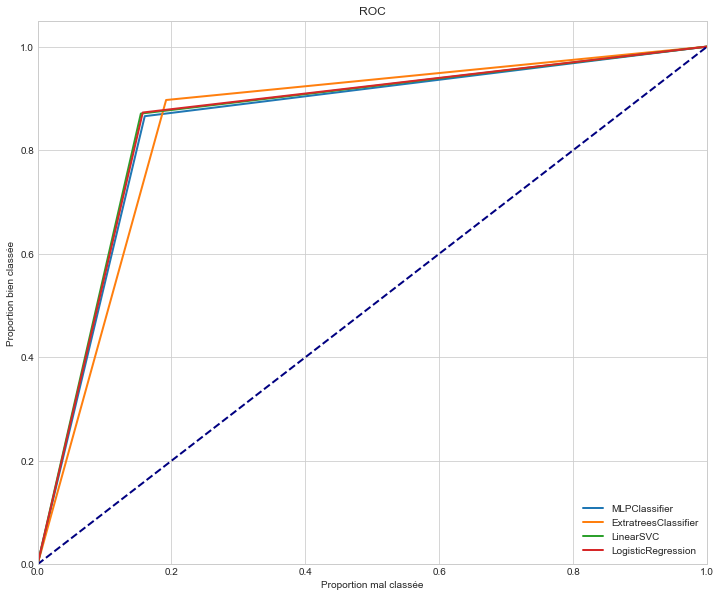

In [314]:
plt.figure(figsize=(12,10))
lw = 2
plt.plot(fpr1, tpr1, #color='darkorange',
         lw=lw, label='MLPClassifier')
plt.plot(fpr2, tpr2, #color='bleu', 
         lw=lw, label='ExtratreesClassifier')
plt.plot(fpr3, tpr3, #color='Olive', 
         lw=lw, label='LinearSVC')
plt.plot(fpr4, tpr4, #color='red', 
         lw=lw, label='LogisticRegression')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Proportion mal classée")
plt.ylabel("Proportion bien classée")
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('AUC')


###  Sommission du modèle final

In [315]:
sub_df = pd.read_csv(zf_test.open('test.csv'))
sub_df_target  = pd.read_csv(zf_test.open('sample_submission.csv'))
#sub_df = pd.read_csv('all/test.csv')
#sub_df_target = pd.read_csv('all/sample_submission.csv')

In [316]:
sub_df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375806 entries, 0 to 375805
Data columns (total 2 columns):
qid           375806 non-null object
prediction    375806 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.7+ MB


In [317]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375806 entries, 0 to 375805
Data columns (total 2 columns):
qid              375806 non-null object
question_text    375806 non-null object
dtypes: object(2)
memory usage: 5.7+ MB


In [323]:
sub_df.shape

(375806, 6)

In [326]:
sub_df.head()

qid                                      question_text  \
0  0000163e3ea7c7a74cd7  Why do so many women become so rude and arroga...   
1  00002bd4fb5d505b9161  When should I apply for RV college of engineer...   
2  00007756b4a147d2b0b3  What is it really like to be a nurse practitio...   
3  000086e4b7e1c7146103                             Who are entrepreneurs?   
4  0000c4c3fbe8785a3090   Is education really making good people nowadays?   

                                      clean_question  \
0  why do so many women become so rude and arroga...   
1  when should i apply for rv college of engineer...   
2  what is it really like to be a nurse practitioner   
3                              who are entrepreneurs   
4    is education really making good people nowadays   

                          tokeniZ_stopWords_question  \
0  [many, women, become, rude, arrogant, get, lit...   
1  [apply, rv, college, engineering, bms, college...   
2                [really, like, nurse, practitioner]   
3                                    [entrepreneurs]   
4  [education, really, making, good, people, nowa...   

                                   stemming_question  \
0  [mani, women, becom, rude, arrog, get, littl, ...   
1  [appli, rv, colleg, engin, bm, colleg, engin, ...   
2                   [realli, like, nurs, practition]   
3                                     [entrepreneur]   
4         [educ, realli, make, good, peopl, nowaday]   

                         stemming_question_for_tfidf  
0  mani women becom rude arrog get littl bit weal...  
1  appli rv colleg engin bm colleg engin wait com...  
2                        realli like nurs practition  
3                                       entrepreneur  
4                educ realli make good peopl nowaday

In [327]:
#Cleaning the data 
sub_df['clean_question'] = sub_df['question_text'].apply(clean_str)

#Tokenizing and stopwords removing
sub_df['tokeniZ_stopWords_question'] = sub_df['clean_question'].apply(tokeniZ_stopWords)

#Words Stemming
sub_df['stemming_question'] = [[ps.stem(word) for word in words] for words in sub_df['tokeniZ_stopWords_question'] ]
sub_df['stemming_question_for_tfidf'] = [' '.join(words) for words in sub_df['stemming_question']] 

In [328]:
#T3gram questions vectorization
X_t3gram_vect_sub_test  = t3gram_vectorizer.transform(sub_df['stemming_question_for_tfidf'])

In [329]:
#X_t3gram_vect_sub_test

In [332]:
Model_final_MLPClassifier = Pipeline([('Feature Selection',SelectPercentile(f_classif,percentile=70)),('Classification',MLPClassifier(random_state=random_state, 
                                                activation = str(space_eval(space,best)['activation'] ),
                                                 solver = str(space_eval(space,best)['solver']),
                                                 alpha = int(best['alpha']),
                                                 hidden_layer_sizes=tuple(space_eval(space,best)['hidden_layer_sizes']),
                                                 learning_rate = str(space_eval(space,best)['learning_rate'] )))]).fit(X_t3gram_vectorizer_train,y_cora_train)

In [333]:
sub_df['target'] = Model_final_MLPClassifier.predict(X_t3gram_vect_sub_test)

In [334]:
final_submission1 = pd.merge(sub_df,sub_df_target,how='inner',on='qid' )

In [335]:
final_submission = (final_submission1[['qid','target']]).rename(columns={'target':'prediction'})

In [336]:
final_submission.to_csv('final_submission.csv', index=False, sep=',')

In [337]:
final_submission.head()

qid  prediction
0  0000163e3ea7c7a74cd7           1
1  00002bd4fb5d505b9161           0
2  00007756b4a147d2b0b3           0
3  000086e4b7e1c7146103           0
4  0000c4c3fbe8785a3090           1

In [338]:
%ls

40 Python Interview and Answer_1556434162.pdf
AI_Python_1565122869.pdf
API_11_DS2_en_csv_v2_42980/
AUC.png
A_B Testing.ipynb
Agriculture/
Agriculture_Data.ipynb
Algo/
Algorithms_Note_for_professionals_1566716738.pdf
Book/
Chapter-10---Normal-Crime_2015_Data-Mining-and-Predictive-Analysis.pdf*
Chapter-16---Future-Trends_2015_Data-Mining-and-Predictive-Analysis.pdf*
Chapter-2---Domain-Expertise_2015_Data-Mining-and-Predictive-Analysis.pdf*
Chapter-4---Process-Models-for-Data-Mining-and_2015_Data-Mining-and-Predicti.pdf*
Cleaning_Data_NLP.ipynb
Copyright_2015_Data-Mining-and-Predictive-Analysis.pdf*
Cora_competition.ipynb
Correlation Matrice.png
Customer_Behaviour_1566388260.pdf
DATA_SCIENCE_INTERVIEW_QUESTIONS.pdf
Data science - copie.pdf
Data_Visualization_in_Practice_1566388340.pdf
Dedication_2015_Data-Mining-and-Predictive-Analysis.pdf*
Digital-Assets_2015_Data-Mining-and-Predictive-Analysis.pdf*
Feature_Engineering_for_Machine_Learning.pdf
Features_Engineering_Boxplot.png
Features_En